# 3D Graphics Systems | AI Graphics - Theory and Practice | IMPA 2023
### Instructor: Luiz Velho
### TA: Hallison Paz
### Course info: https://lvelho.impa.br/i3d23/

## Lab Class #13 - Estimating Mesh, Texture and Camera using differentiable rendering

---
#**Personal Info:**
*   **Student:**
    *   Sherlon Almeida da Silva
*   **Affiliation:**
    *   PhD Student
    *   University of São Paulo (USP)
    *   Institute of Mathematics and Computer Science (ICMC)
    *   Laboratory of Visualization, Imaging and Computer Graphics (VICG)
*   **Research & Programming:**
    *   [Lattes](http://lattes.cnpq.br/0000096258045504) | [ORCID](https://orcid.org/0000-0001-6124-9350) | [Google Scholar](https://scholar.google.com.br/citations?user=boFxo4gAAAAJ&hl=pt-BR) | [Linkedin](https://www.linkedin.com/in/SherlonAlmeida/) | [Github](https://github.com/SherlonAlmeida) | [Personal Page](http://vicg.icmc.usp.br/vicg/person/72/sherlon-almeida-da-silva)
---

## 0. Install and Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [1]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61405 sha256=7fa4207377a3b52ac6cbec3a6df241f48b8bb699b06a6e7c3fc1a8ffa45f7f35
  Stored in directory: /root/.cache/pip/wheels/01/c0/af/77c1cf53a1be9e42a52b48e5af2169d40ec2e89f7362489dd0
  Created wheel for iopath: filename=iopath-0.1.10-py3-none-any.whl size=31531 sha256=3eac145552812aa3771fb51d7be99059ed97eeb69e97e89e27644e7a0ceaed61
  Stored in directory: /root/.cache/pip/wheels/9a/a3/b6/ac0fcd1b4ed5cfeb3db92e6a0e476cfd48ed0df92b91080c1d
Successfully built fvcore iopath
Looking in links: https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/py310_cu118_pyt201/dow

In [2]:
import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

from pytorch3d.utils import ico_sphere
import numpy as np
from tqdm.notebook import tqdm

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, save_obj

from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency,
)

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    look_at_rotation,
    FoVPerspectiveCameras,
    PointLights,
    DirectionalLights,
    Materials,
    RasterizationSettings,
    MeshRenderer,
    MeshRasterizer,
    SoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    TexturesVertex
)

# add path for demo utils functions
import sys
import os
sys.path.append(os.path.abspath(''))

If using **Google Colab**, fetch the utils file for plotting image grids:

In [3]:
!wget https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
from plot_image_grid import image_grid

--2023-06-23 02:26:37--  https://raw.githubusercontent.com/facebookresearch/pytorch3d/master/docs/tutorials/utils/plot_image_grid.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1608 (1.6K) [text/plain]
Saving to: ‘plot_image_grid.py’

plot_image_grid.py  100%[===================>]   1.57K  --.-KB/s    in 0s      

2023-06-23 02:26:37 (43.2 MB/s) - ‘plot_image_grid.py’ saved [1608/1608]



OR if running **locally** uncomment and run the following cell:

In [ ]:
#  from utils.plot_image_grid import image_grid

If running this notebook using **Google Colab**, run the following cell to fetch the mesh obj and texture files and save it at the path `data/cow_mesh`:
If running locally, the data is already available at the correct path.

In [4]:
!mkdir -p data/cow_mesh
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
!wget -P data/cow_mesh https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow_texture.png

--2023-06-23 02:26:37--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.obj
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.35, 13.35.8.51, 13.35.8.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 330659 (323K) [text/plain]
Saving to: ‘data/cow_mesh/cow.obj’

cow.obj             100%[===================>] 322.91K  --.-KB/s    in 0.004s  

2023-06-23 02:26:37 (82.3 MB/s) - ‘data/cow_mesh/cow.obj’ saved [330659/330659]

--2023-06-23 02:26:37--  https://dl.fbaipublicfiles.com/pytorch3d/data/cow_mesh/cow.mtl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.35.8.35, 13.35.8.51, 13.35.8.19, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.35.8.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 155 [text/plain]
Saving to: ‘data/cow_mesh/cow.mtl’

cow.mtl             100%[===================>]    

In [5]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")



#### Remember:
**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**TexturesVertex** is an auxillary datastructure for storing vertex rgb texture information about meshes.

## 1. Load a mesh and texture file

1.1 Load an `.obj` file and it's associated `.mtl` file and create a **Textures** and **Meshes** object. Transform the vertices so that the mesh is centered at the origin and contained in the unit sphere.

In [6]:
#Carregando o objeto e a textura
mesh = load_objs_as_meshes(files=["./data/cow_mesh/cow.obj"], load_textures=True, device=device)

In [7]:
#Calculando o centro da malha
center = mesh.verts_list()[0].mean(0)
center

tensor([1.8309e-10, 1.0297e-01, 1.9336e-01], device='cuda:0')

In [8]:
#Apresentando os vértices originais
mesh.verts_list()[0]

tensor([[ 0.3488, -0.3350, -0.0832],
        [ 0.3131, -0.3991,  0.8812],
        [ 0.2668,  0.1816,  0.1227],
        ...,
        [-0.0132, -0.0889,  1.0422],
        [-0.0137, -0.0943,  1.0340],
        [-0.0137, -0.0796,  1.0469]], device='cuda:0')

In [9]:
#Realizando a translação da malha a partir do centro
mesh.verts_list()[0] -= center
mesh.verts_list()[0]

tensor([[ 0.3488, -0.4380, -0.2766],
        [ 0.3131, -0.5020,  0.6878],
        [ 0.2668,  0.0787, -0.0706],
        ...,
        [-0.0132, -0.1919,  0.8489],
        [-0.0137, -0.1972,  0.8407],
        [-0.0137, -0.1825,  0.8536]], device='cuda:0')

In [10]:
#Calculando a variação máxima do objeto para então normalizar
scale = max(mesh.verts_list()[0].abs().max(0)[0])
scale

tensor(0.8623, device='cuda:0')

In [11]:
#Normalizando a malha
mesh.verts_list()[0] /= scale
mesh.verts_list()[0]

tensor([[ 0.4045, -0.5079, -0.3208],
        [ 0.3632, -0.5822,  0.7977],
        [ 0.3094,  0.0912, -0.0819],
        ...,
        [-0.0153, -0.2226,  0.9845],
        [-0.0159, -0.2287,  0.9749],
        [-0.0159, -0.2117,  0.9899]], device='cuda:0')

In [12]:
#Calculando a variação máxima do objeto (Verificando de deu certo)
max(mesh.verts_list()[0].abs().max(0)[0])

tensor(1., device='cuda:0')

## 2. Dataset Creation

We sample different camera positions that encode multiple viewpoints of the cow.  We create a renderer with a shader that performs texture map interpolation.  We render a synthetic dataset of images of the textured cow mesh from multiple viewpoints.


In [13]:
# the number of different viewpoints from which we want to render the mesh.
num_views = 20

# Get a batch of viewing angles.
elev = torch.linspace(0, 360, num_views)
azim = torch.linspace(-180, 180, num_views)

# Place a point light in front of the object. As mentioned above, the front of
# the cow is facing the -z direction.
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Initialize an OpenGL perspective camera that represents a batch of different
# viewing angles. All the cameras helper methods support mixed type inputs and
# broadcasting. So we can view the camera from the a distance of dist=2.7, and
# then specify elevation and azimuth angles for each viewpoint as tensors.
R, T = look_at_view_transform(dist=2.7, elev=elev, azim=azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# We arbitrarily choose one particular view that will be used to visualize
# results
camera = FoVPerspectiveCameras(device=device, R=R[None, 1, ...], T=T[None, 1, ...])

# Define the settings for rasterization and shading. Here we set the output
# image to be of size 128X128. As we are rendering images for visualization
# purposes only we will set faces_per_pixel=1 and blur_radius=0.0. Refer to
# rasterize_meshes.py for explanations of these parameters.  We also leave
# bin_size and max_faces_per_bin to their default values of None, which sets
# their values using huristics and ensures that the faster coarse-to-fine
# rasterization method is used.  Refer to docs/notes/renderer.md for an
# explanation of the difference between naive and coarse-to-fine rasterization.
raster_settings = RasterizationSettings(
    perspective_correct=False,
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)

# Create a phong renderer by composing a rasterizer and a shader. The textured
# phong shader will interpolate the texture uv coordinates for each vertex,
# sample from a texture image and apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device,
        cameras=camera,
        lights=lights
    )
)

# Create a batch of meshes by repeating the cow mesh and associated textures.
# Meshes has a useful `extend` method which allows us do this very easily.
# This also extends the textures.
# =======================================
# TODO: if you named your variable other than 'mesh',
# you should adapt the next line
meshes = mesh.extend(num_views)
# =======================================

# Render the cow mesh from each viewing angle
target_images = renderer(meshes, cameras=cameras, lights=lights)

# Our multi-view cow dataset will be represented by these 2 lists of tensors,
# each of length num_views.
target_rgb = [target_images[i, ..., :3] for i in range(num_views)]
target_cameras = [FoVPerspectiveCameras(device=device, R=R[None, i, ...],
                                           T=T[None, i, ...]) for i in range(num_views)]

Visualize the dataset:

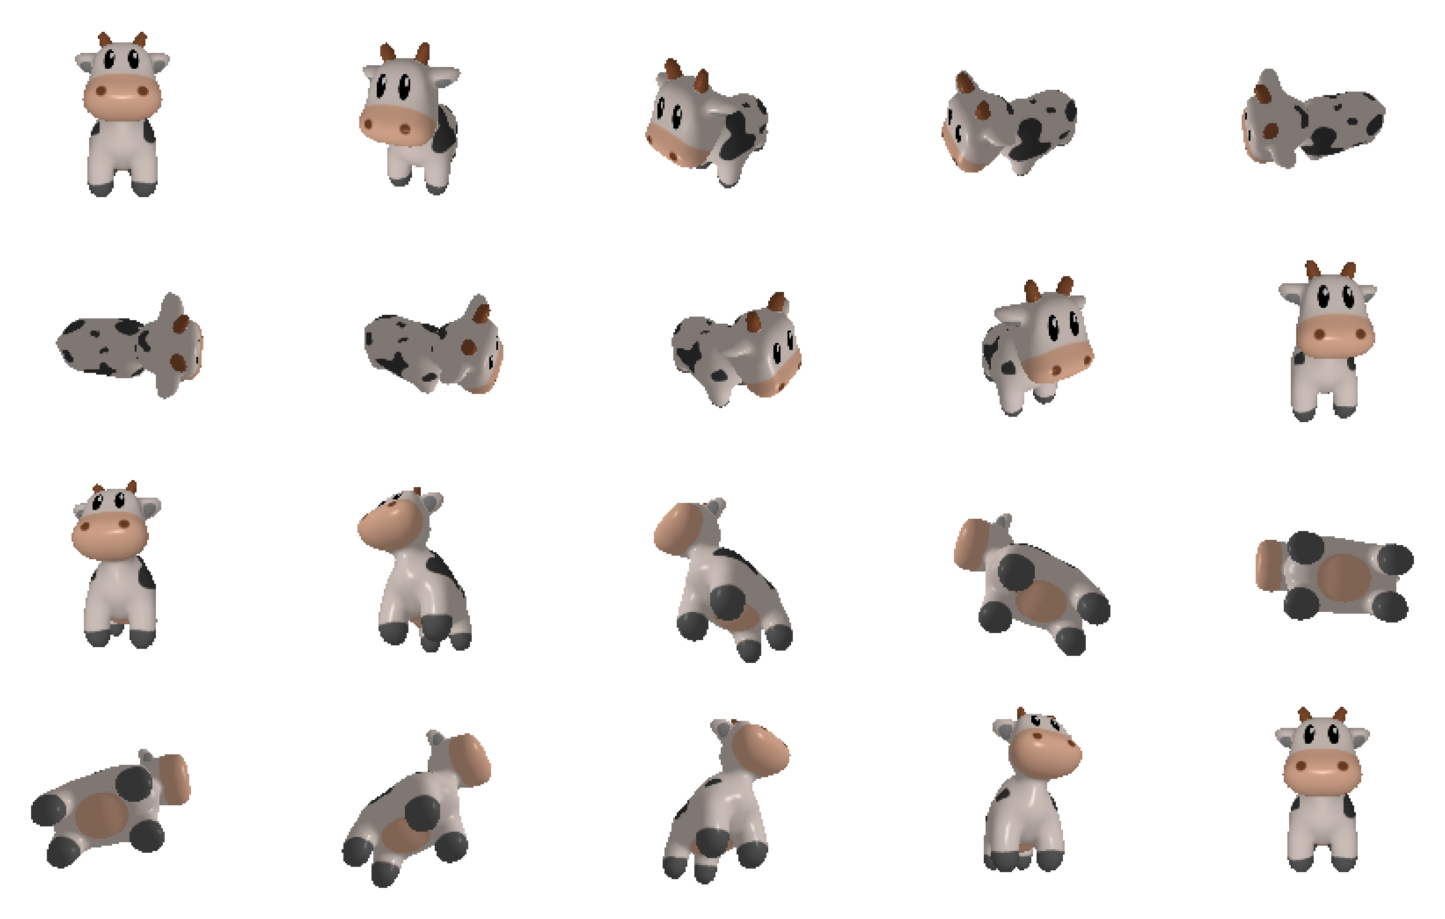

In [14]:
# RGB images
image_grid(target_images.cpu().numpy(), rows=4, cols=5, rgb=True)
plt.show()

## Questions

2.1 Present a high level description of a rendering pipeline based on **rasterization** (*not ray tracing!*). Which steps are inherently not differentiable? How could we re-design these operations to build a fully differentiable pipeline?

**Considerations:** A rasterization-based rendering pipeline involves several steps: geometry processing, vertex shading, primitive assembly, rasterization, fragment shading, depth testing, and blending. The steps of rasterization and depth testing are inherently non-differentiable. One approach to redesign it is to use differentiable sampling techniques, representing fragments as continuous functions instead of discrete samples. The depth test can be replaced with a differentiable operation that considers depth values as continuous variables. By making these modifications, the pipeline becomes differentiable, allowing for integration with gradient-based optimization methods and enabling applications like differentiable graphics, rendering optimization, and training neural networks for computer graphics tasks.

2.2 Place a point light in the scene and render the meshes again using the silhouette renderer. Does it make any difference? Why?

**Considerations:** Since the shader considers only the object's silhouette from each point of view, illumination does not matter in generating the 2D shape format rasterized with the silhouette shader.

In [ ]:
##############################################################################
# Code and explanations for 2.1 - 2.2
##############################################################################

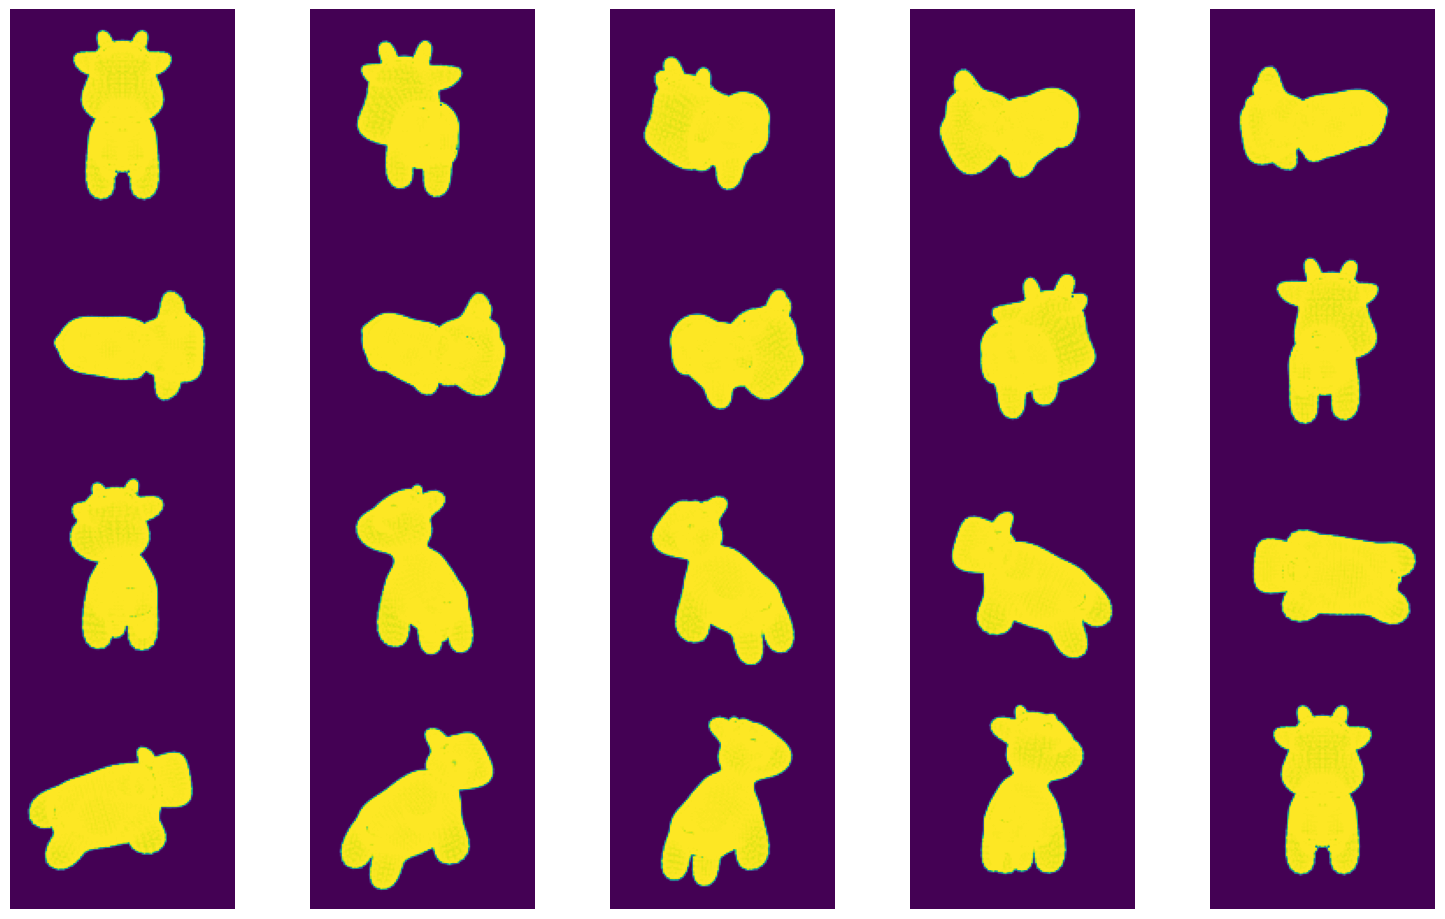

In [15]:
from pytorch3d.renderer import BlendParams

#Usando a mesma configuração do RasterizationSettings dada para o exemplo acima
"""raster_settings = RasterizationSettings(
    perspective_correct=False,
    image_size=128,
    blur_radius=0.0,
    faces_per_pixel=1,
)"""

#Usando a configuração apresentada no tutorial do Pytorch 3D
sigma = 1e-4
raster_settings_silhouette = RasterizationSettings(
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

new_lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

renderer_silhouette = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_silhouette
    ),
    shader=SoftSilhouetteShader()
)

silhouette_images = renderer_silhouette(meshes, cameras=cameras, lights=new_lights)
target_silhouette = [silhouette_images[i, ..., 3] for i in range(num_views)]

# Visualize silhouette images
image_grid(silhouette_images.cpu().numpy(), rows=4, cols=5, rgb=False)
plt.show()

## 3. Mesh prediction via silhouette rendering

In the previous section, we created a dataset of images of multiple viewpoints of a cow.

Later, we will fit a mesh to the rendered RGB images, as well as to just images of just the cow silhouette.  For the latter case, we will render a dataset of silhouette images.  Most shaders in PyTorch3D will output an alpha channel along with the RGB image as a 4th channel in an RGBA image.  The alpha channel encodes the probability that each pixel belongs to the foreground of the object. We contruct a soft silhouette shader to render this alpha channel.

---

**Consideration:** *Considering the generated viewpoints as images, these images will be utilized to generate an object approximation. In contrast to the approach taken in assignment 9, which considered the target 3D object, this method focuses solely on the viewpoints themselves.*

In this section, we predict a mesh by observing those target images without any knowledge of the ground truth cow mesh.  We assume we know the position of the cameras and lighting.

We first define some helper functions to visualize the results of our mesh prediction:

In [16]:
# Show a visualization comparing the rendered predicted mesh to the ground truth mesh
def visualize_prediction(predicted_mesh, renderer=renderer_silhouette,
                         target_image=target_rgb[1], title='',
                         silhouette=False):
    inds = 3 if silhouette else range(3)
    predicted_images = renderer(predicted_mesh)
    plt.figure(figsize=(20, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(predicted_images[0, ..., inds].cpu().detach().numpy())

    plt.subplot(1, 2, 2)
    plt.imshow(target_image.cpu().detach().numpy())
    plt.title(title)
    plt.grid("off")
    plt.axis("off")

# Plot losses as a function of optimization iteration
def plot_losses(losses):
    fig = plt.figure(figsize=(13, 5))
    ax = fig.gca()
    for k, l in losses.items():
        ax.plot(l['values'], label=k + " loss")
    ax.legend(fontsize="16")
    ax.set_xlabel("Iteration", fontsize="16")
    ax.set_ylabel("Loss", fontsize="16")
    ax.set_title("Loss vs iterations", fontsize="16")

Starting from a sphere mesh, we will learn offsets of each vertex such that the predicted mesh silhouette is more similar to the target silhouette image at each optimization step.  We begin by loading our initial sphere mesh:

In [17]:
# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target silhouettes:

In [18]:
# Losses to smooth / regularize the mesh shape
def update_mesh_shape_prior_losses(mesh, loss):
    # and (b) the edge length of the predicted mesh
    loss["edge"] = mesh_edge_loss(mesh)

    # mesh normal consistency
    loss["normal"] = mesh_normal_consistency(mesh)

    # mesh laplacian smoothing
    loss["laplacian"] = mesh_laplacian_smoothing(mesh, method="uniform")

In [19]:
def approximate_object_based_on_view_points(num_views_per_iteration, Niter, plot_period, optimizer, losses, deform_verts, approx_mesh):
  loop = tqdm(range(Niter))

  for i in loop:
      # Initialize optimizer
      optimizer.zero_grad()

      # Deform the mesh
      aux_mesh = approx_mesh.offset_verts(deform_verts)

      # Losses to smooth /regularize the mesh shape
      loss = {k: torch.tensor(0.0, device=device) for k in losses}
      update_mesh_shape_prior_losses(aux_mesh, loss)

      # Compute the average silhouette loss over two random views, as the average
      # squared L2 distance between the predicted silhouette and the target
      # silhouette from our dataset
      for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
          images_predicted = renderer_silhouette(aux_mesh, cameras=target_cameras[j], lights=lights)
          predicted_silhouette = images_predicted[..., 3]
          loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
          loss["silhouette"] += loss_silhouette / num_views_per_iteration

      # Weighted sum of the losses
      sum_loss = torch.tensor(0.0, device=device)
      for k, l in loss.items():
          sum_loss += l * losses[k]["weight"]
          losses[k]["values"].append(l.detach().cpu())

      # Print the losses
      loop.set_description("total_loss = %.6f" % sum_loss)

      # Plot mesh
      if i % plot_period == 0:
          visualize_prediction(aux_mesh, title="iter: %d" % i, silhouette=True,
                              target_image=target_silhouette[1])

      # Optimization step
      sum_loss.backward()
      optimizer.step()

  return aux_mesh

We write an optimization loop to iteratively refine our predicted mesh from the sphere mesh into a mesh that matches the sillhouettes of the target images:

In [20]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 4

# Number of optimization steps
Niter = 5000

# Plot period for the losses
plot_period = 2*250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.05, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  0%|          | 0/5000 [00:00<?, ?it/s]

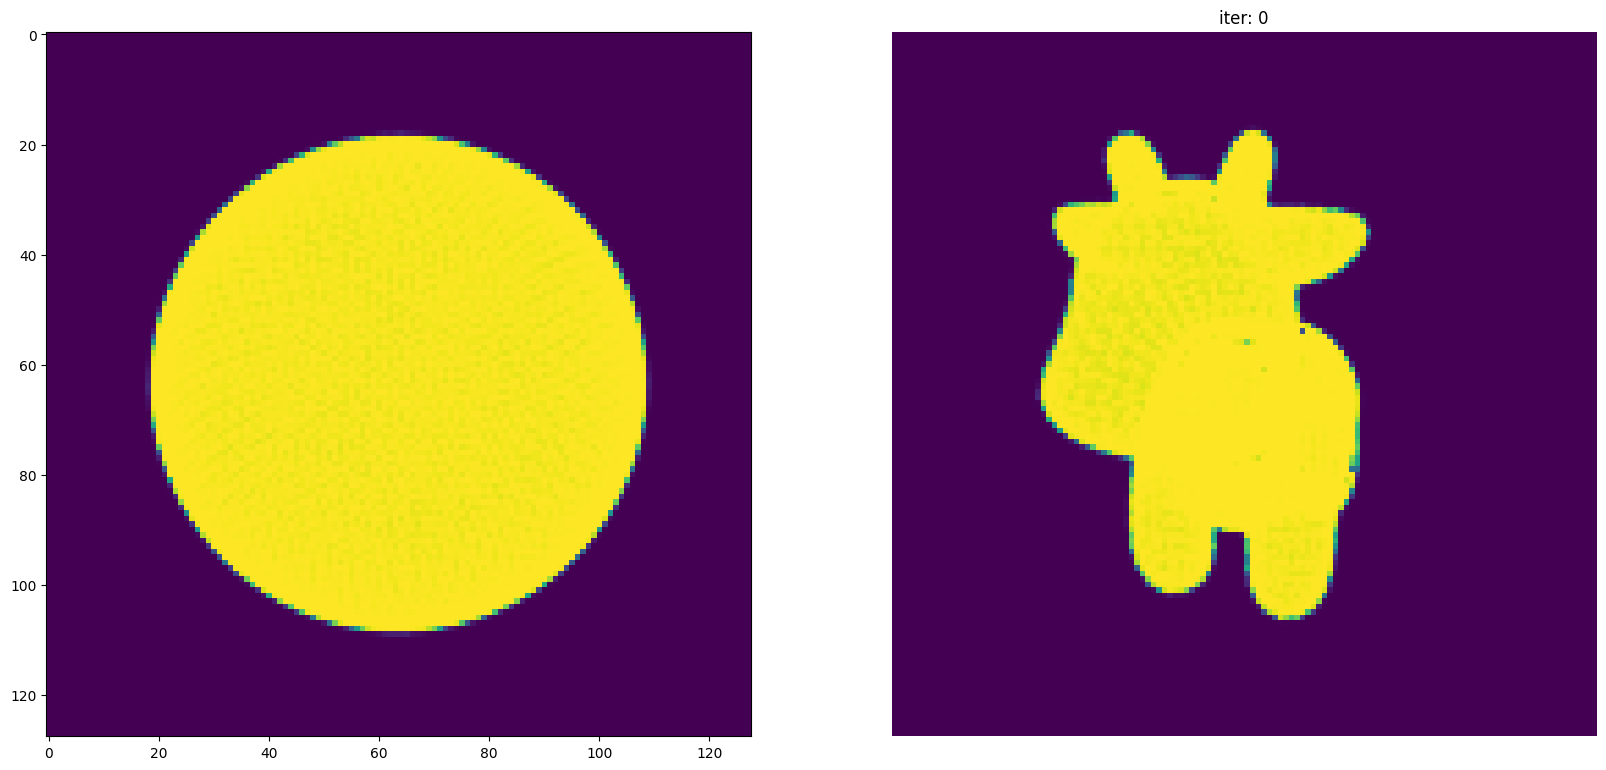

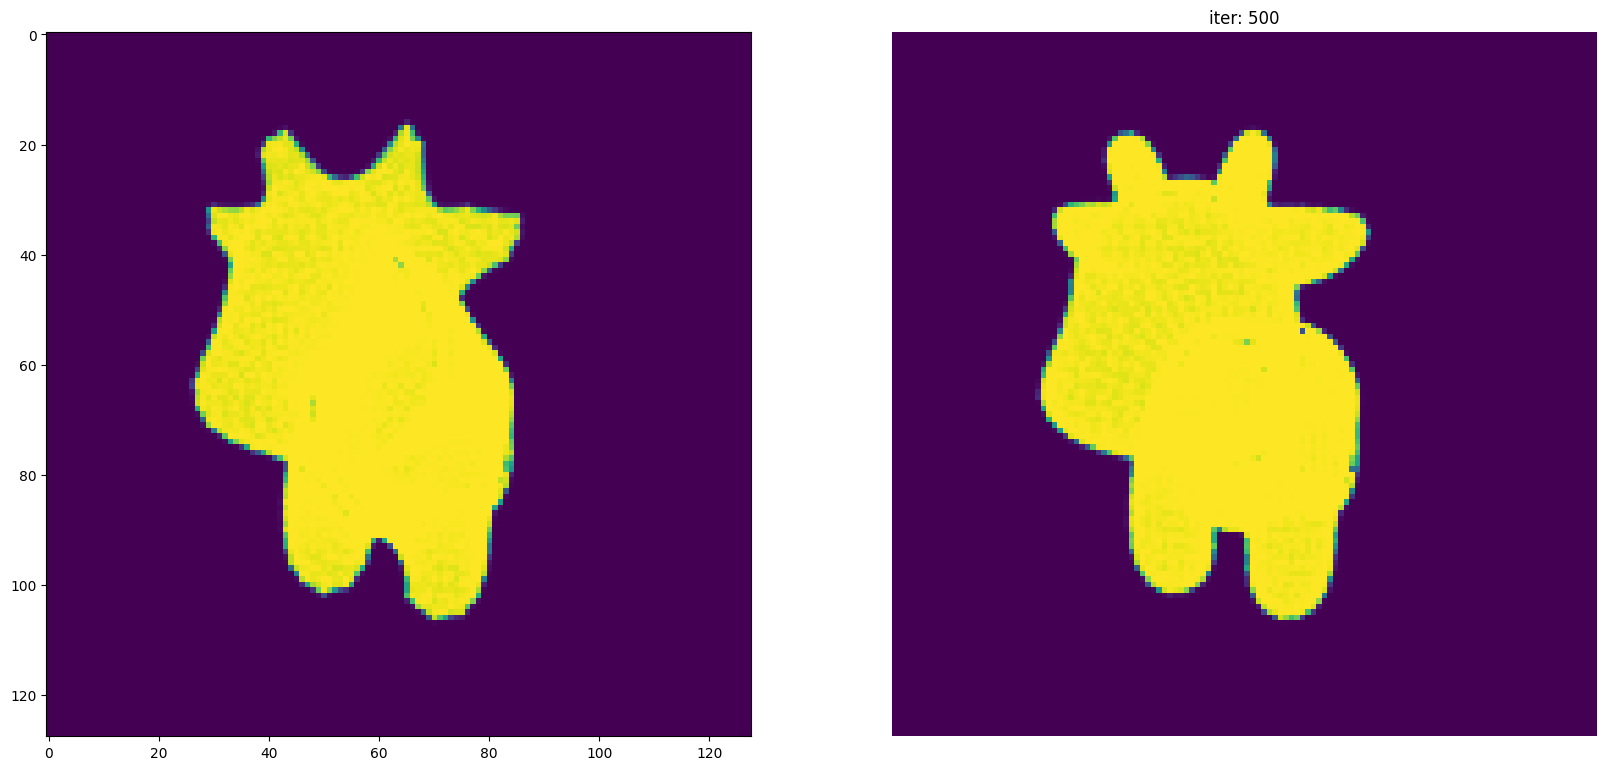

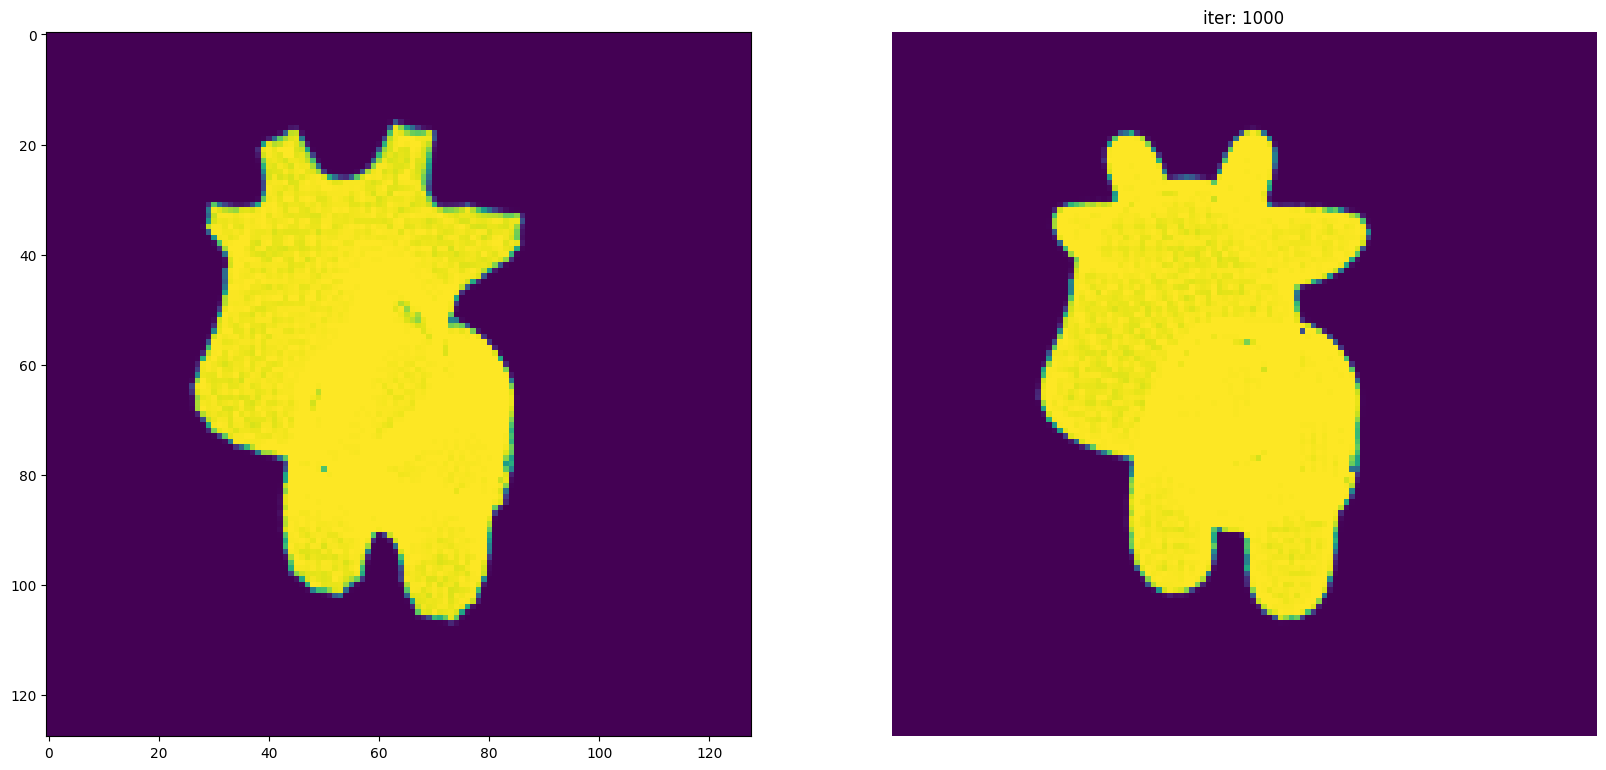

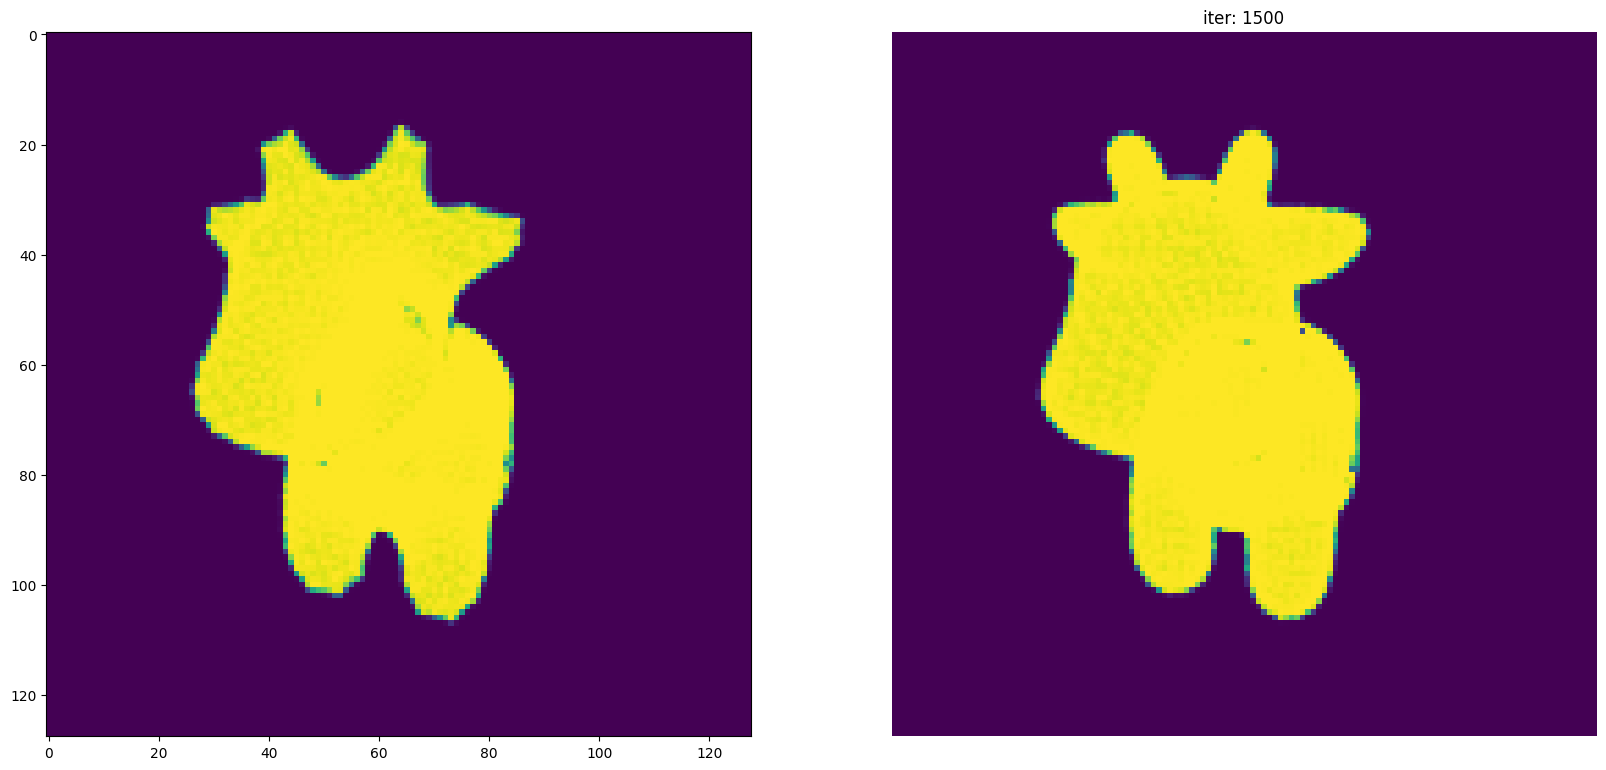

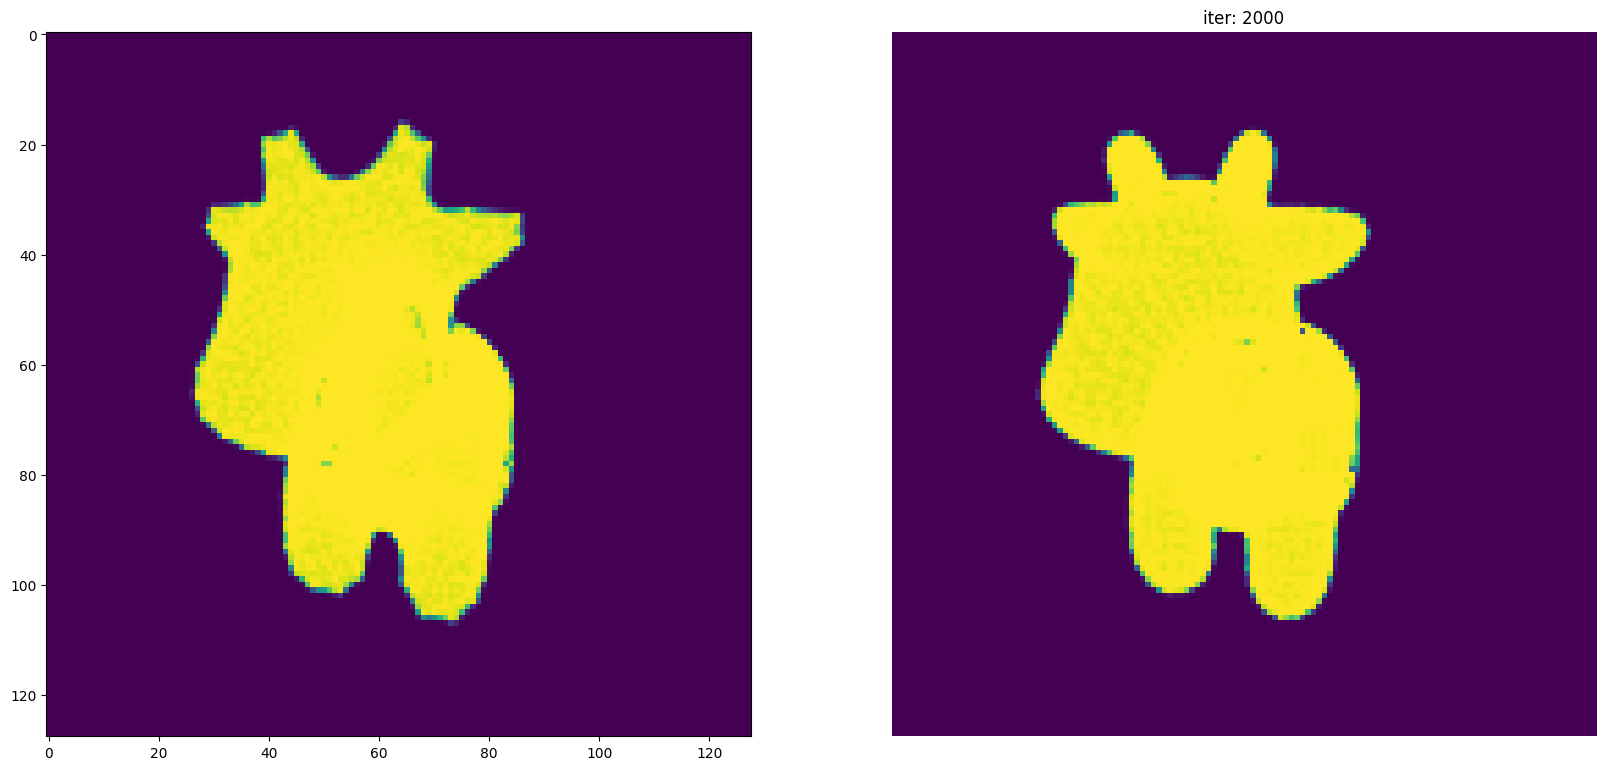

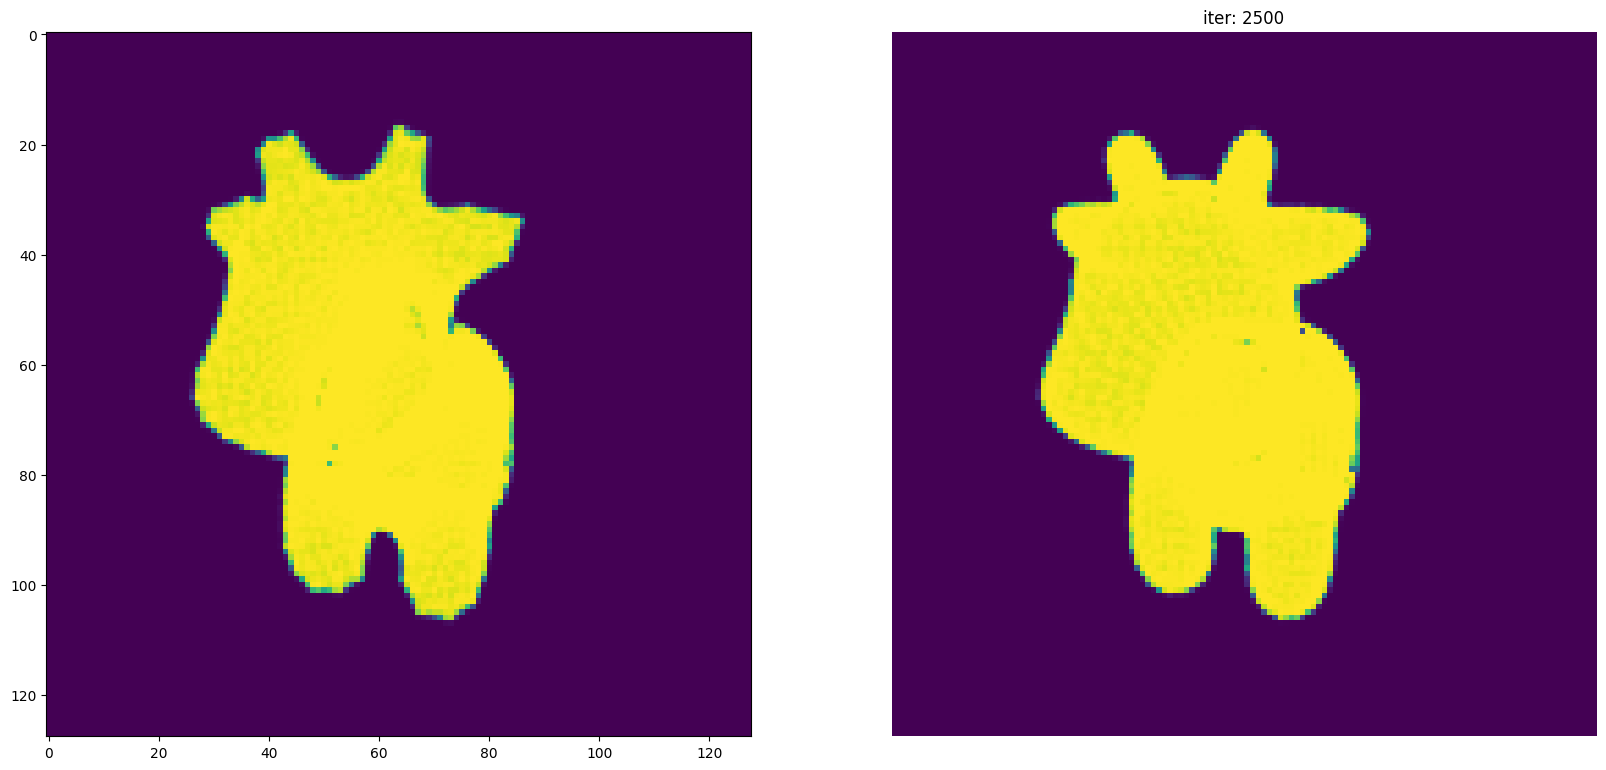

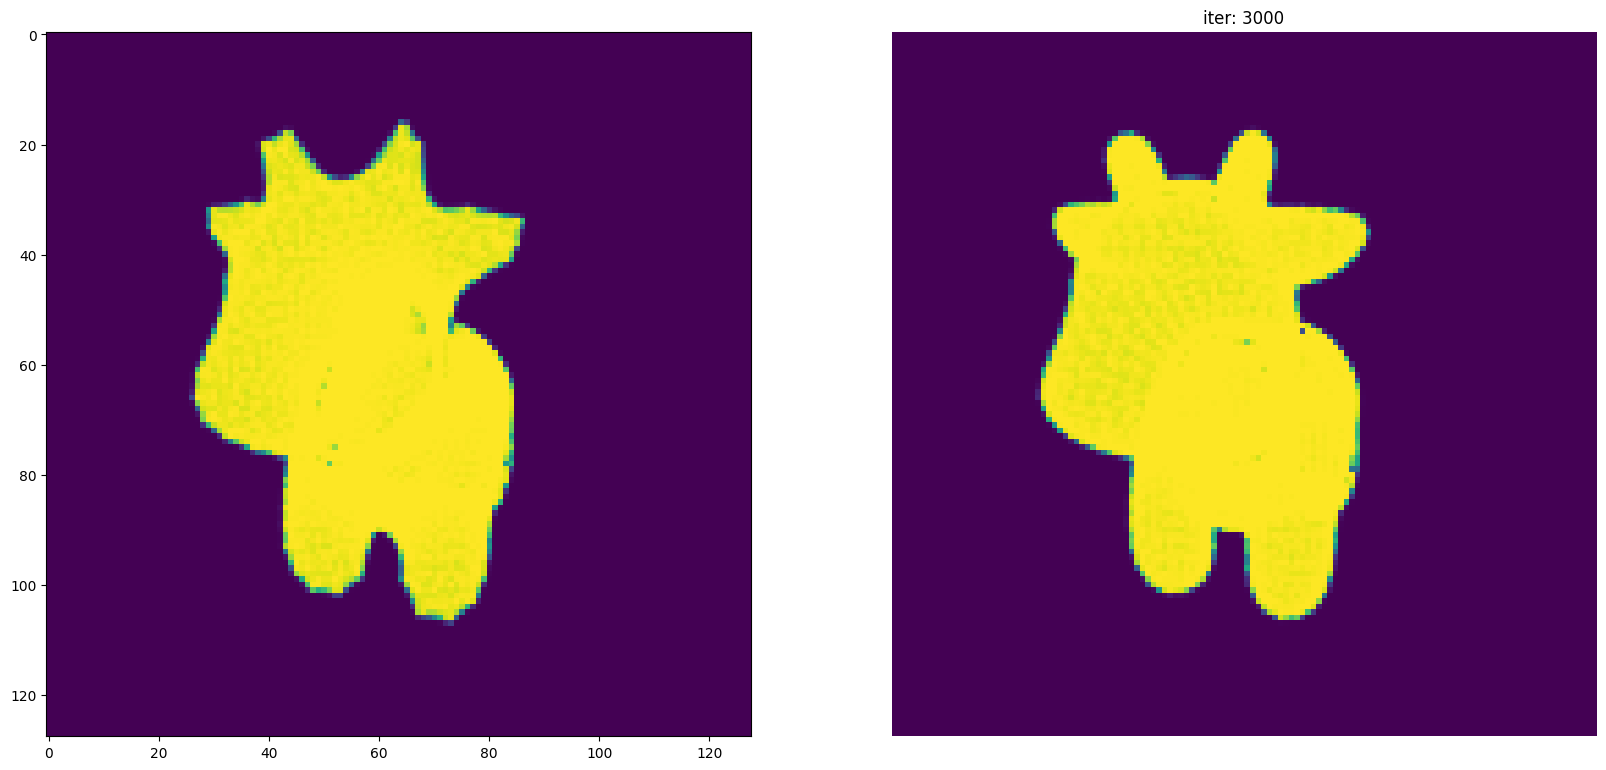

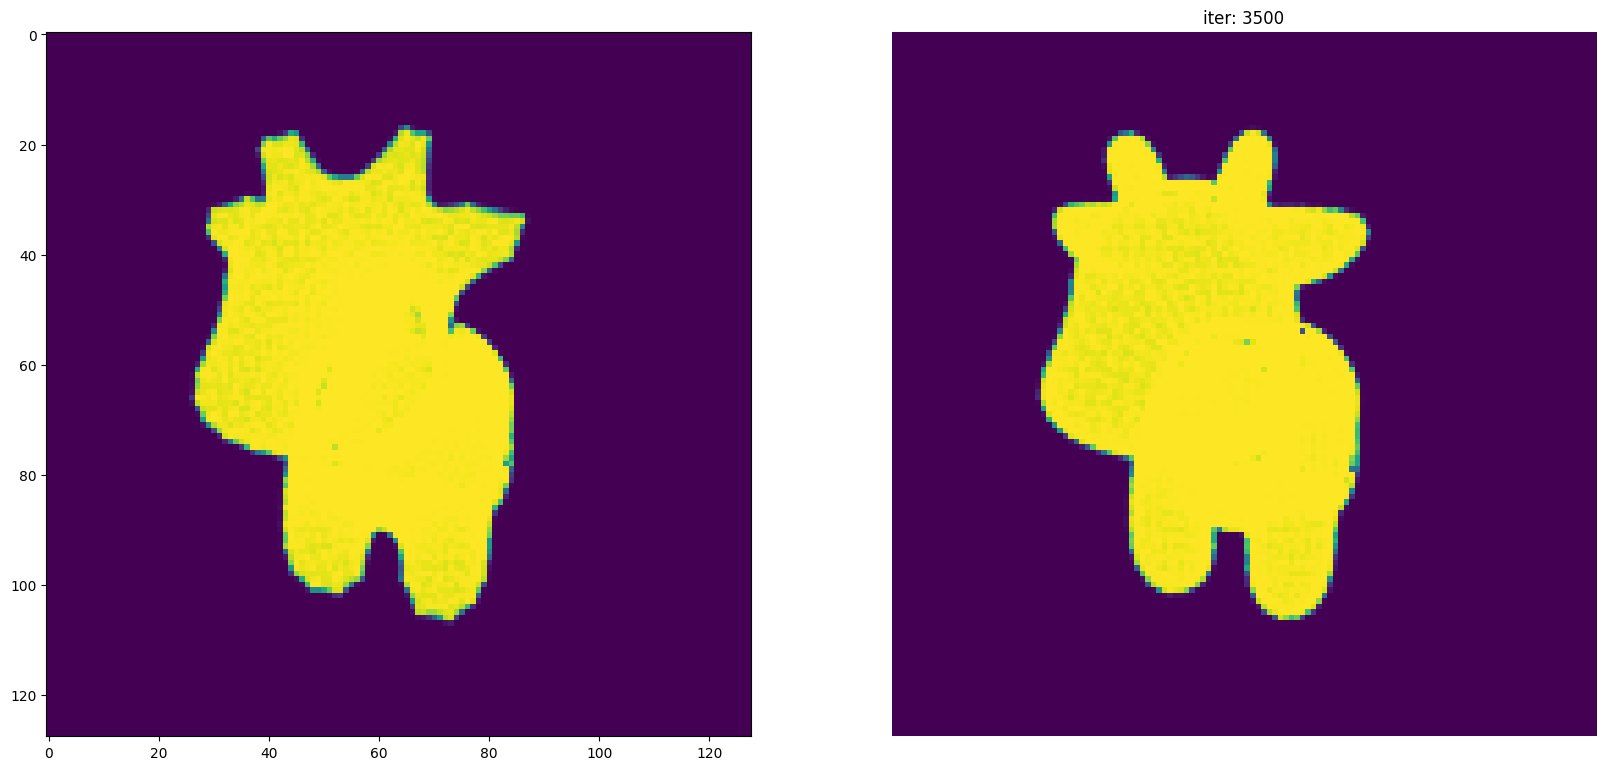

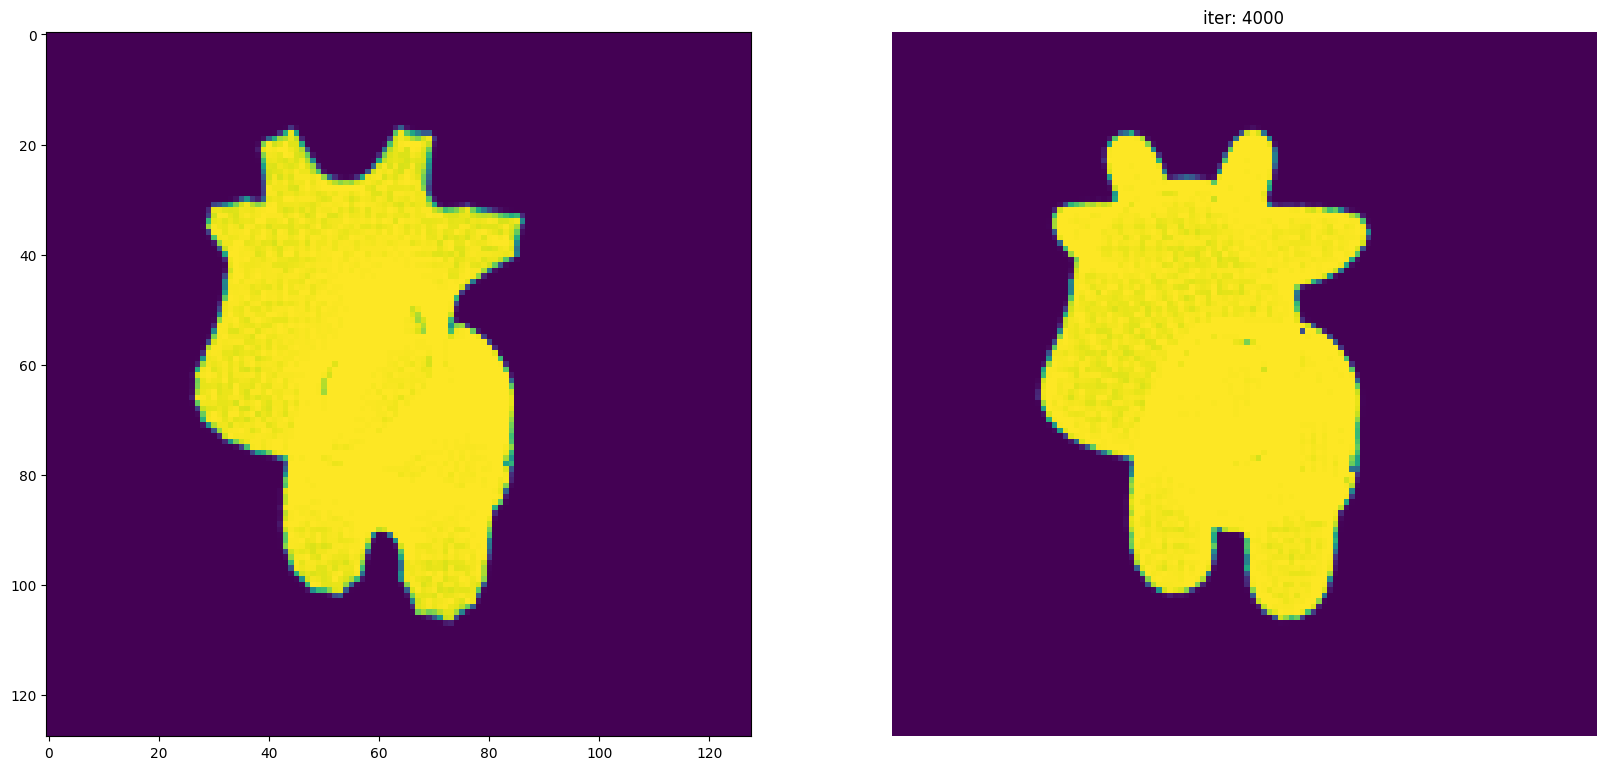

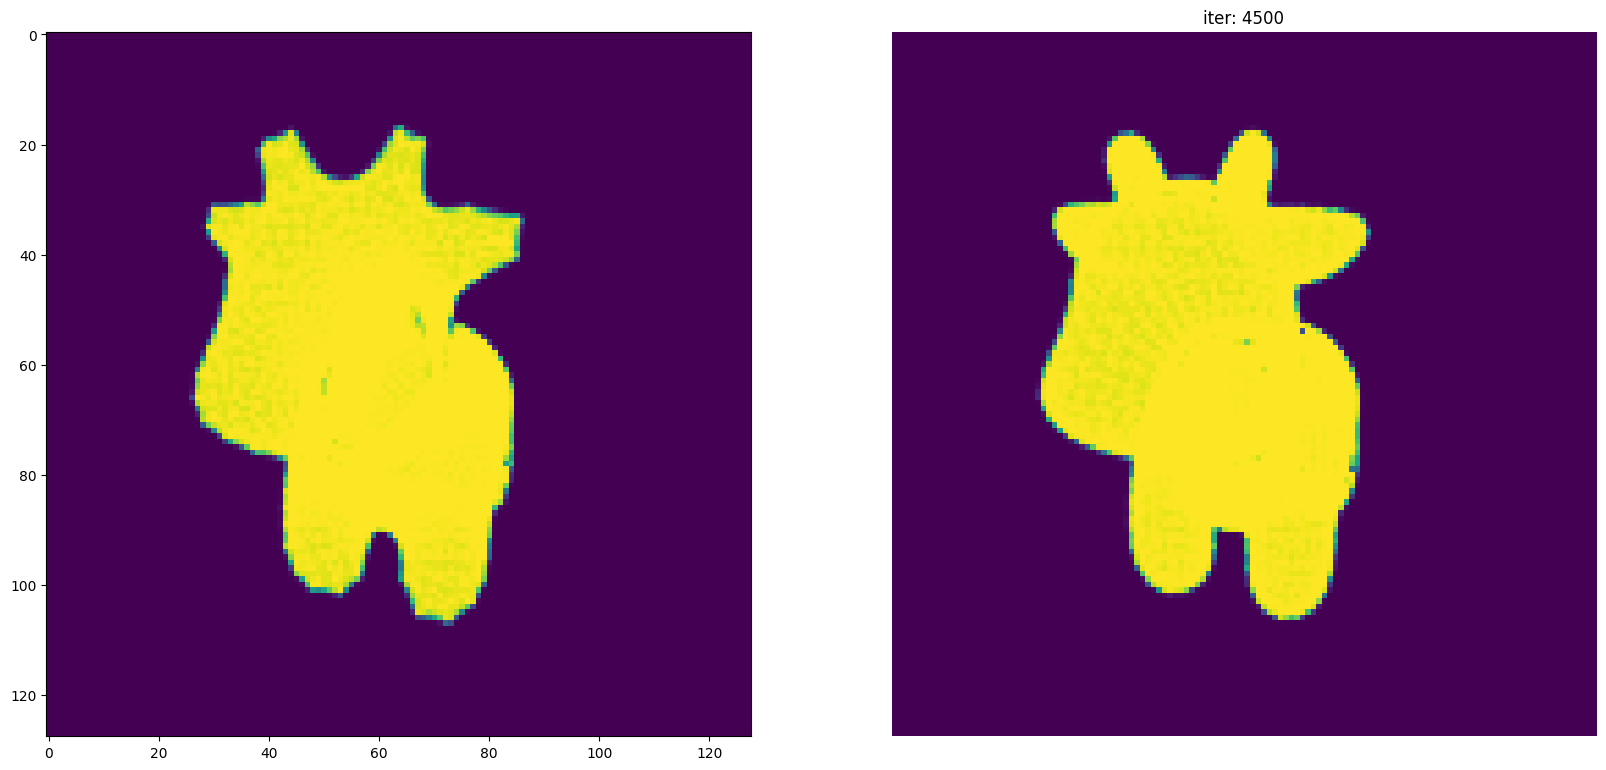

In [21]:
new_src_mesh = approximate_object_based_on_view_points(num_views_per_iteration, Niter, plot_period, optimizer, losses, deform_verts, src_mesh)

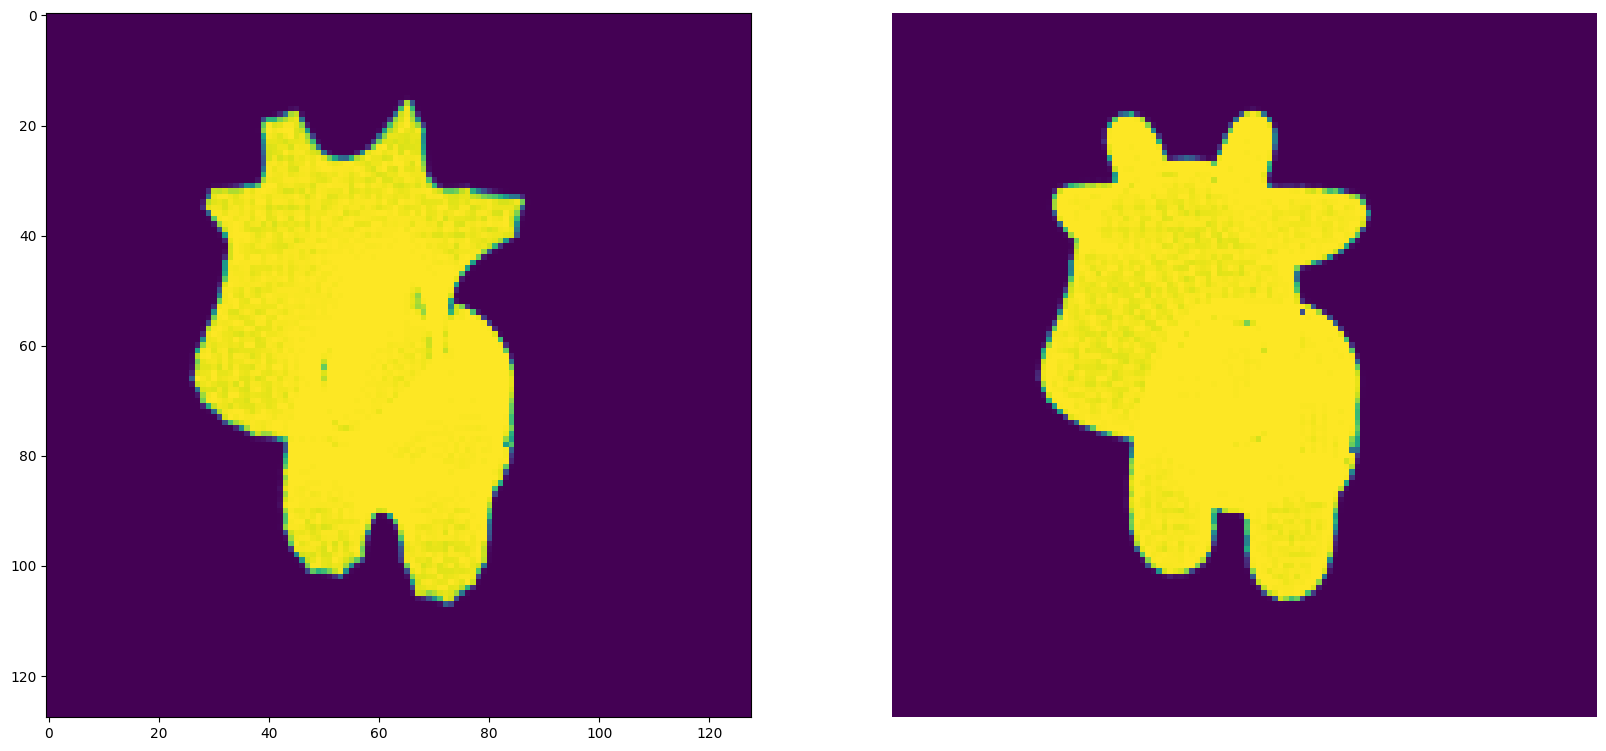

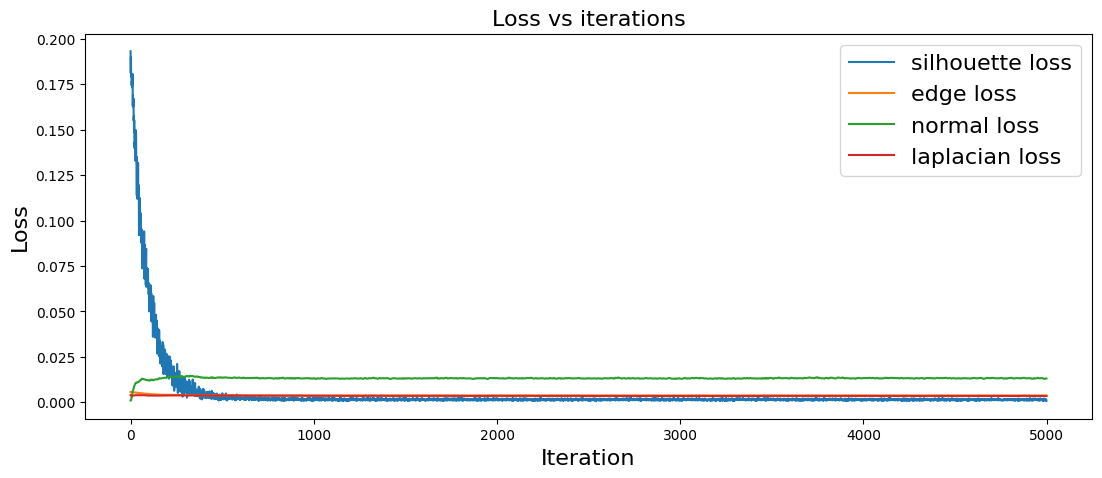

In [22]:
visualize_prediction(new_src_mesh, silhouette=True, target_image=target_silhouette[1])
plot_losses(losses)

## Questions

3.1 Visualize the deformed mesh using `Plotly` and describe it qualitatively in comparison with the target mesh. You can also download it and visualize it in another software if you wish.

**Considerations:** The result presented below seems to be accurate but lacks sufficient detail. The predicted object is not as smooth as the original one. Various factors can affect the result, such as the quality of the silhouette. I have experimented with different configurations of the rasterization process, and in one instance, the sphere couldn't approximate the target mesh. It is possible that considering more views in the optimization process could lead to an improved result.

In [57]:
##############################################################################
# Code and explanations for 3.1 - 3.3
##############################################################################

In [23]:
from pytorch3d.vis.plotly_vis import AxisArgs, plot_batch_individually, plot_scene
from pytorch3d.vis.texture_vis import texturesuv_image_matplotlib

def show_plotly_side_by_side(mesh1, title1, mesh2, title2):
    # Render the plotly figure
    fig = plot_scene(
        plots= {
          title1: {
              "shapenet_mesh": mesh1
          },
          title2: {
              "shapenet_mesh": mesh2
          }
        },
        ncols = 2
    )
    fig.show()

In [24]:
#Plotando os objetos lado a lado
show_plotly_side_by_side(new_src_mesh, "Predicted", mesh, "Source")

3.2 Experiment changing the number of images `num_views_per_iteration` used to compute the silhouette loss each iteration. Would it still work if we computed the loss using `num_views_per_iteration = 1`? What if we only had a single image, a single point of view, in our dataset?

**Considerations:** the results are worst than the prediction using 4 viewpoints. This result was expected once less information (only 1 viewpoint) was considered to approximate the target mesh.

In [26]:
# We initialize the source shape to be a sphere of radius 1.
src_mesh = ico_sphere(4, device)

In [27]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 1

# Number of optimization steps
Niter = 5000

# Plot period for the losses
plot_period = 2*250

%matplotlib inline

# Optimize using rendered silhouette image loss, mesh edge loss, mesh normal
# consistency, and mesh laplacian smoothing
losses = {"silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.05, "values": []},
          "laplacian": {"weight": 1.0, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts], lr=1.0, momentum=0.9)

  0%|          | 0/5000 [00:00<?, ?it/s]

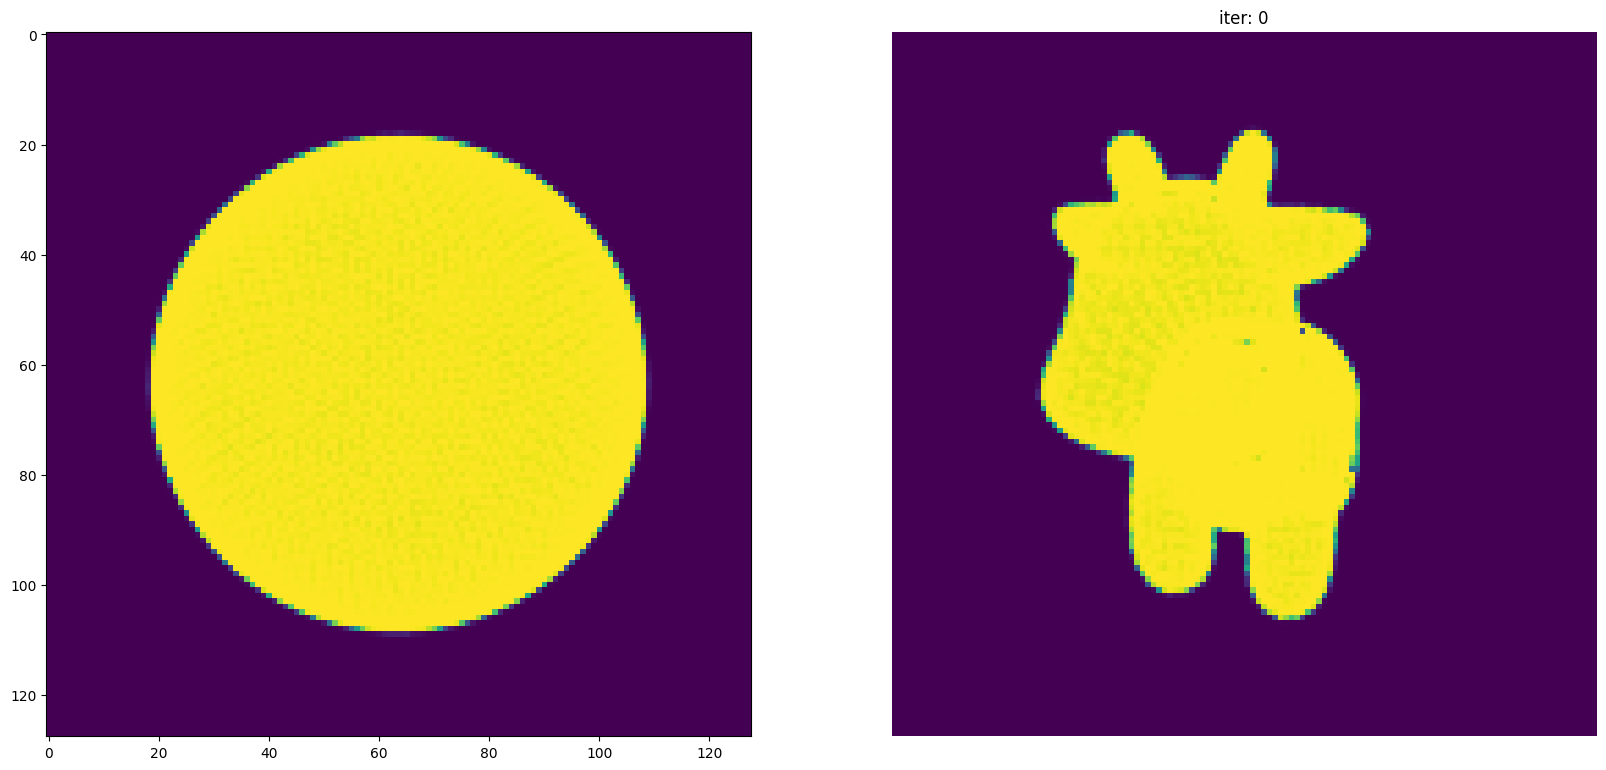

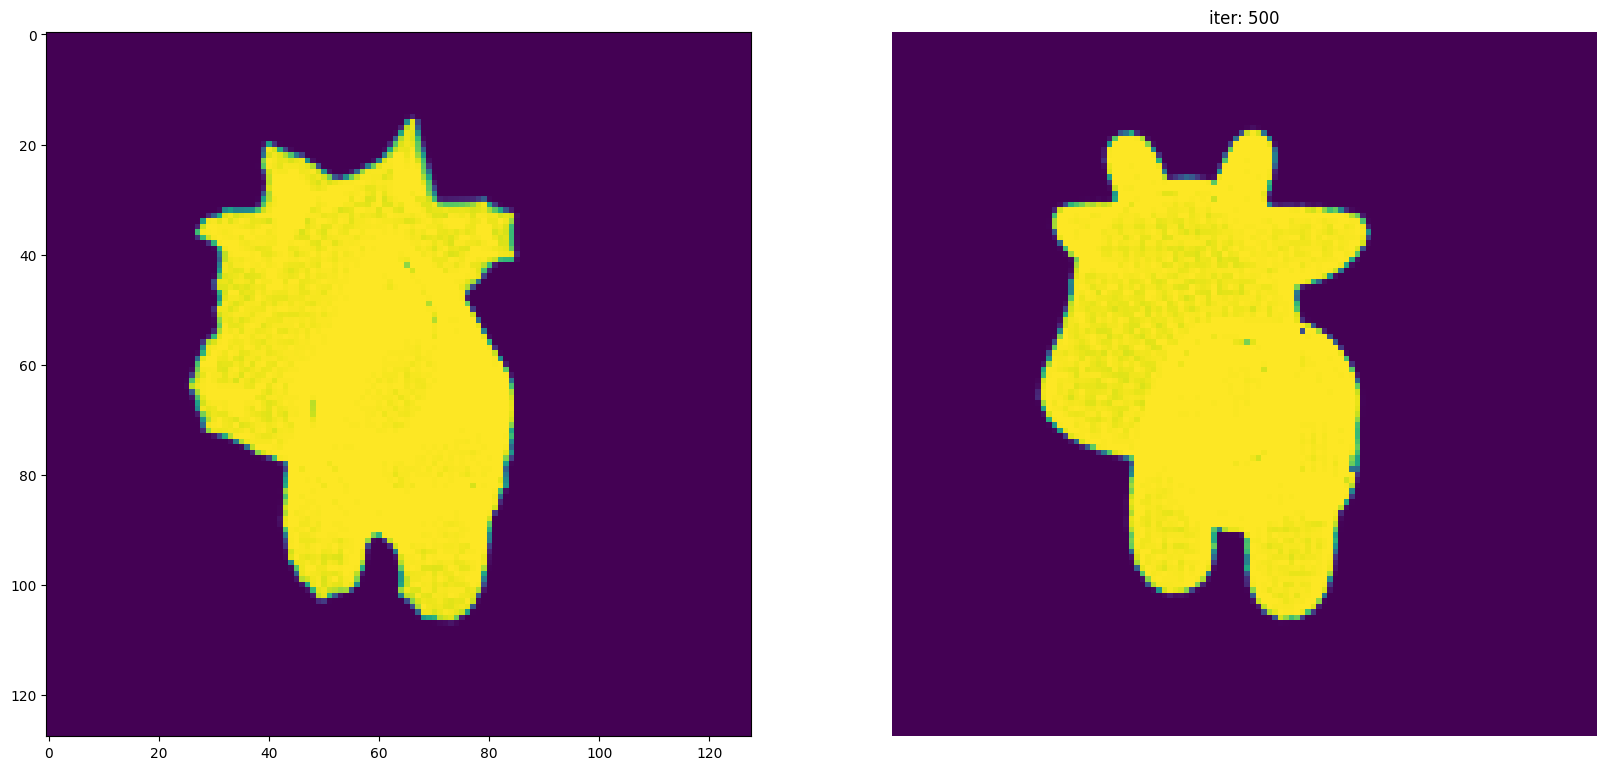

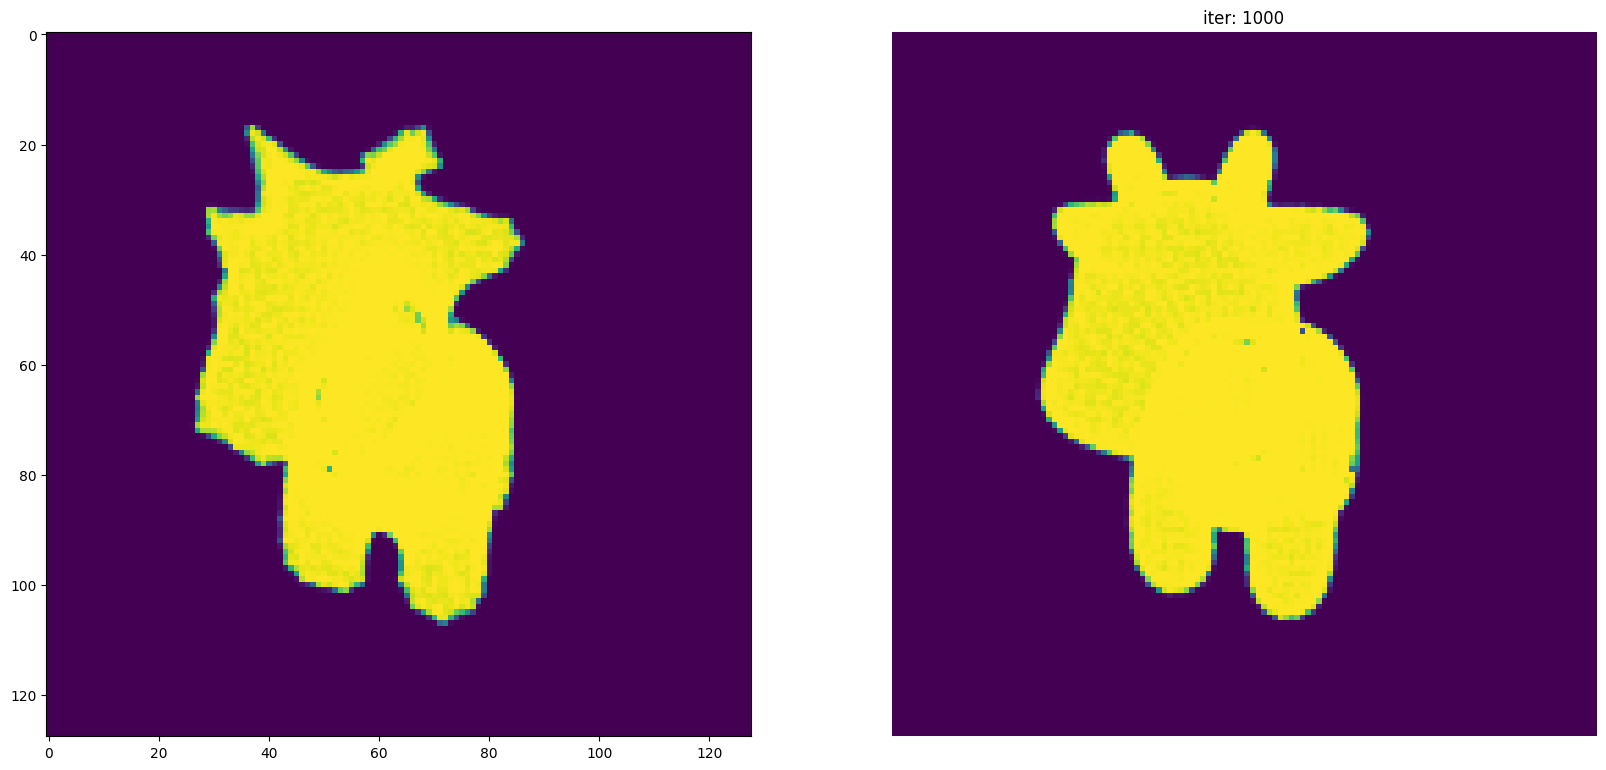

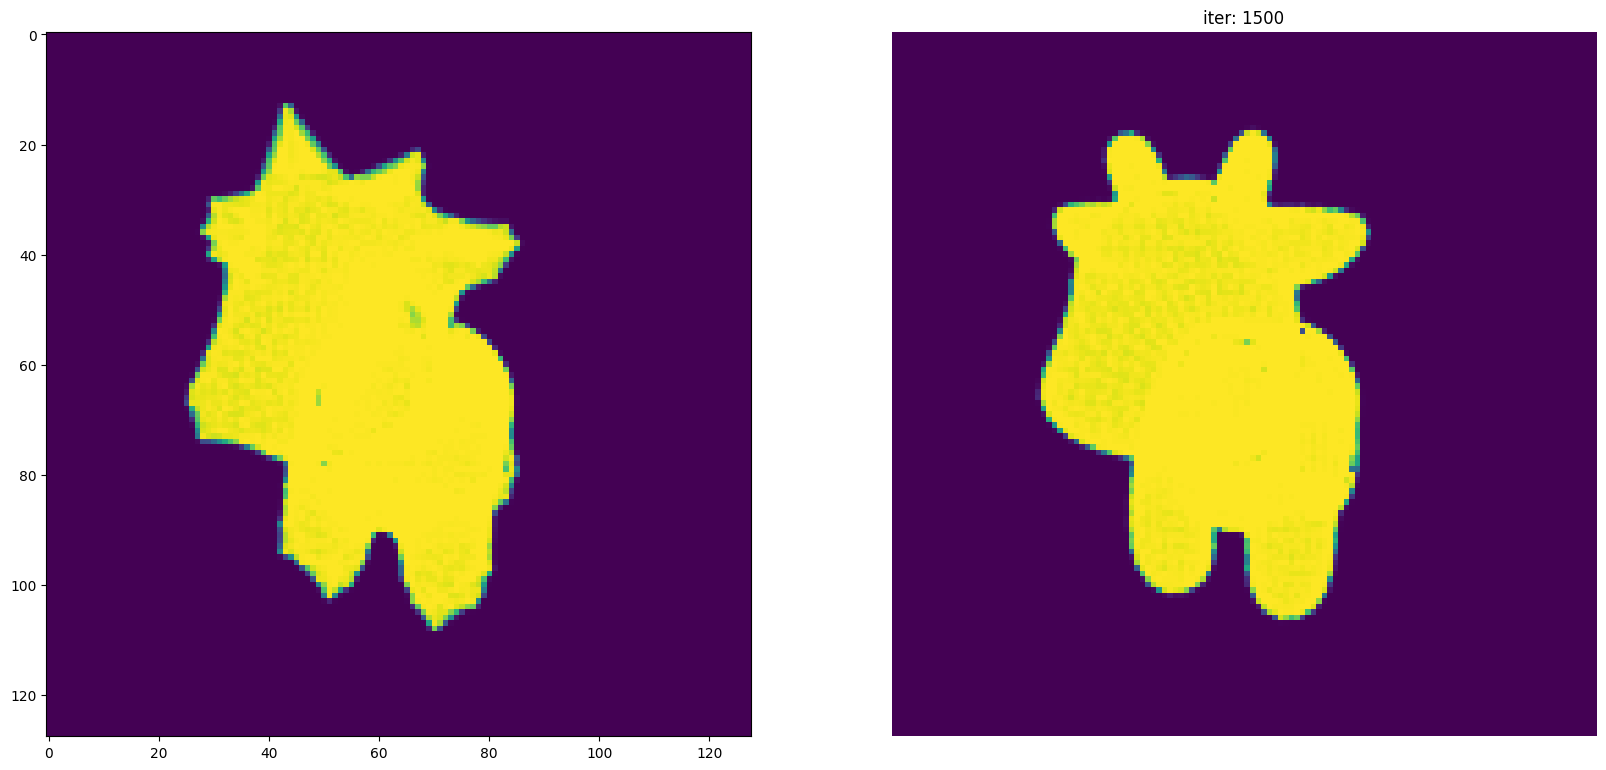

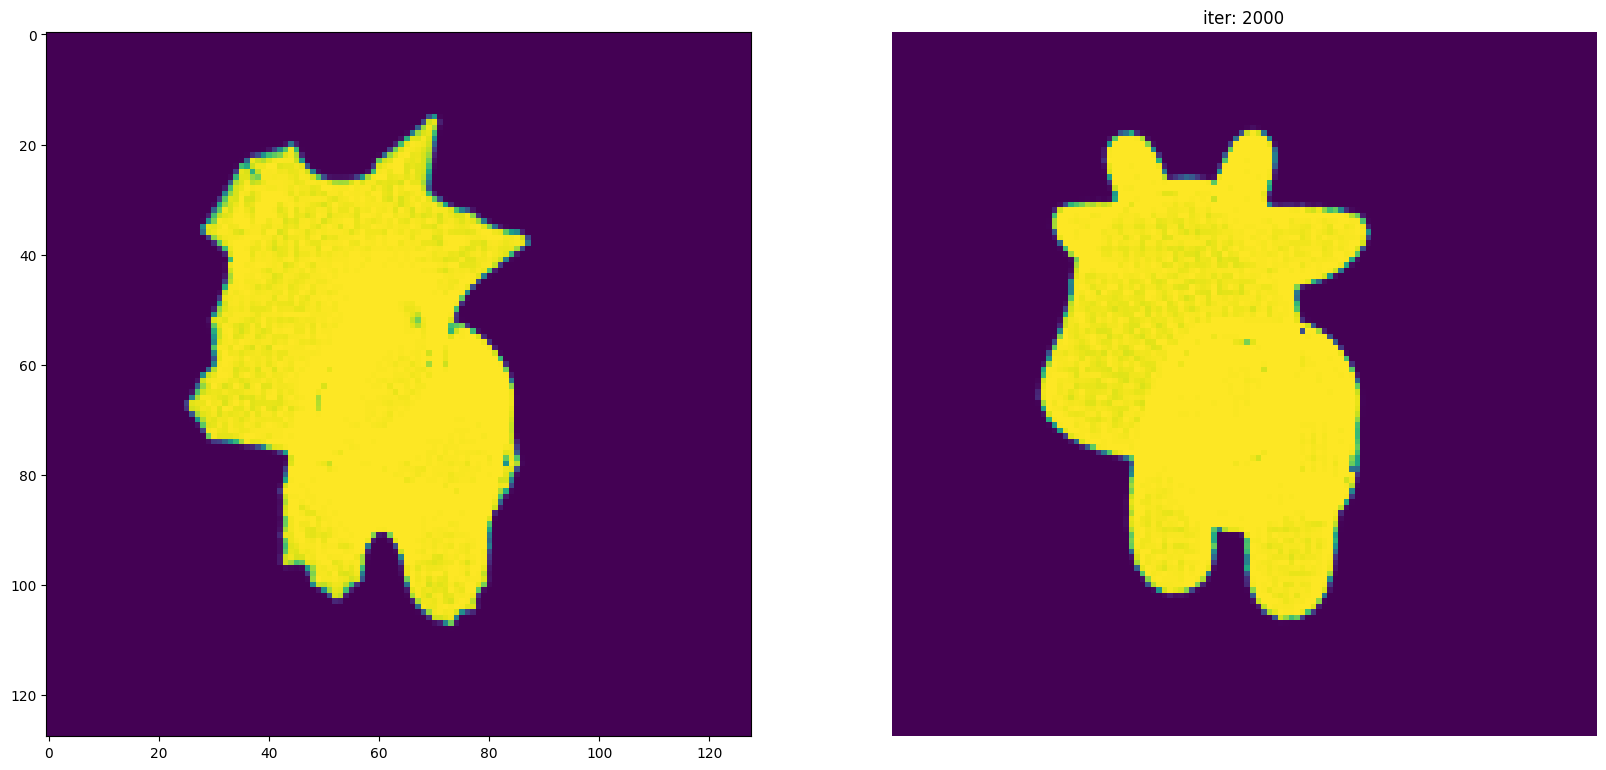

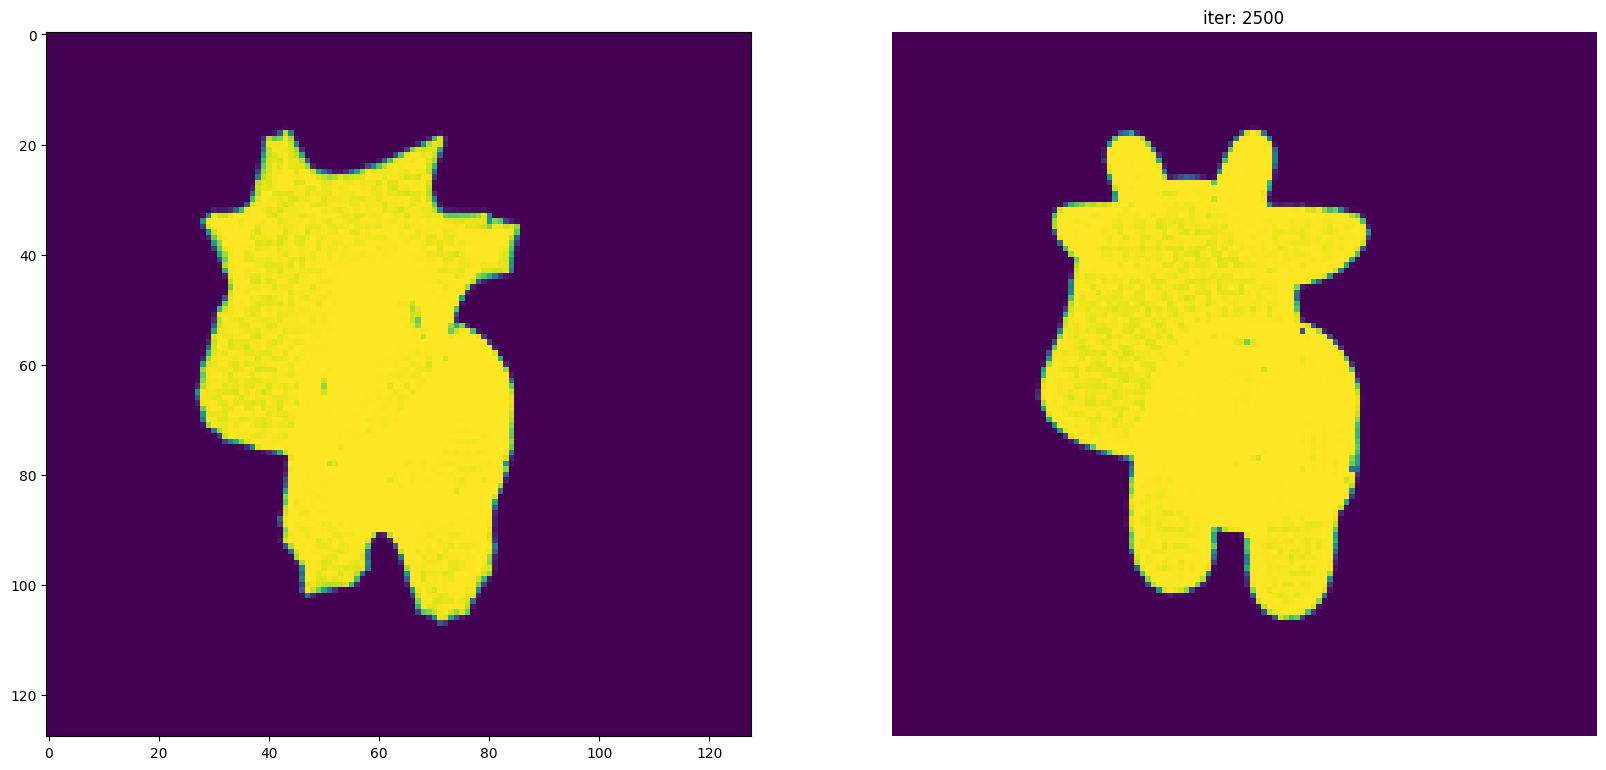

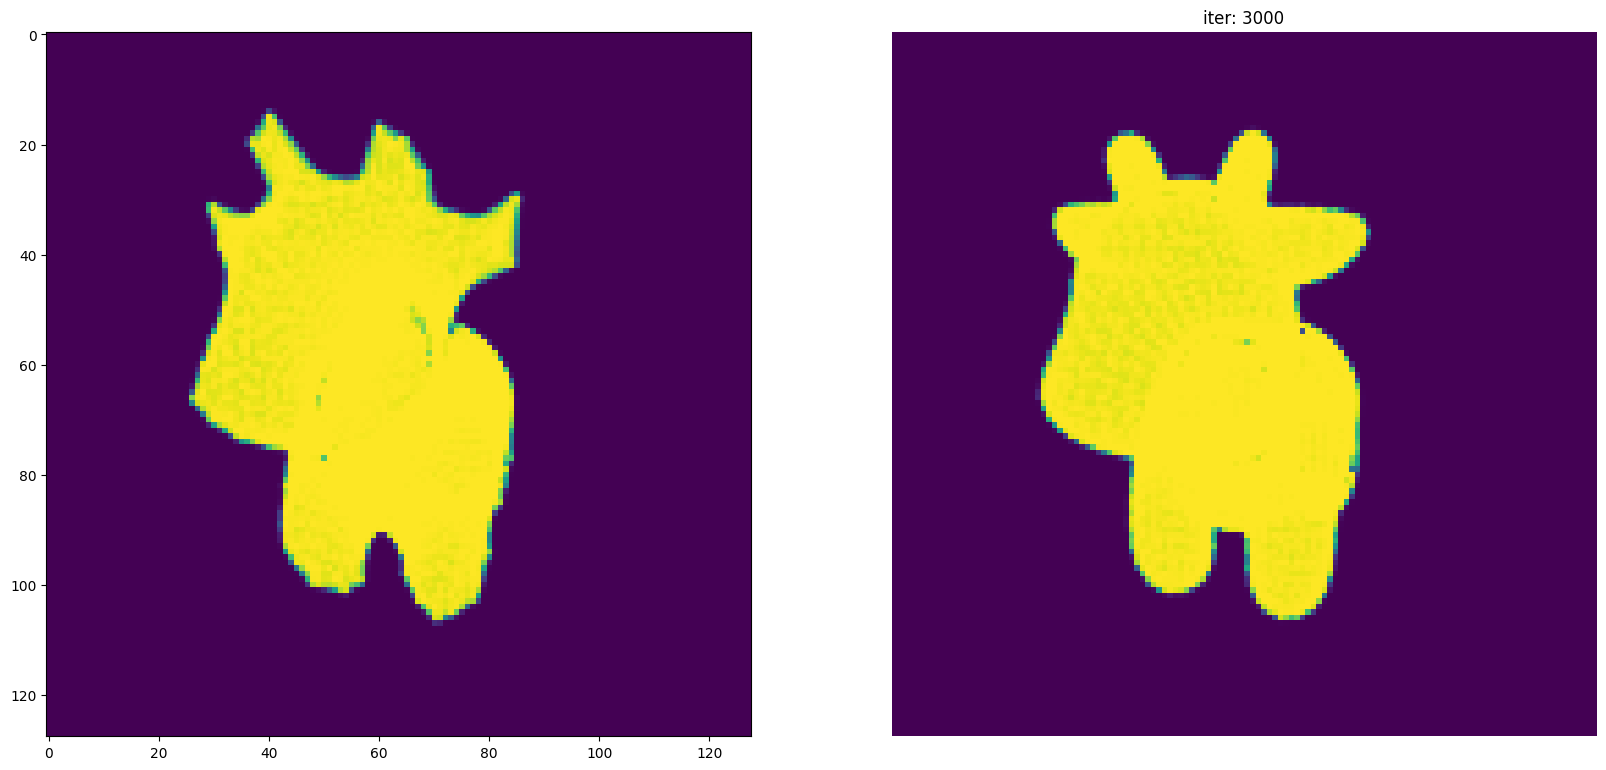

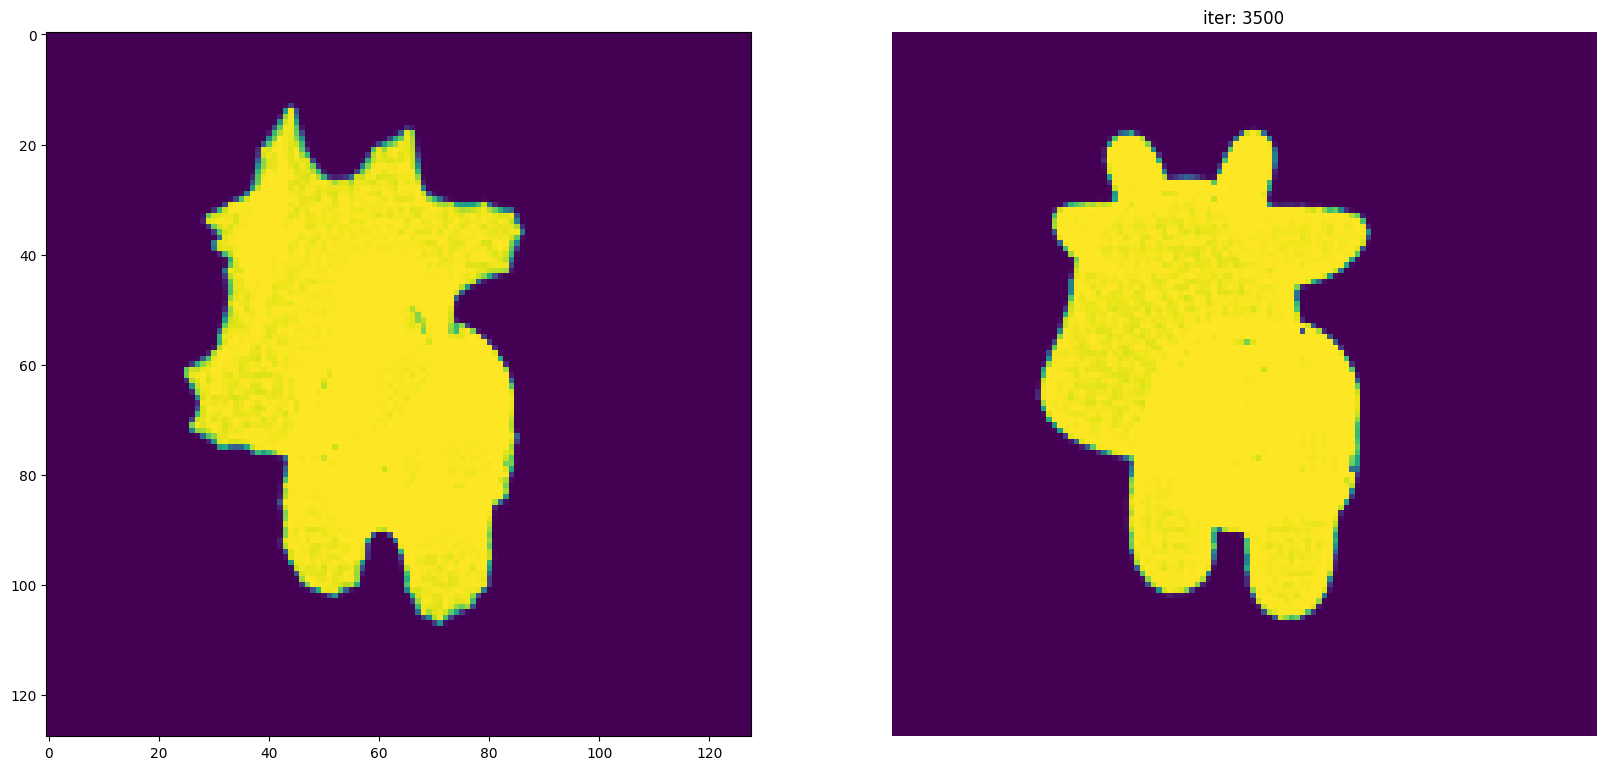

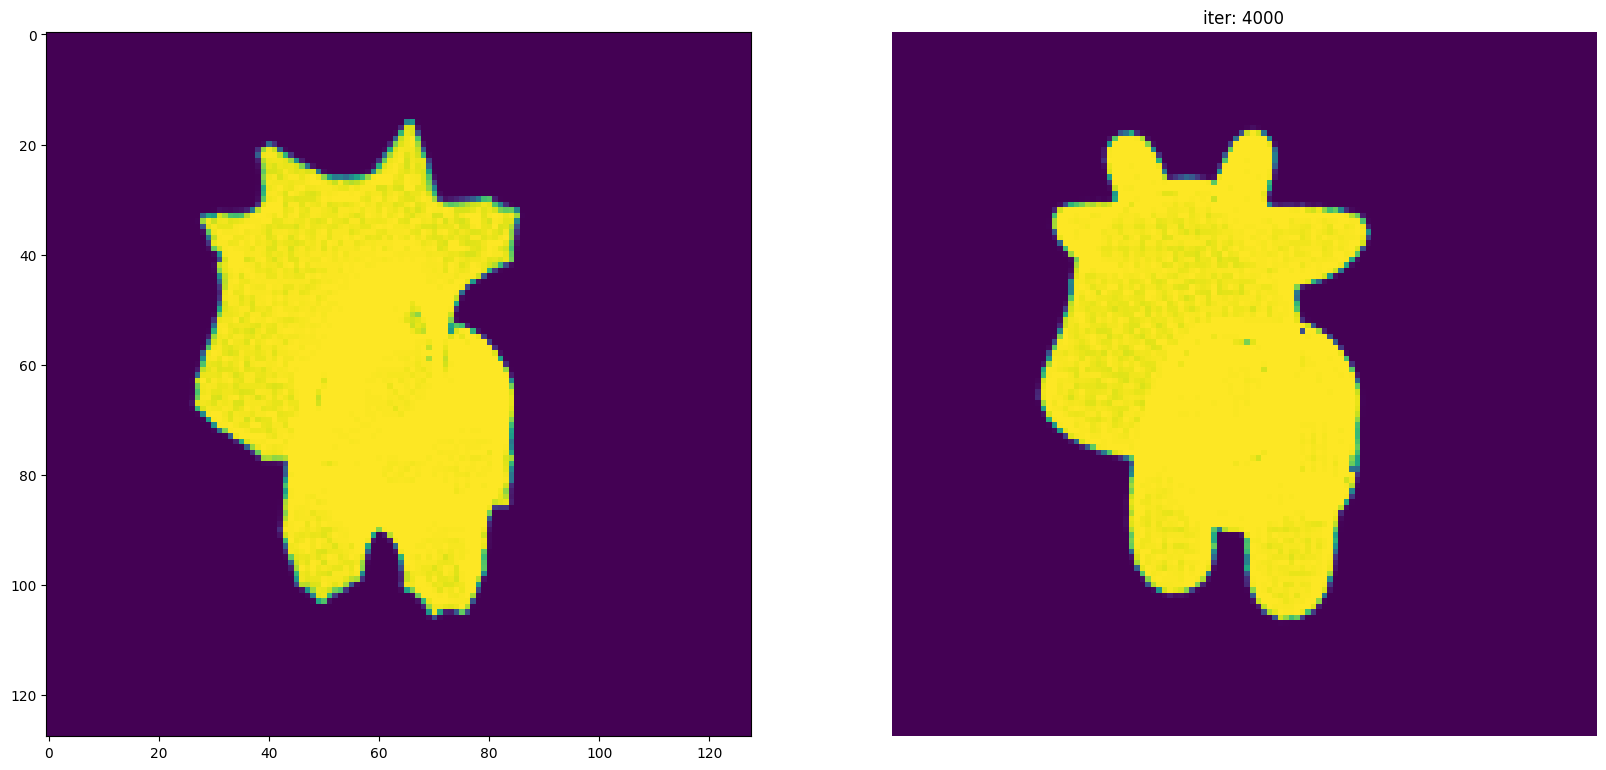

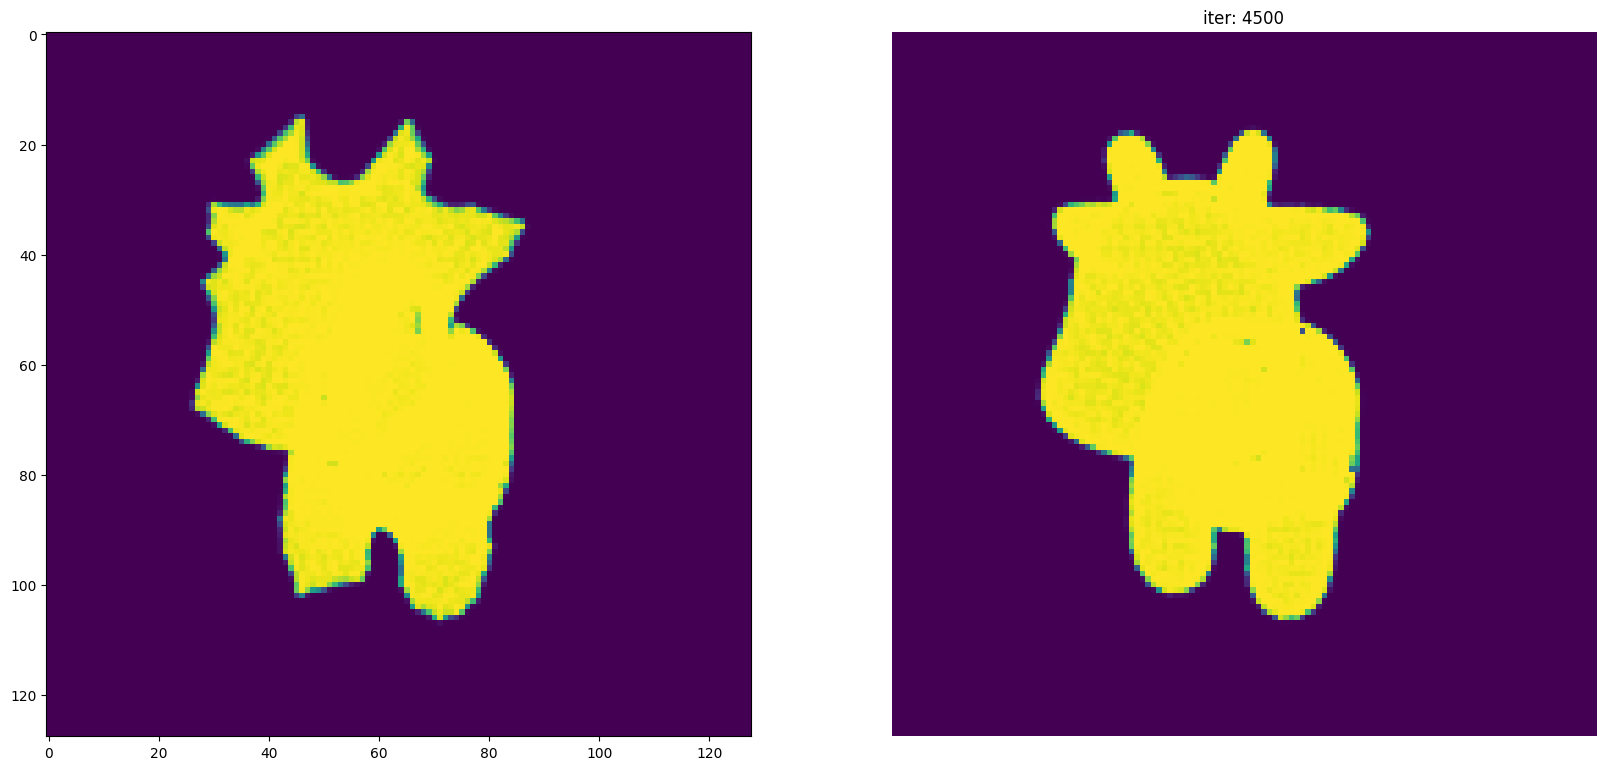

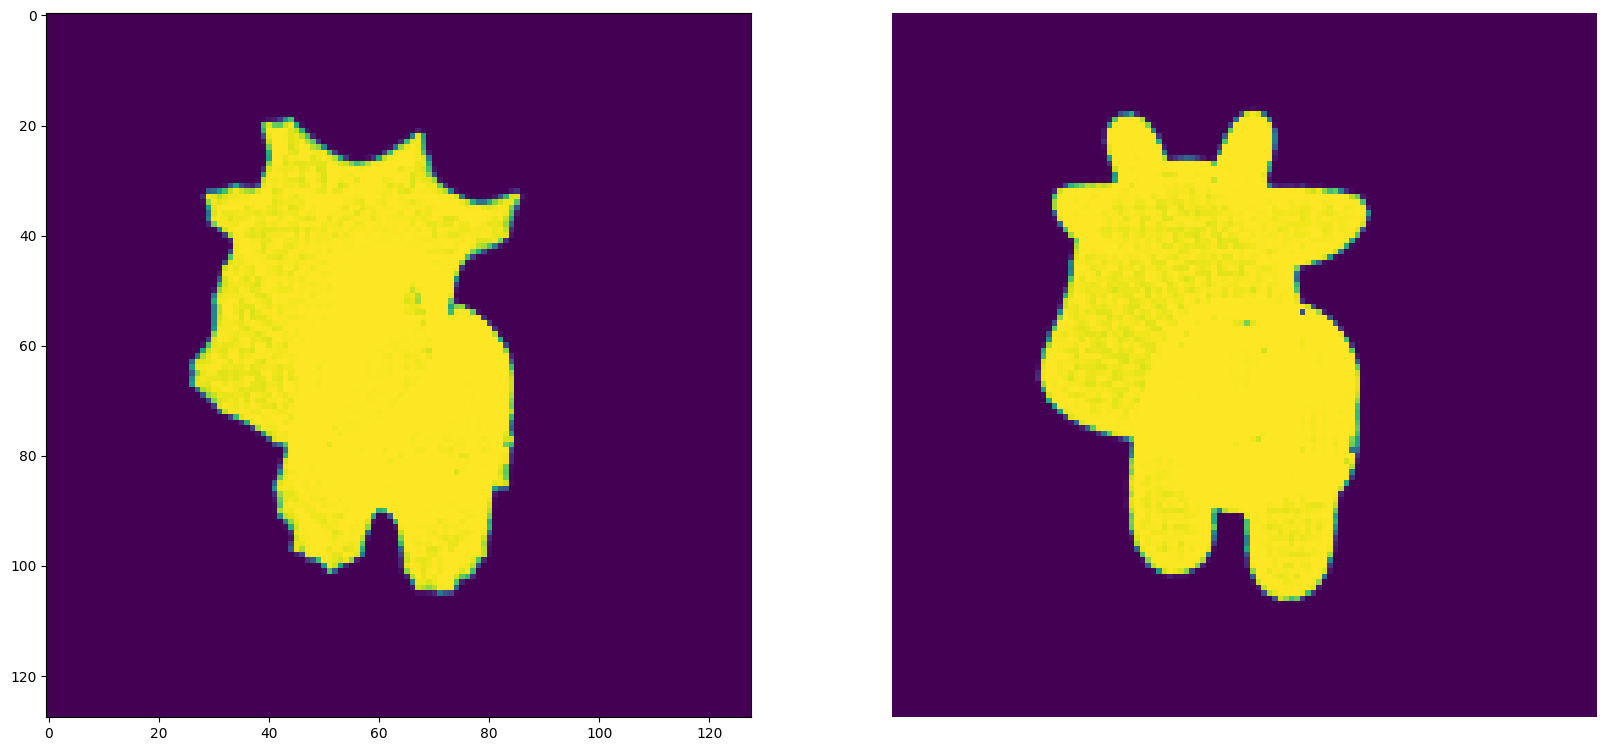

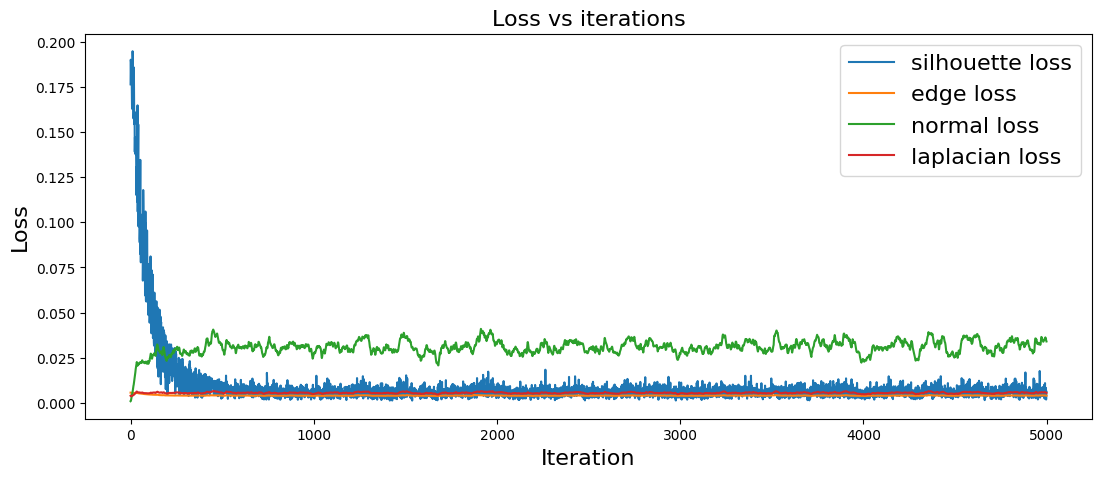

In [28]:
new_src_mesh_one_view = approximate_object_based_on_view_points(num_views_per_iteration, Niter, plot_period, optimizer, losses, deform_verts, src_mesh)

visualize_prediction(new_src_mesh_one_view, silhouette=True, target_image=target_silhouette[1])
plot_losses(losses)

In [29]:
#Plotando os objetos lado a lado
show_plotly_side_by_side(new_src_mesh_one_view, "Predicted", mesh, "Source")

3.3 Compare the target and source meshes sizes (number of vertices and faces). Are they close? Does the final result improve if you start from a source mesh with more vertices?

**Considerations**: Considering that the source mesh (sphere) was generated with 5120 faces and 2562 vertices, the number of faces and vertices is close to that of the target mesh (5856 faces and 2930 vertices). It is likely that the result would be smoother if the source mesh had a similar quantity of faces and vertices as the target mesh.

In [30]:
print("---- Initial Sphere (src_mesh) ----")
print(f"\tNumber of faces: {len(src_mesh.faces_list()[0])}\n\tNumber of vertexes: {len(src_mesh.verts_list()[0])}")

---- Initial Sphere (src_mesh) ----
	Number of faces: 5120
	Number of vertexes: 2562


In [31]:
print("---- Initial Object (mesh) ----")
print(f"\tNumber of faces: {len(mesh.faces_list()[0])}\n\tNumber of vertexes: {len(mesh.verts_list()[0])}")

---- Initial Object () ----
	Number of faces: 5856
	Number of vertexes: 2930


In [32]:
#O objeto predito tem o mesmo numero de faces e vertices do objeto source, uma vez que ele foi modificado para aproximar-se do target.
print("---- Predicted Object (new_src_mesh) ----")
print(f"\tNumber of faces: {len(new_src_mesh.faces_list()[0])}\n\tNumber of vertexes: {len(new_src_mesh.verts_list()[0])}")

---- Predicted Object (new_src_mesh) ----
	Number of faces: 5120
	Number of vertexes: 2562


## 4. Mesh and texture prediction via textured rendering
We can predict both the mesh and its texture if we add an additional loss based on the comparing a predicted rendered RGB image to the target image. As before, we start with a sphere mesh.  We learn both translational offsets and RGB texture colors for each vertex in the sphere mesh.  Since our loss is based on rendered RGB pixel values instead of just the silhouette, we use a **SoftPhongShader** instead of a **SoftSilhouetteShader**.

In [36]:
# Rasterization settings for differentiable rendering, where the blur_radius
# initialization is based on Liu et al, 'Soft Rasterizer: A Differentiable
# Renderer for Image-based 3D Reasoning', ICCV 2019
sigma = 1e-4
raster_settings_soft = RasterizationSettings(
    perspective_correct=False,
    image_size=128,
    blur_radius=np.log(1. / 1e-4 - 1.)*sigma,
    faces_per_pixel=50,
)

# Differentiable soft renderer using per vertex RGB colors for texture
renderer_textured = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=camera,
        raster_settings=raster_settings_soft
    ),
    shader=SoftPhongShader(device=device,
        cameras=camera,
        lights=lights)
)

We initialize settings, losses, and the optimizer that will be used to iteratively fit our mesh to the target RGB images:

In [38]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 4
# Number of optimization steps
Niter = 4000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.001, "values": []},
          "laplacian": {"weight": 0.1, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

We write an optimization loop to iteratively refine our predicted mesh and its vertex colors from the sphere mesh into a mesh that matches the target images:

  0%|          | 0/4000 [00:00<?, ?it/s]

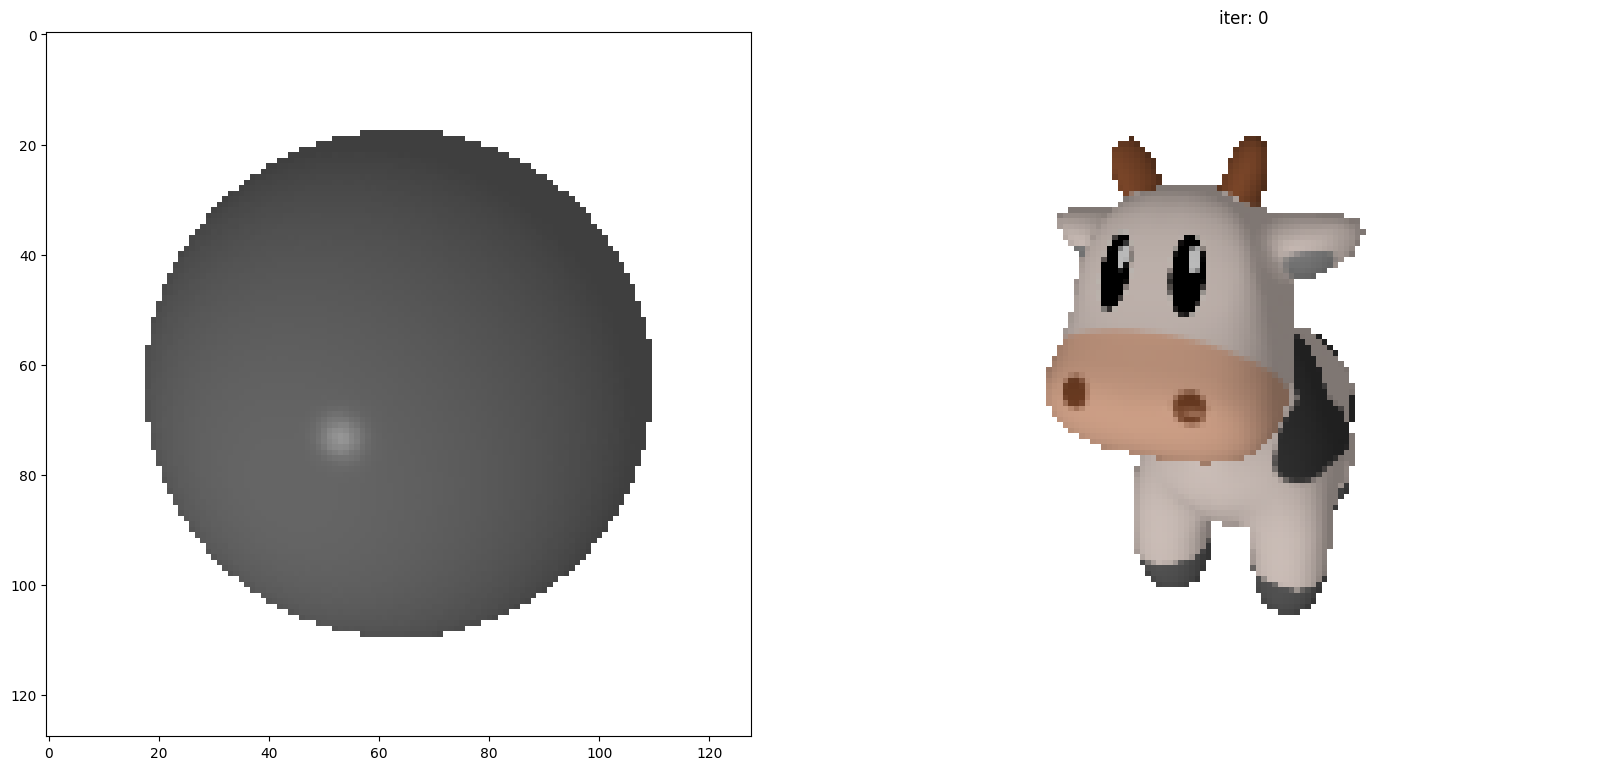

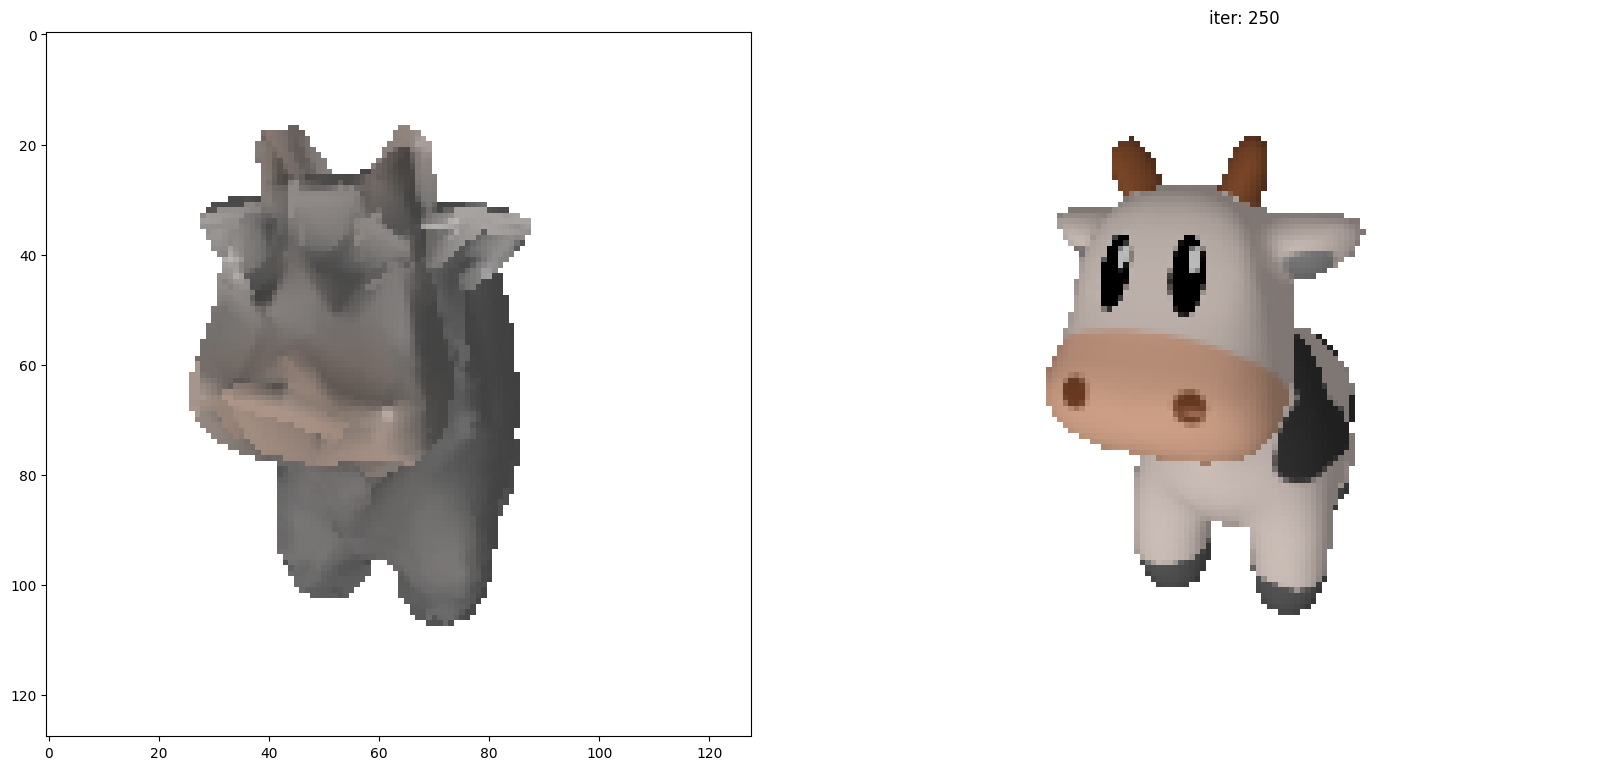

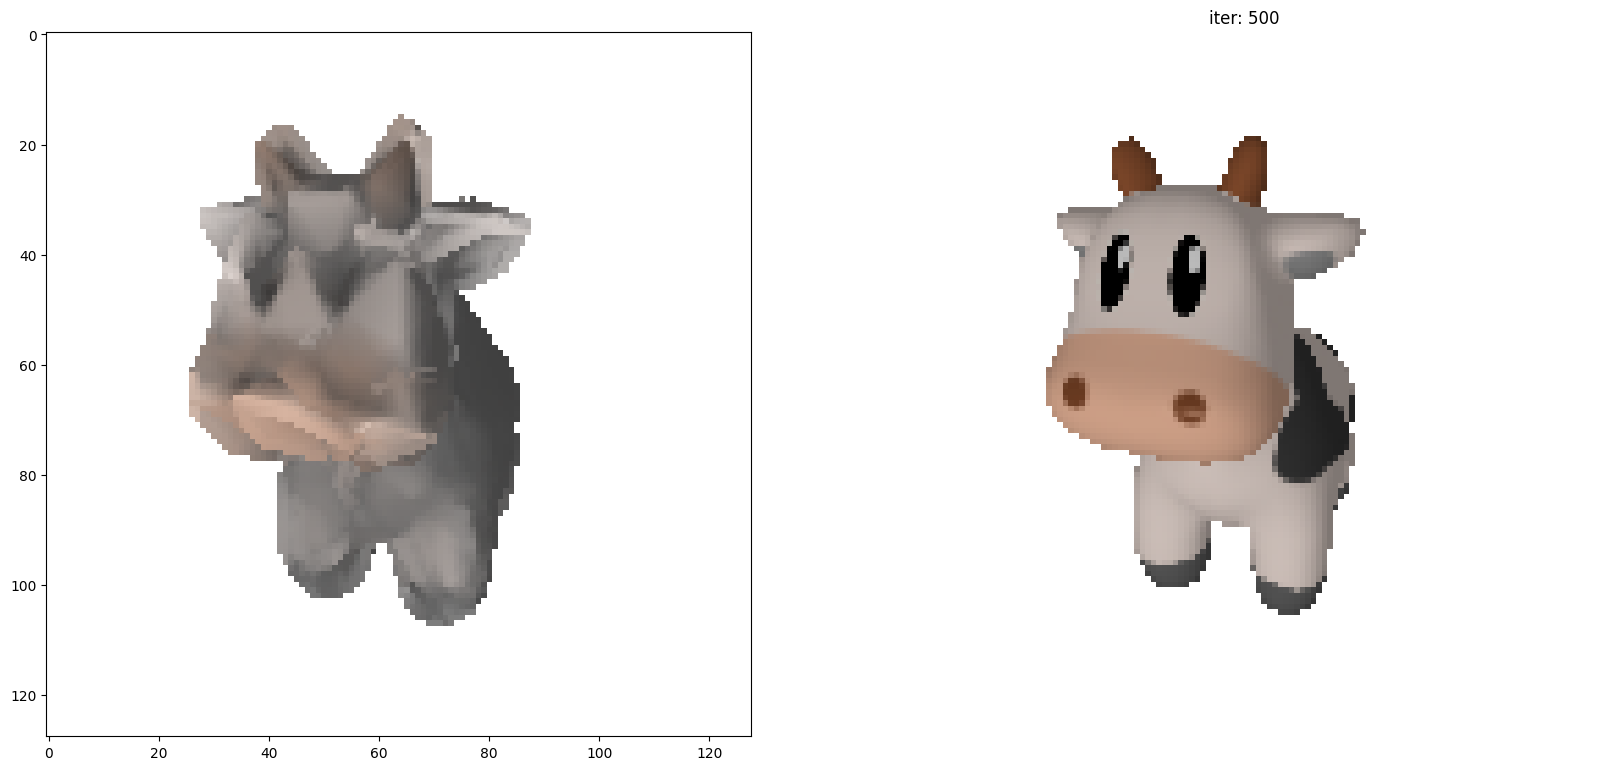

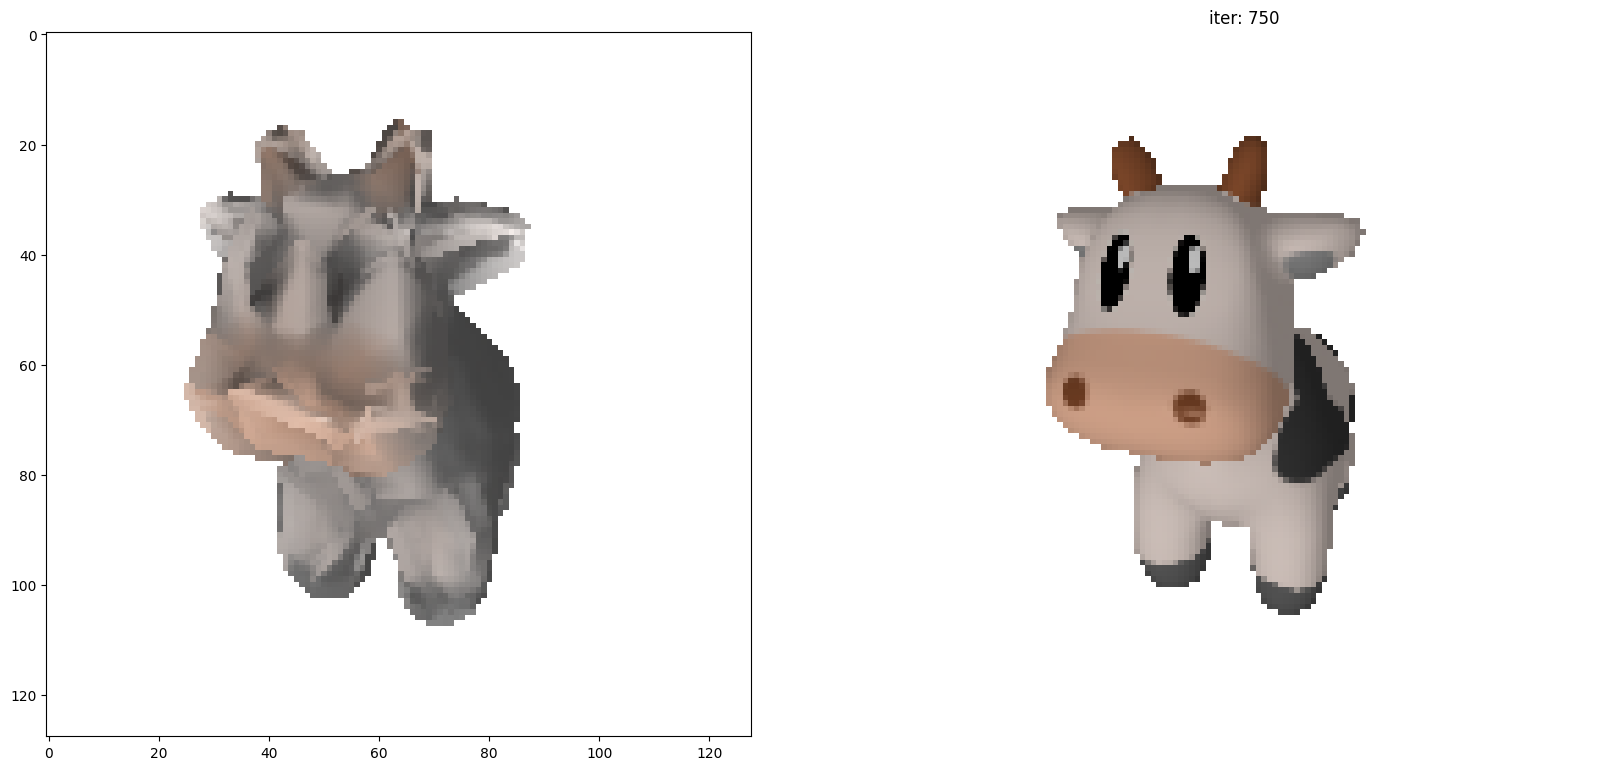

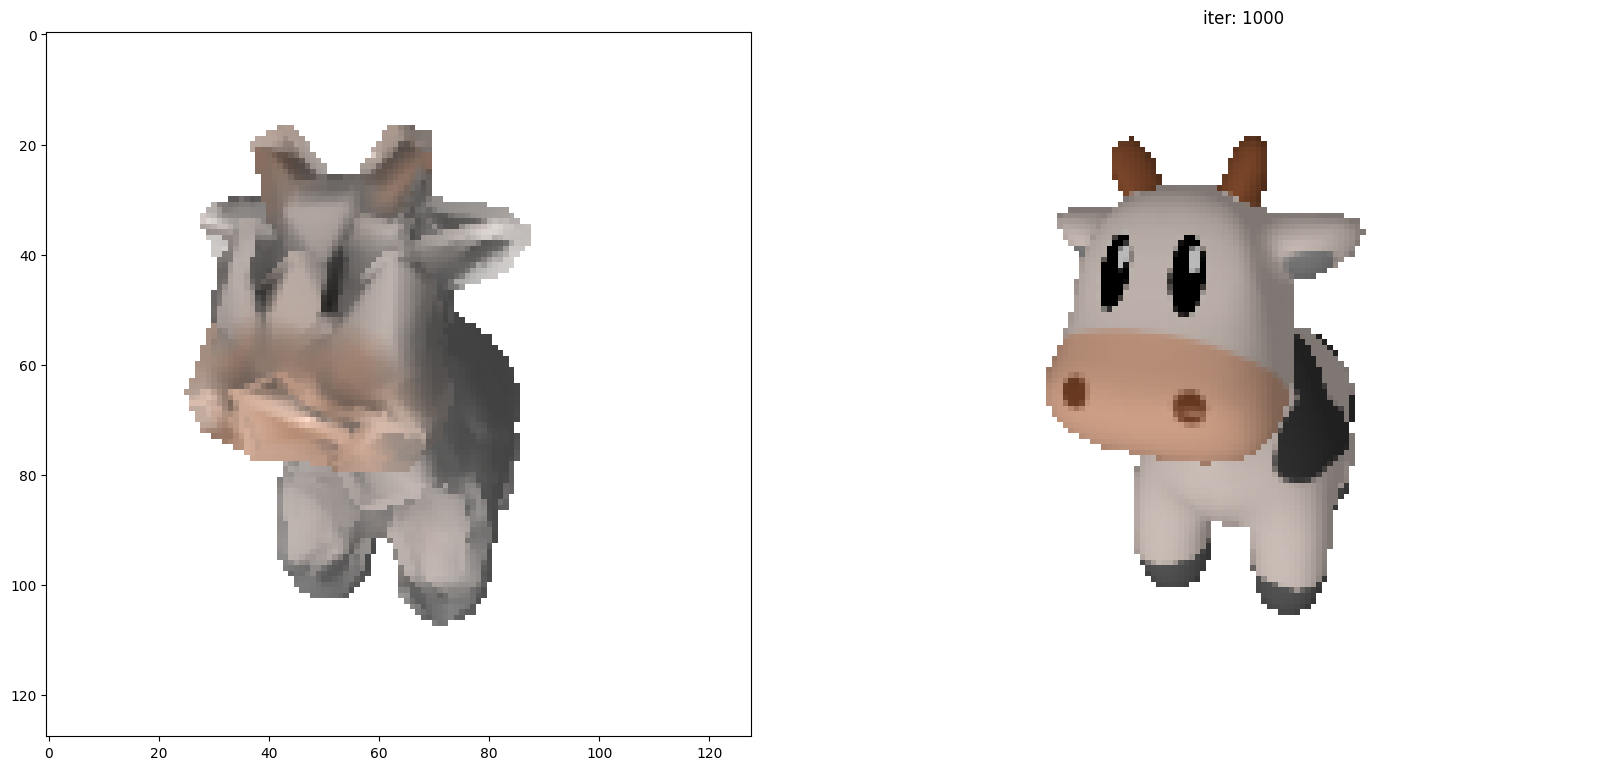

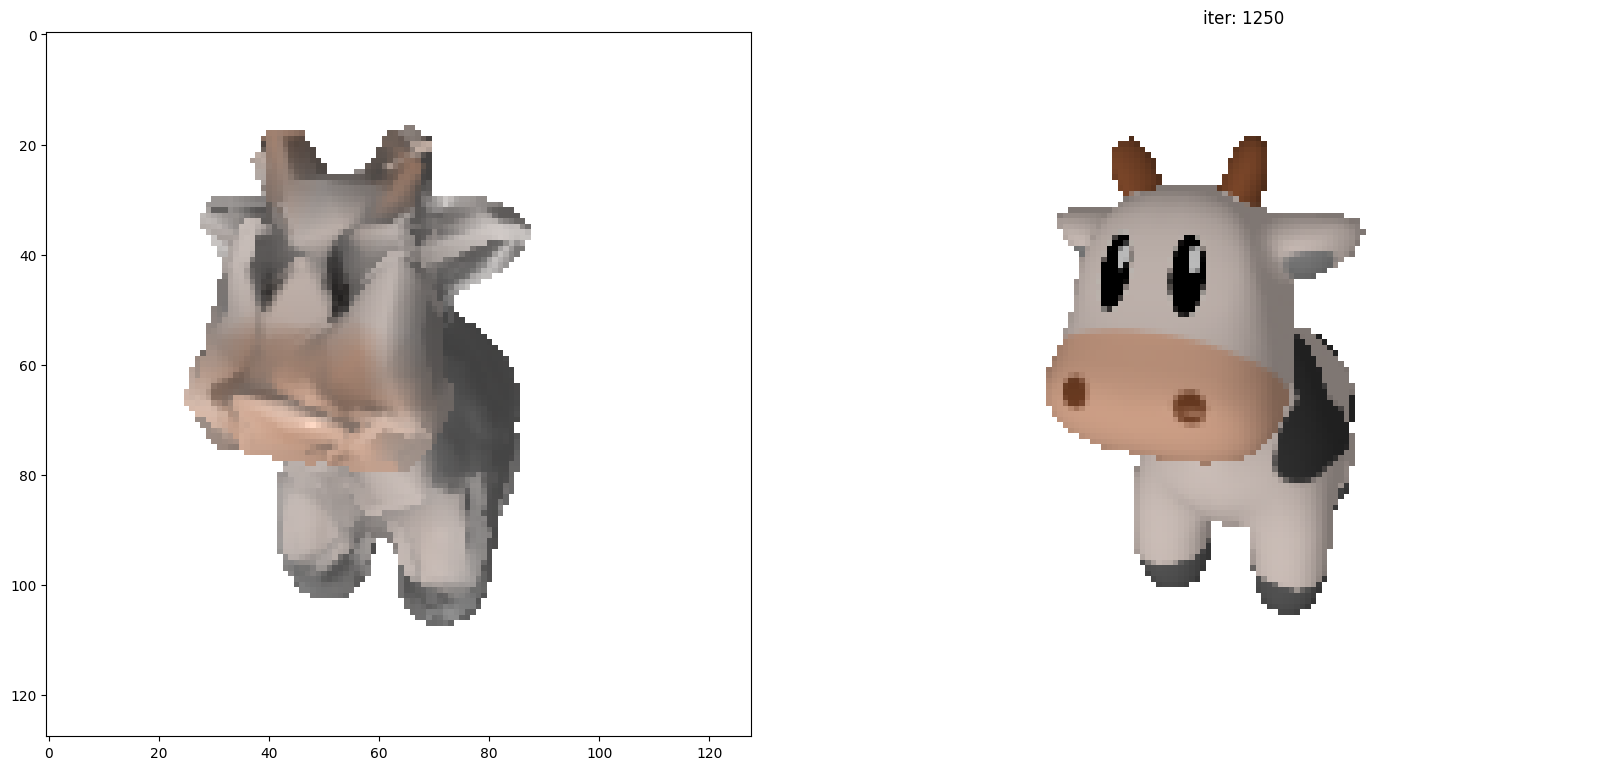

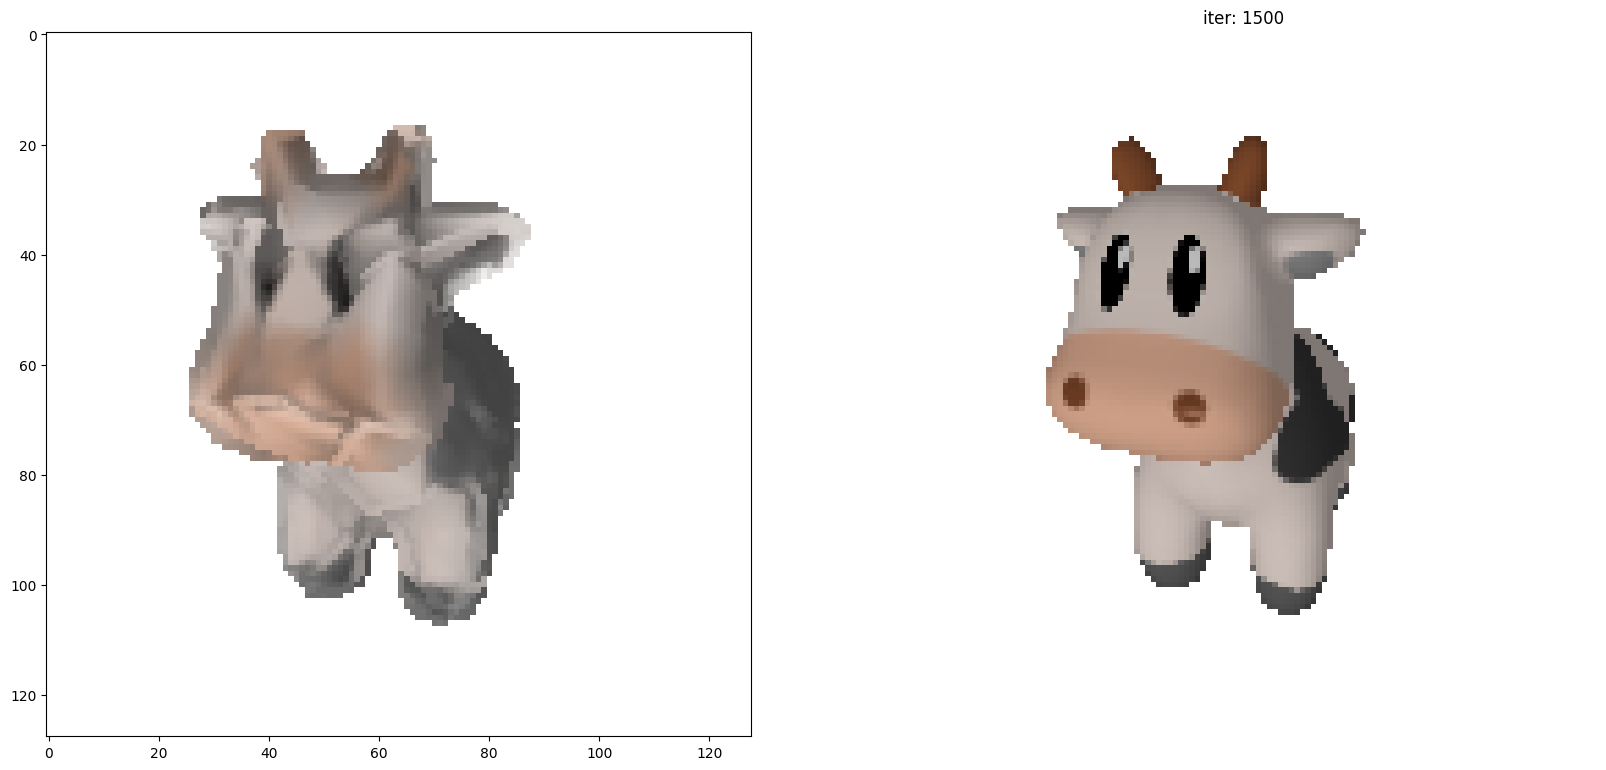

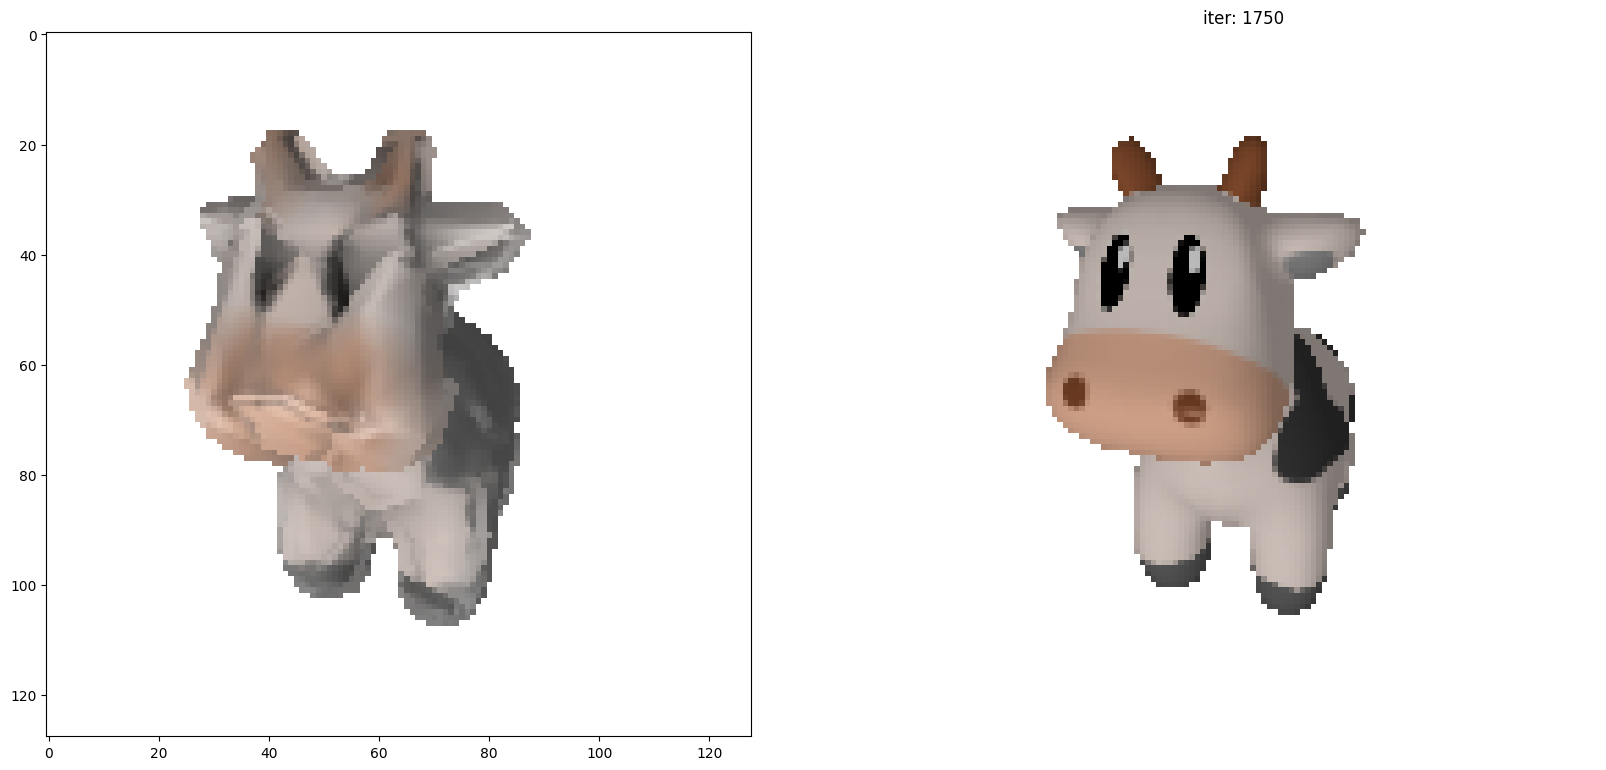

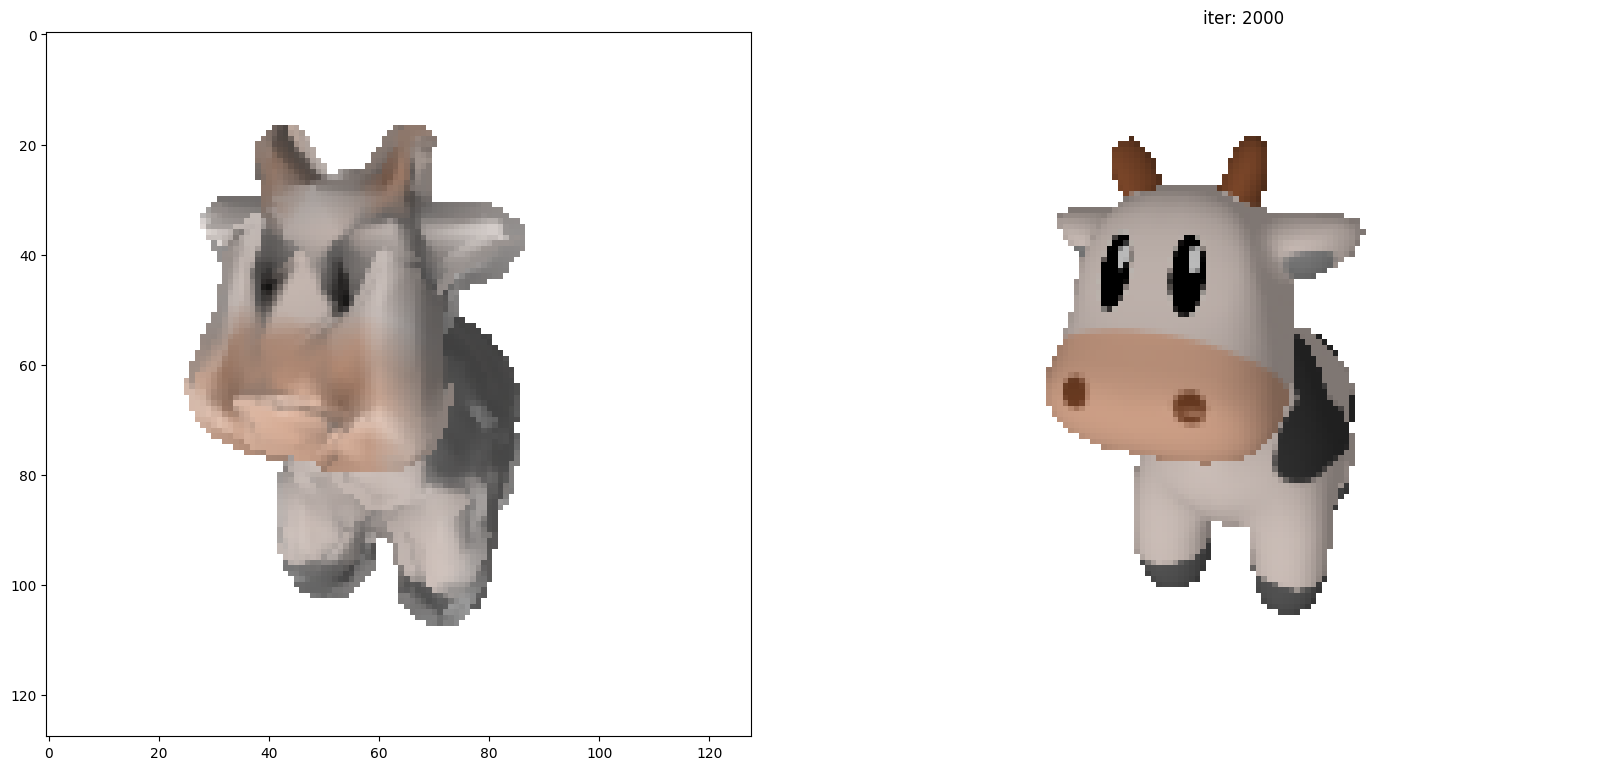

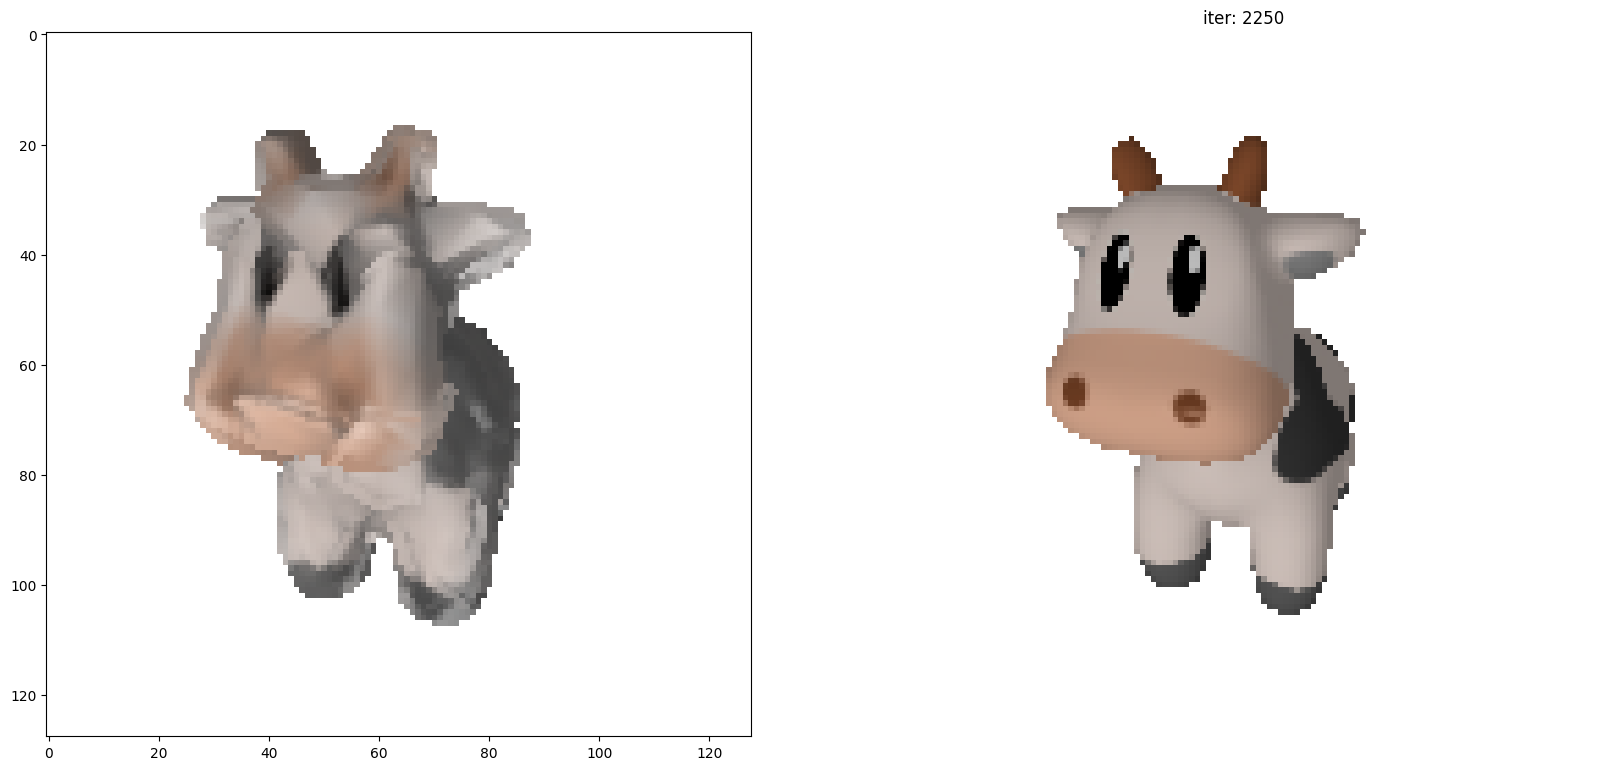

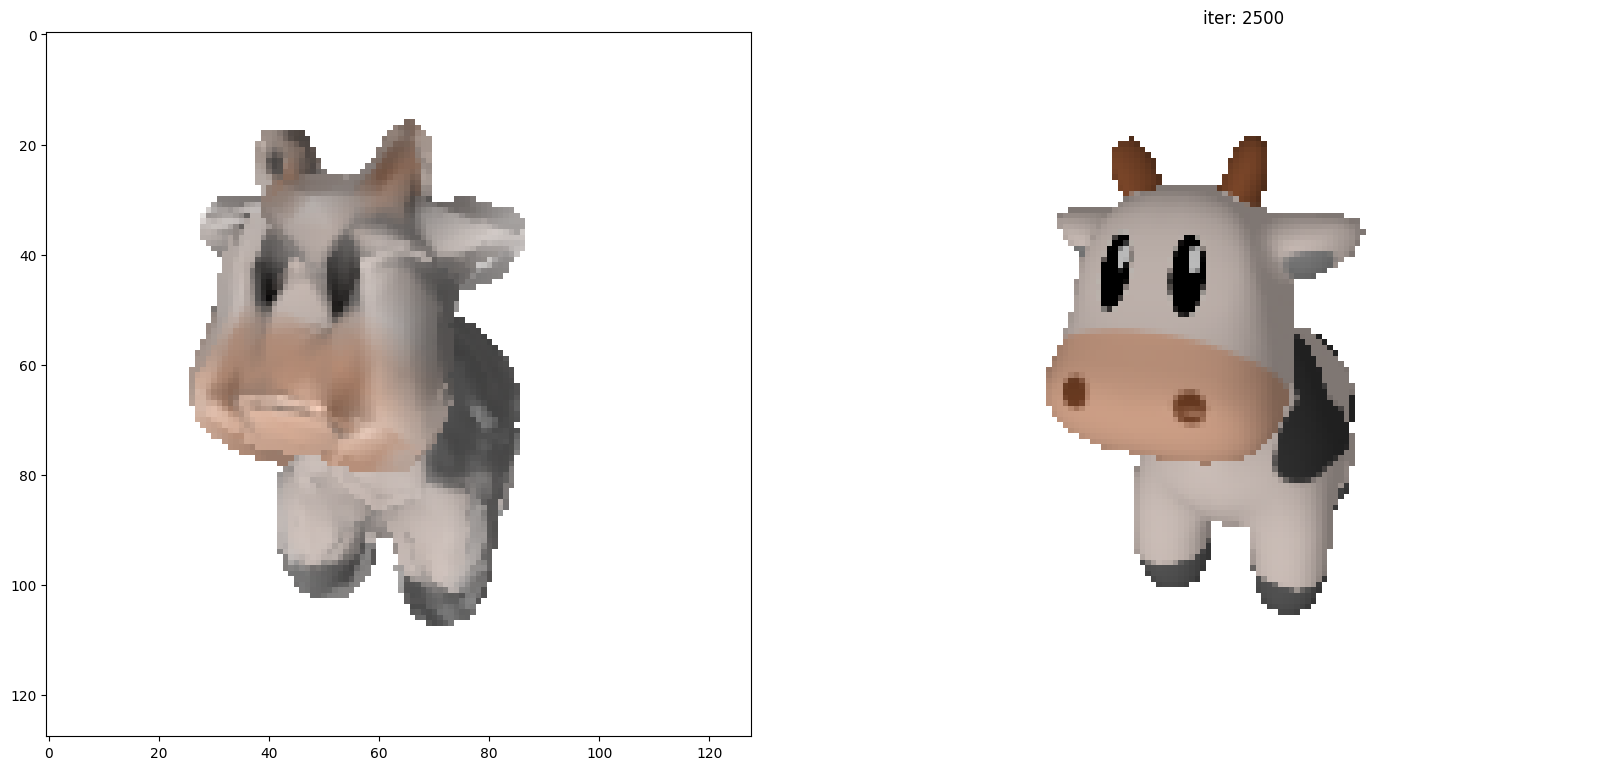

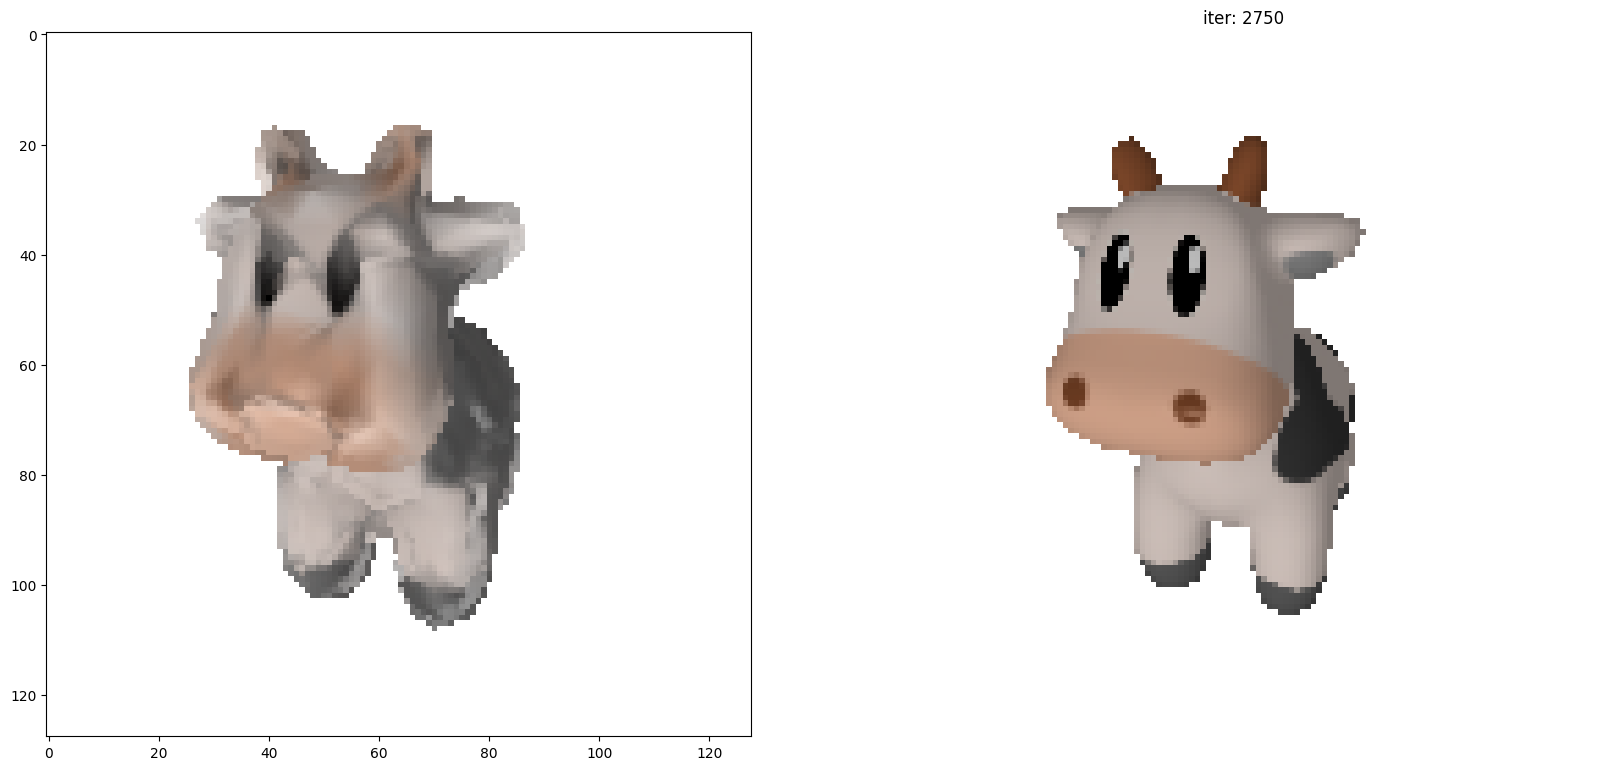

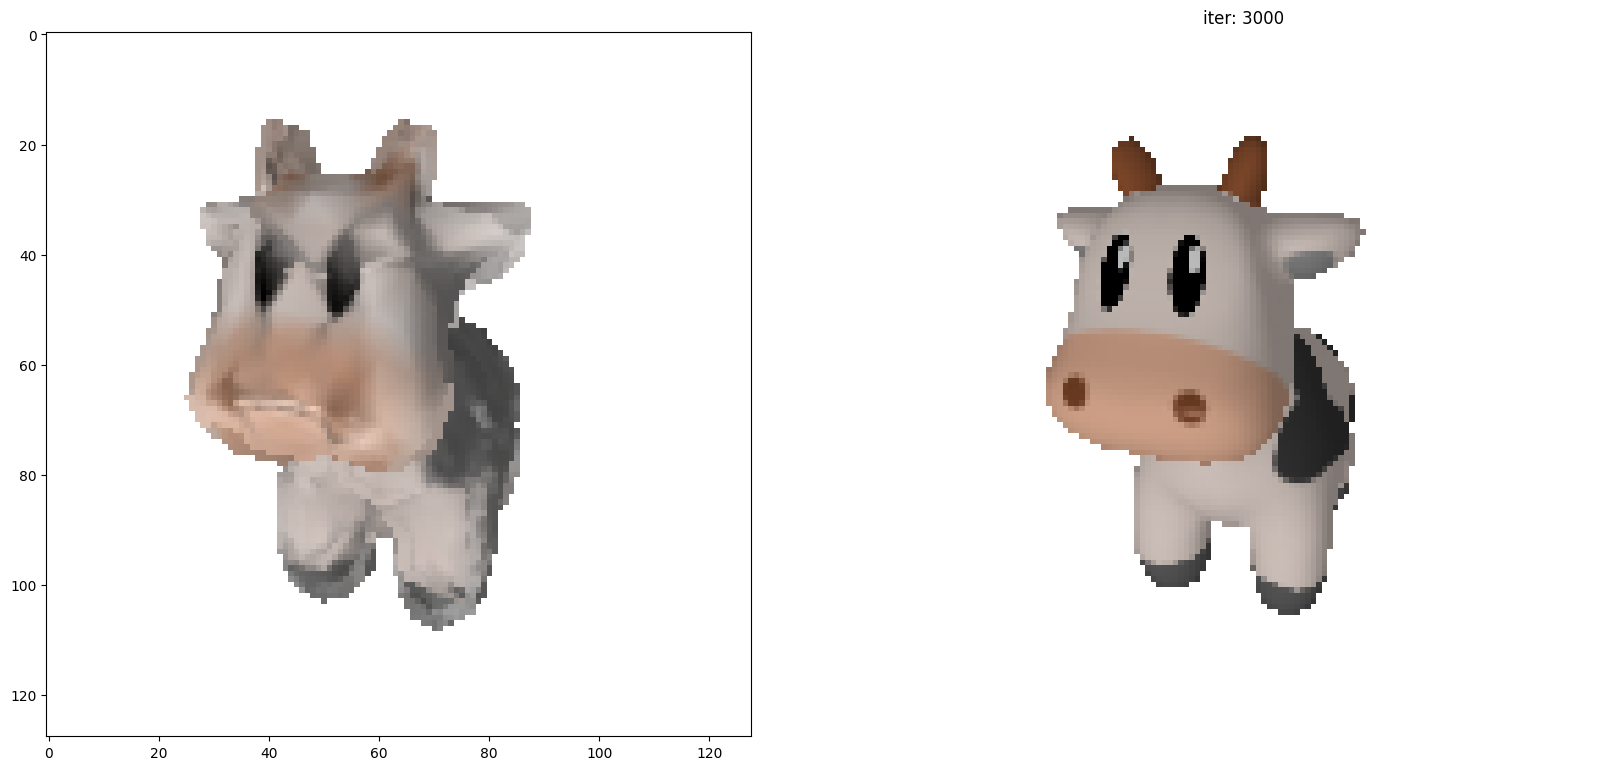

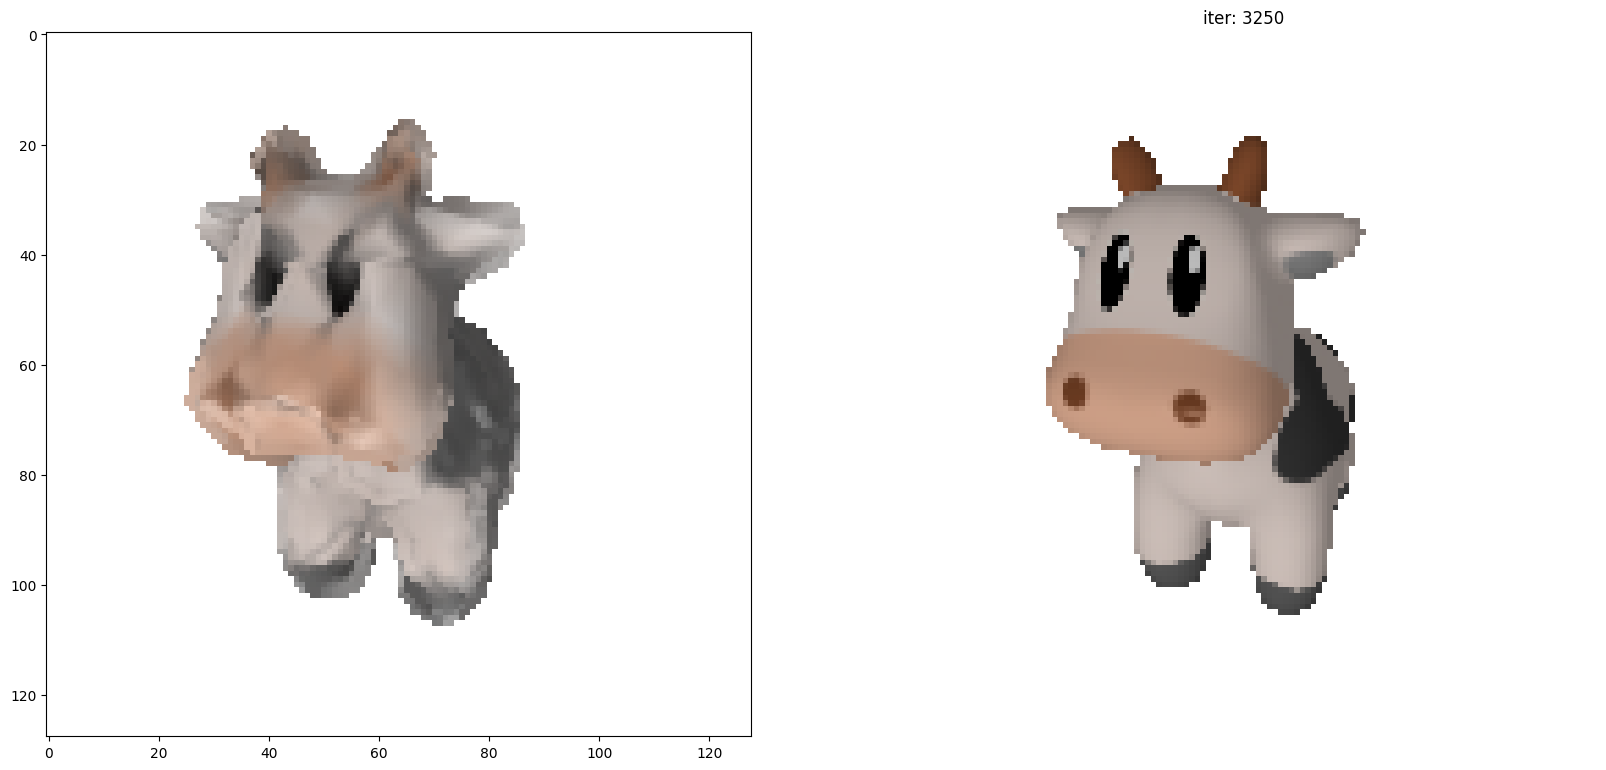

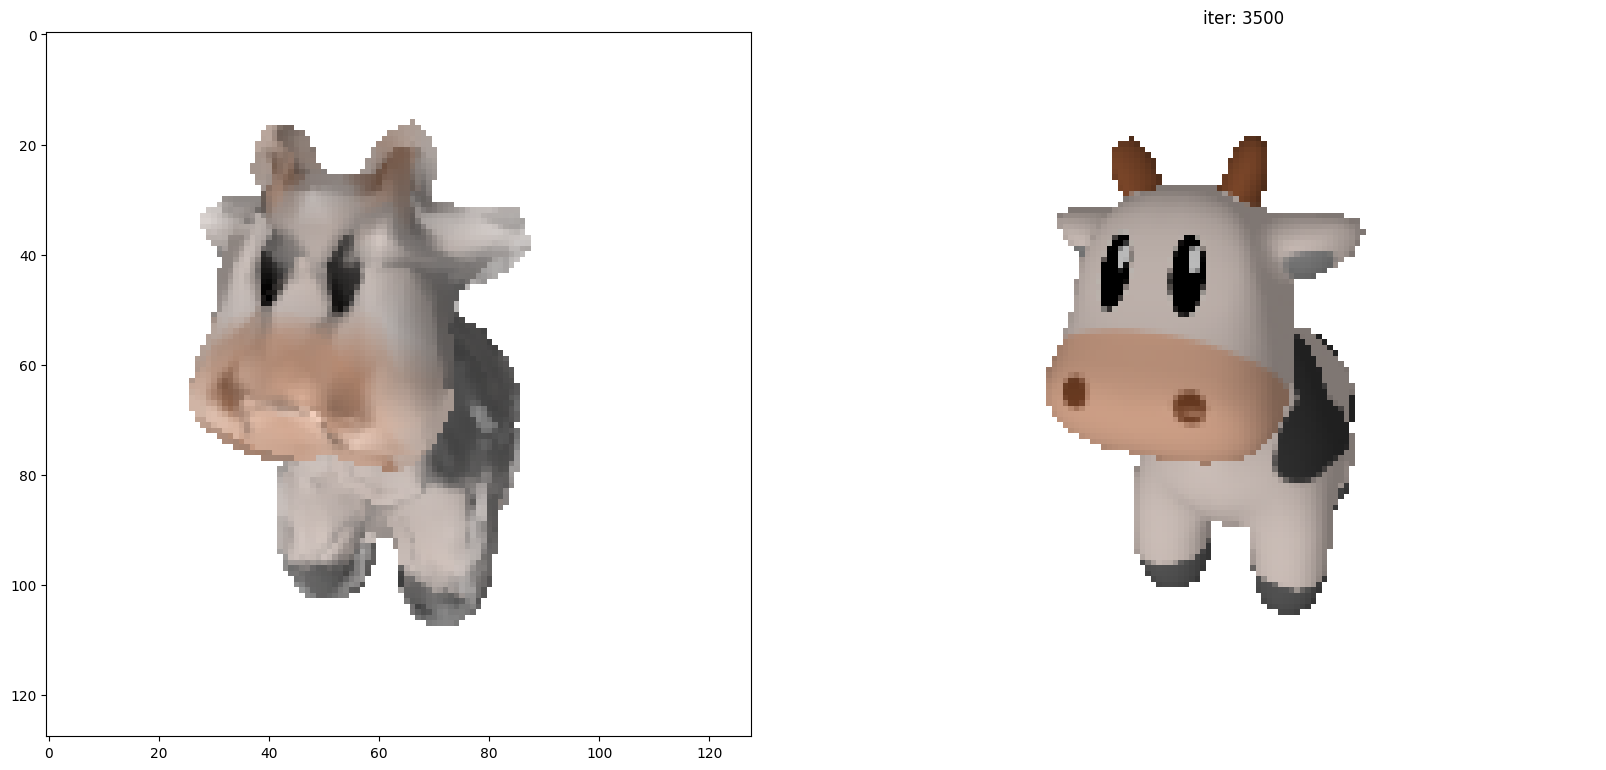

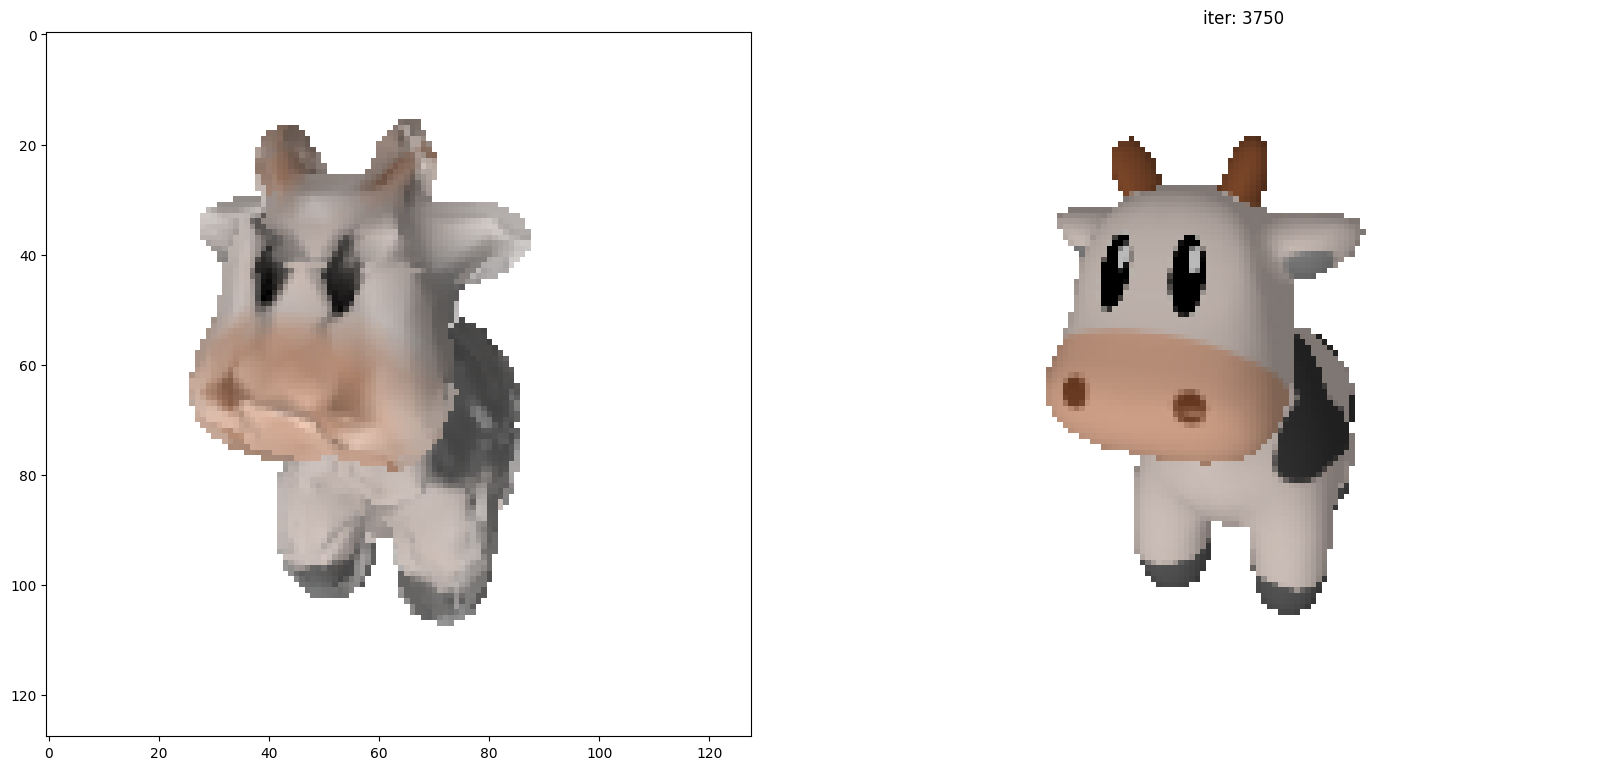

In [39]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Add per vertex colors to texture the mesh
    new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target
        # silhouette from our dataset
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        # Squared L2 distance between the predicted RGB image and the target
        # image from our dataset
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l.detach().cpu())

    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)

    # Optimization step
    sum_loss.backward()
    optimizer.step()


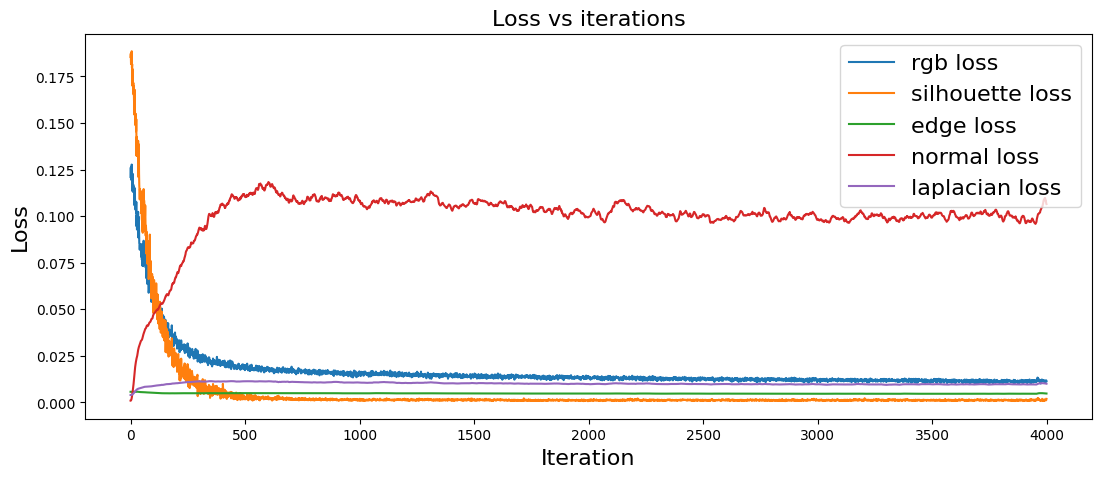

In [40]:
# default parameters
plot_losses(losses)

## Save the final predicted mesh

In [42]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model.obj')
save_obj(final_obj, final_verts, final_faces)

## Questions

4.1 Compare the target and source meshes and describe the result qualitatively.

**Considerations:** The result is not perfect; however, the shape approximation and the predicted RGB colors are similar to the original. There is room for improvement, and using NERFs (Neural Radiance Fields) may potentially yield better results.

In [ ]:
##############################################################################
# Code and explanations for 4.1 - 4.3 (and optionally E.1)
##############################################################################

In [41]:
#Plotando os objetos lado a lado
show_plotly_side_by_side(new_src_mesh, "Predicted", mesh, "Source")

4.2 Do you think it could be better? Analyze the losses values, the meshes, the hyperparemeters and try other values. Even if you don't get a better result, try to explain your intutition for the changes you made.

4.3 Make a copy of the target mesh and now try to optimize the texture only, starting from the ground truth geometry. Describe your result.

**Considerations:** After observing the losses, I realized that the normals could be improved by adjusting the weight assigned to them during the optimization step. After making this modification, the predicted shape improved significantly. Additionally, I noticed that increasing the number of viewpoints had a positive impact on texture prediction. This adjustment proved to be effective as the result showed better.

In [43]:
# Number of views to optimize over in each SGD iteration
num_views_per_iteration = 8 #Sherlon: Aumentei o numero de views
# Number of optimization steps
Niter = 4000
# Plot period for the losses
plot_period = 250

%matplotlib inline

# Optimize using rendered RGB image loss, rendered silhouette image loss, mesh
# edge loss, mesh normal consistency, and mesh laplacian smoothing
losses = {"rgb": {"weight": 1.0, "values": []},
          "silhouette": {"weight": 1.0, "values": []},
          "edge": {"weight": 1.0, "values": []},
          "normal": {"weight": 0.1, "values": []}, #Sherlon: Aumentei o peso para as normais
          "laplacian": {"weight": 0.1, "values": []},
         }

# We will learn to deform the source mesh by offsetting its vertices
# The shape of the deform parameters is equal to the total number of vertices in
# src_mesh
verts_shape = src_mesh.verts_packed().shape
deform_verts = torch.full(verts_shape, 0.0, device=device, requires_grad=True)

# We will also learn per vertex colors for our sphere mesh that define texture
# of the mesh
sphere_verts_rgb = torch.full([1, verts_shape[0], 3], 0.5, device=device, requires_grad=True)

# The optimizer
optimizer = torch.optim.SGD([deform_verts, sphere_verts_rgb], lr=1.0, momentum=0.9)

  0%|          | 0/4000 [00:00<?, ?it/s]

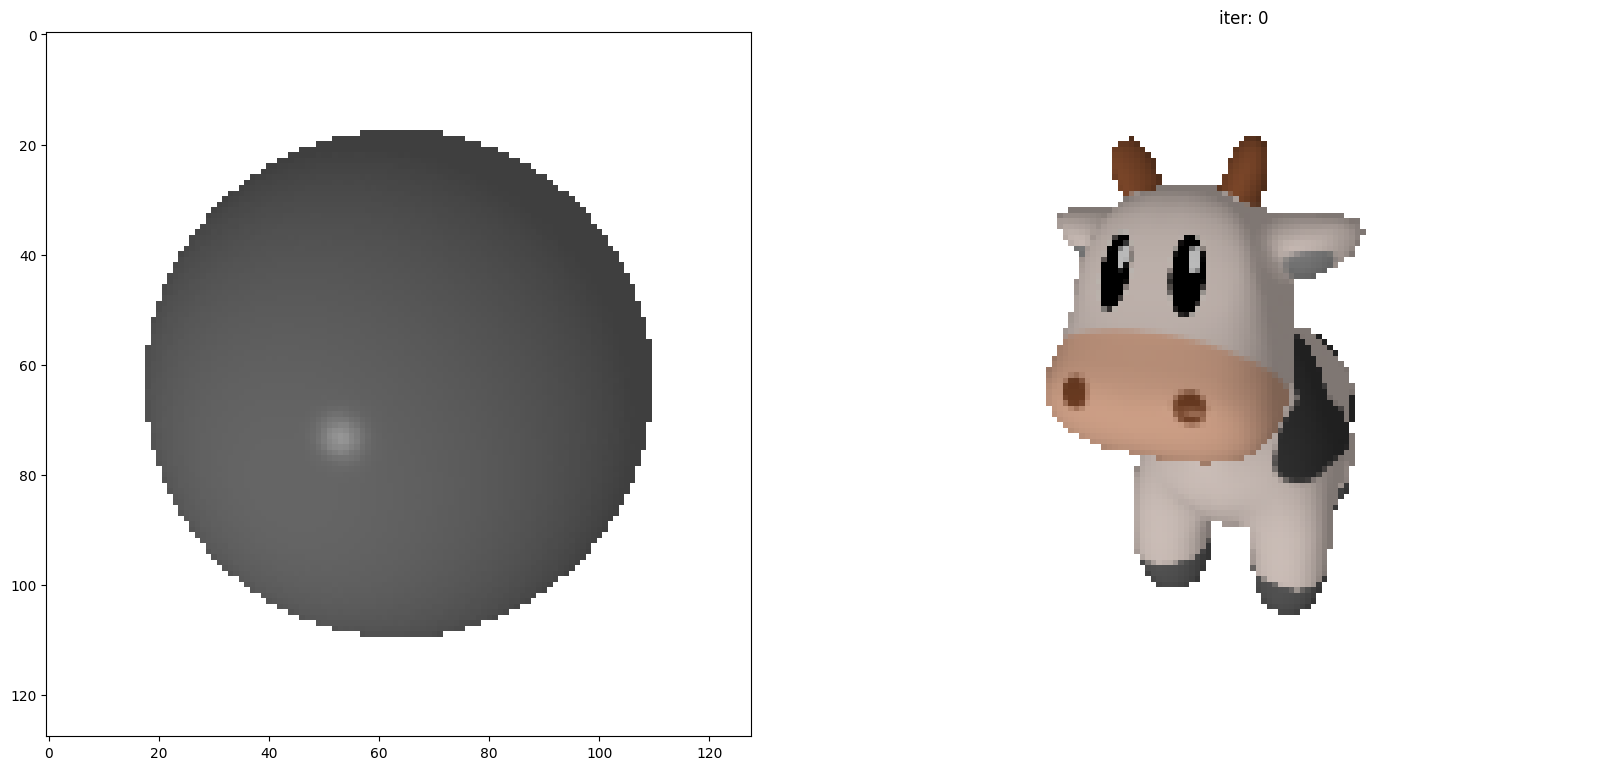

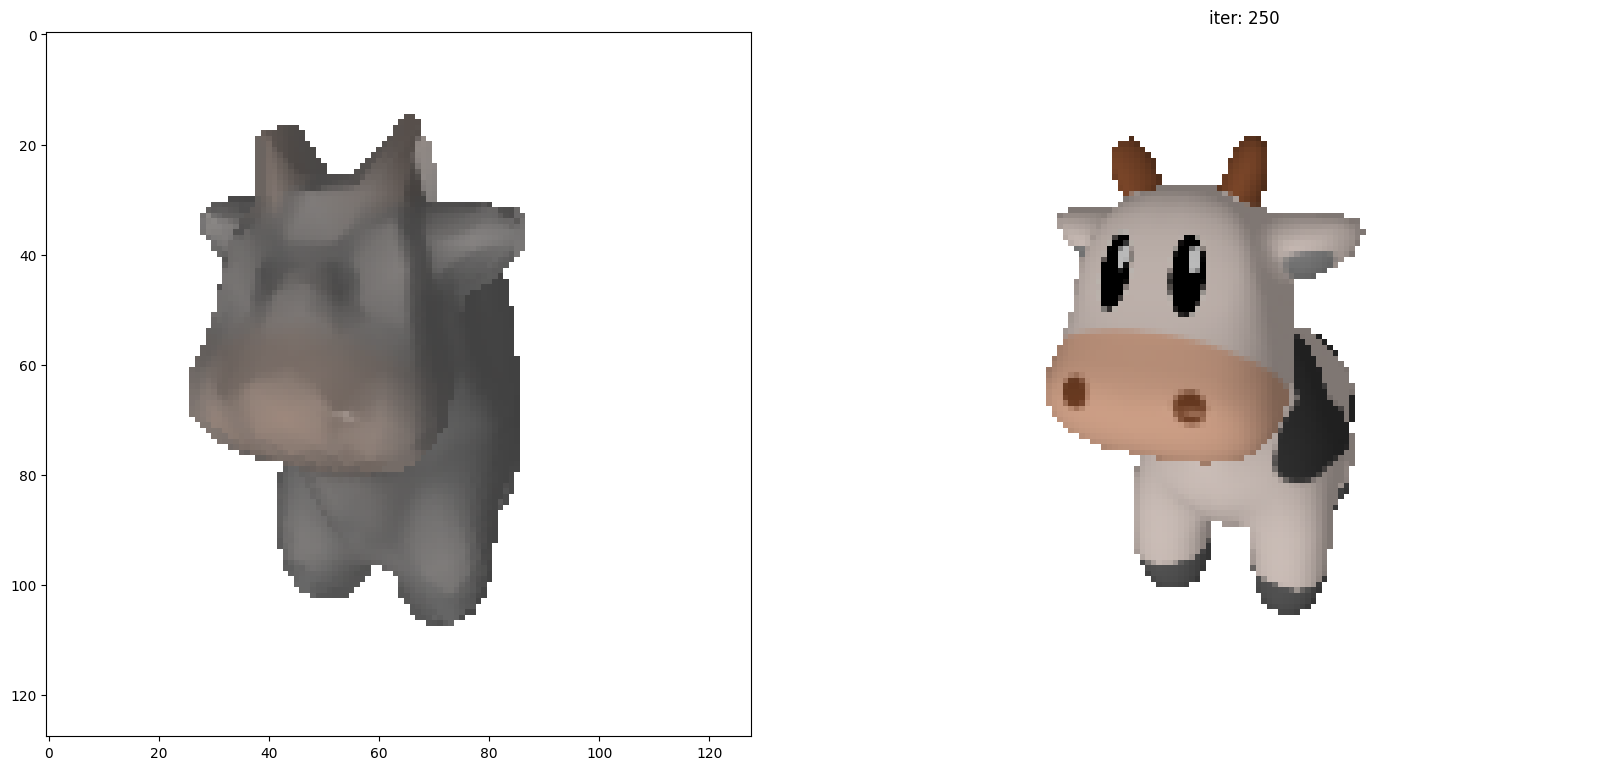

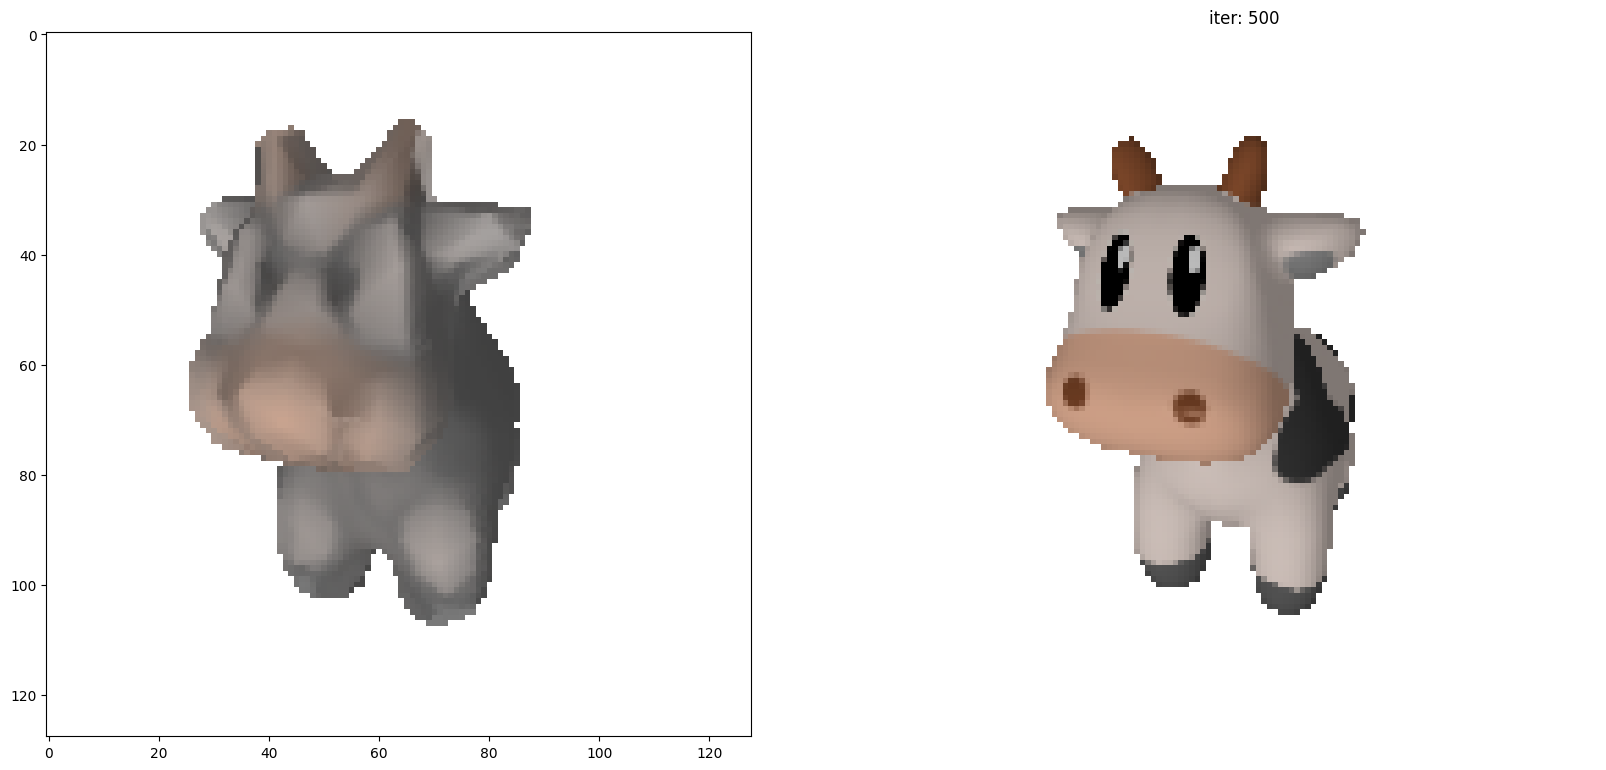

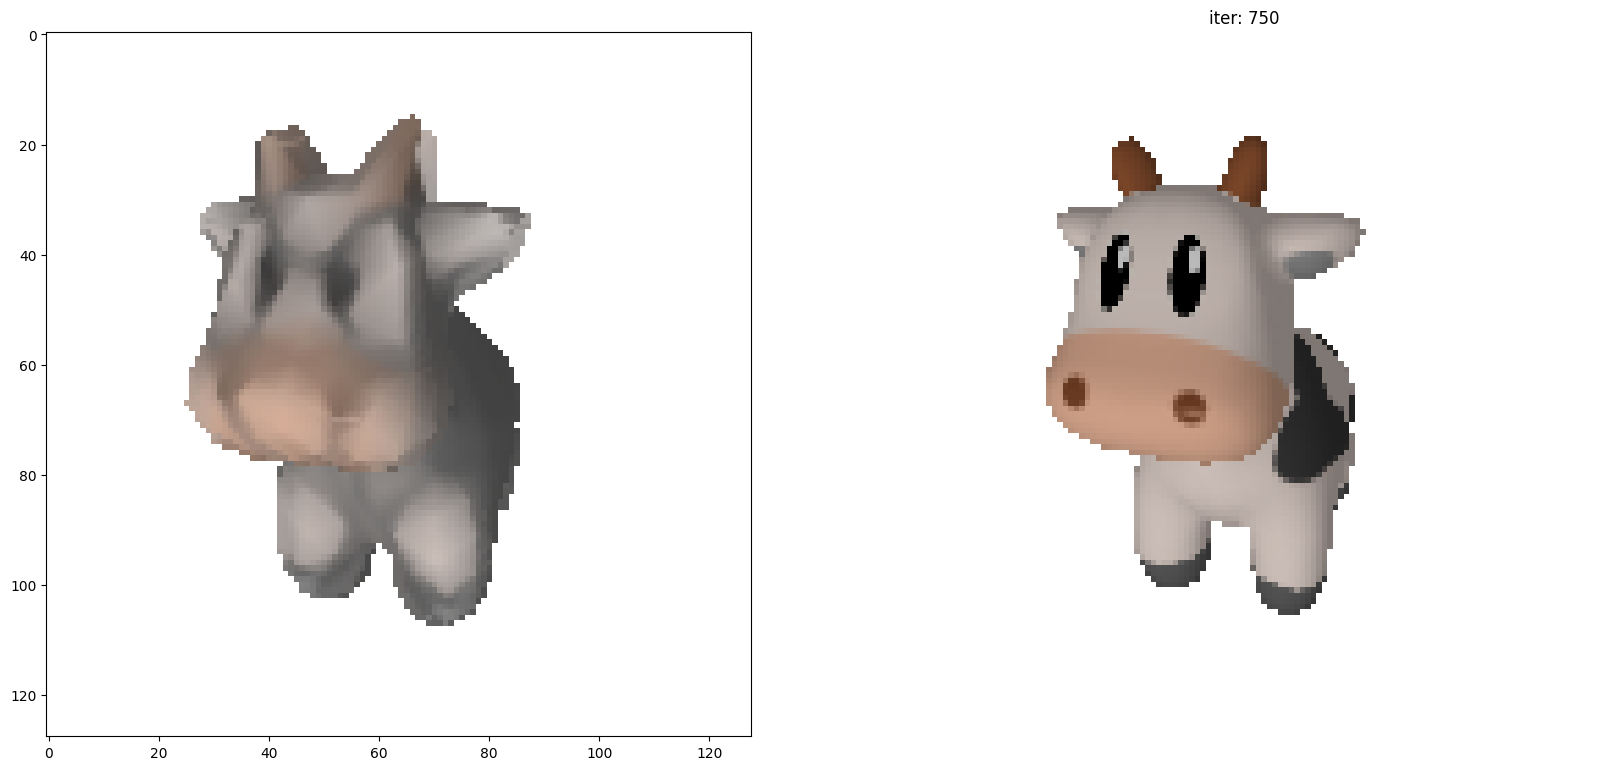

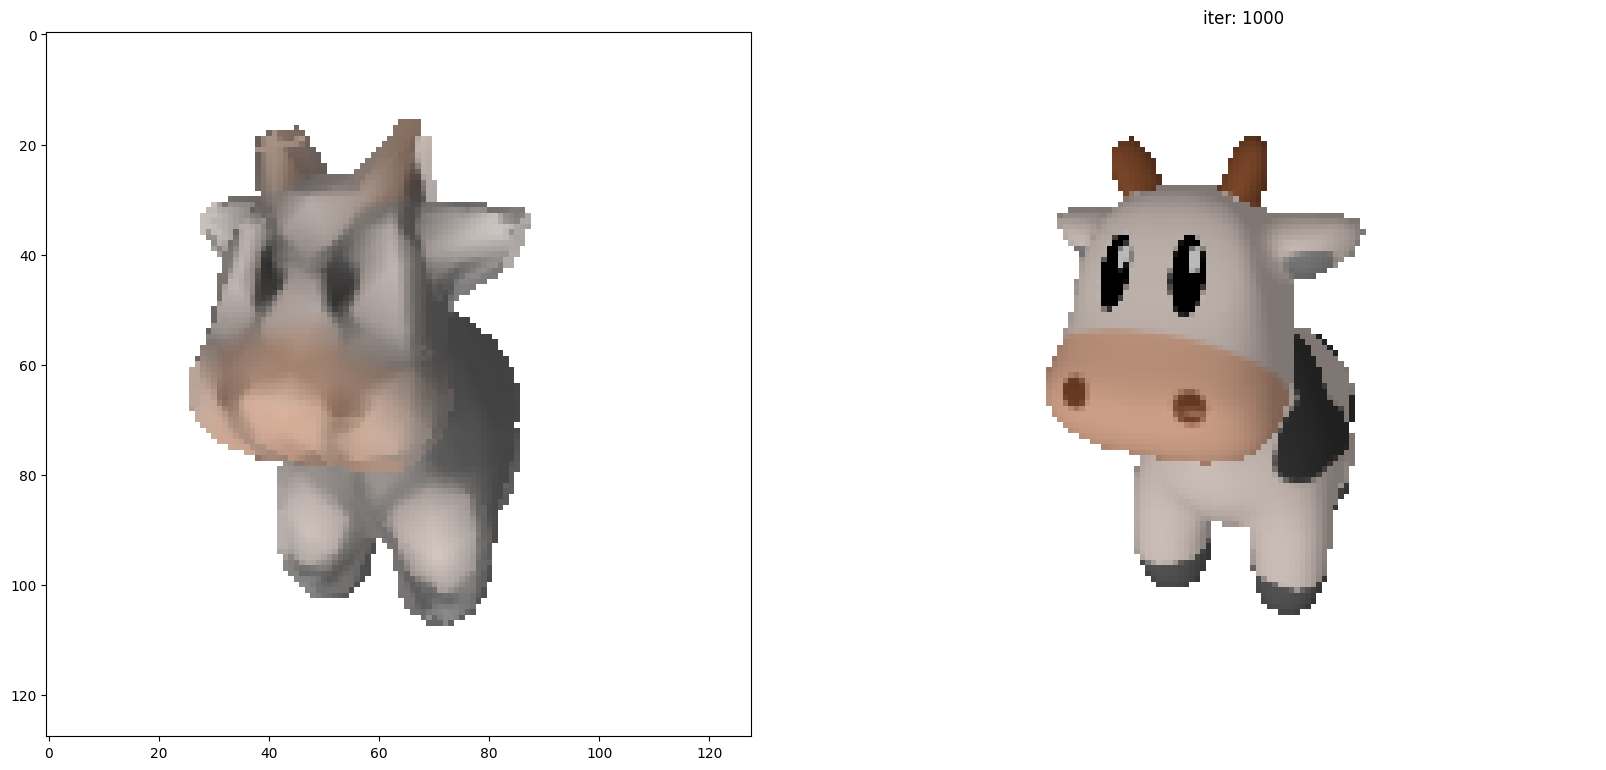

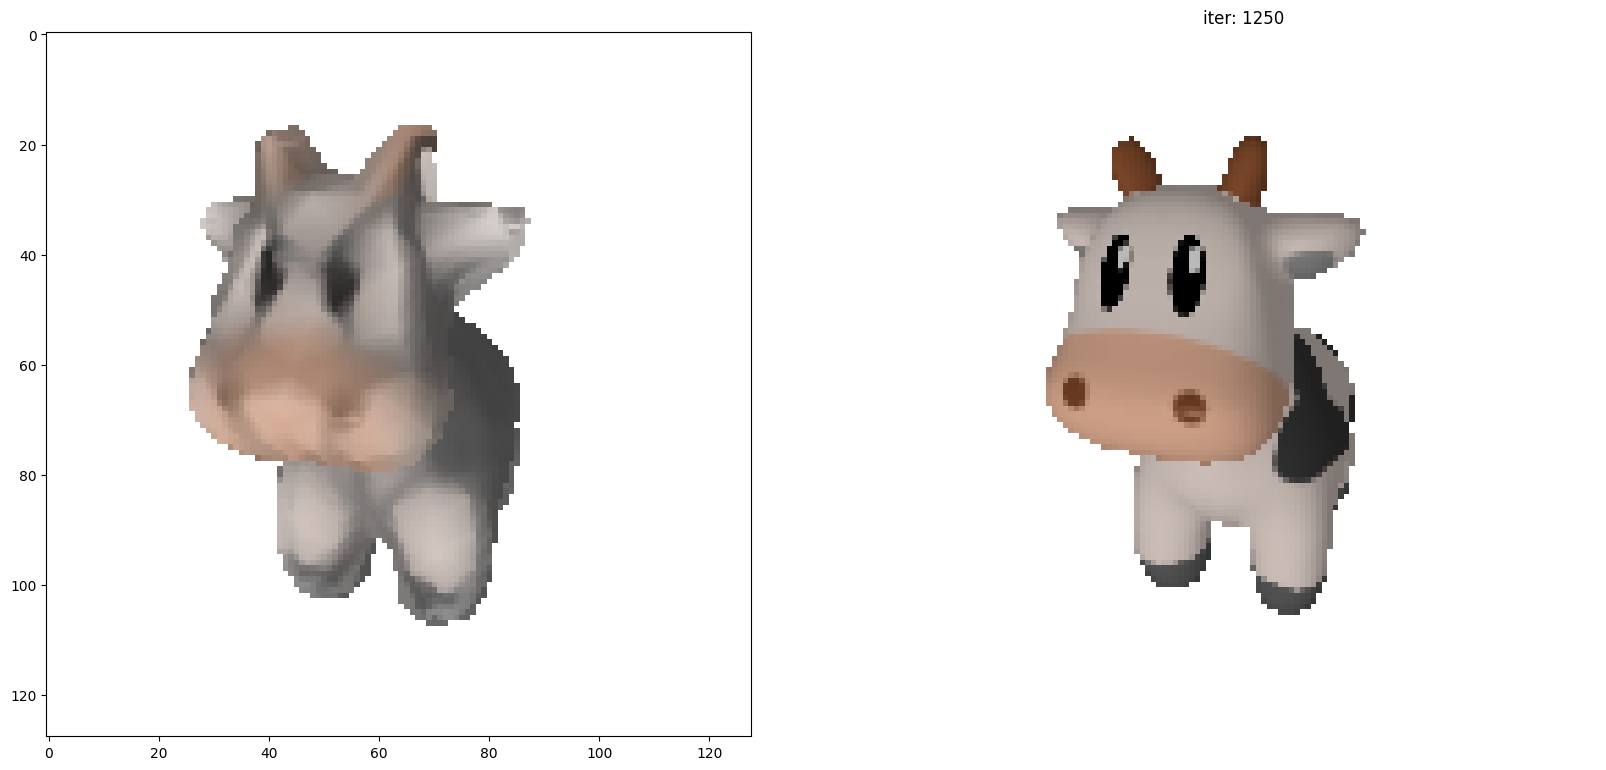

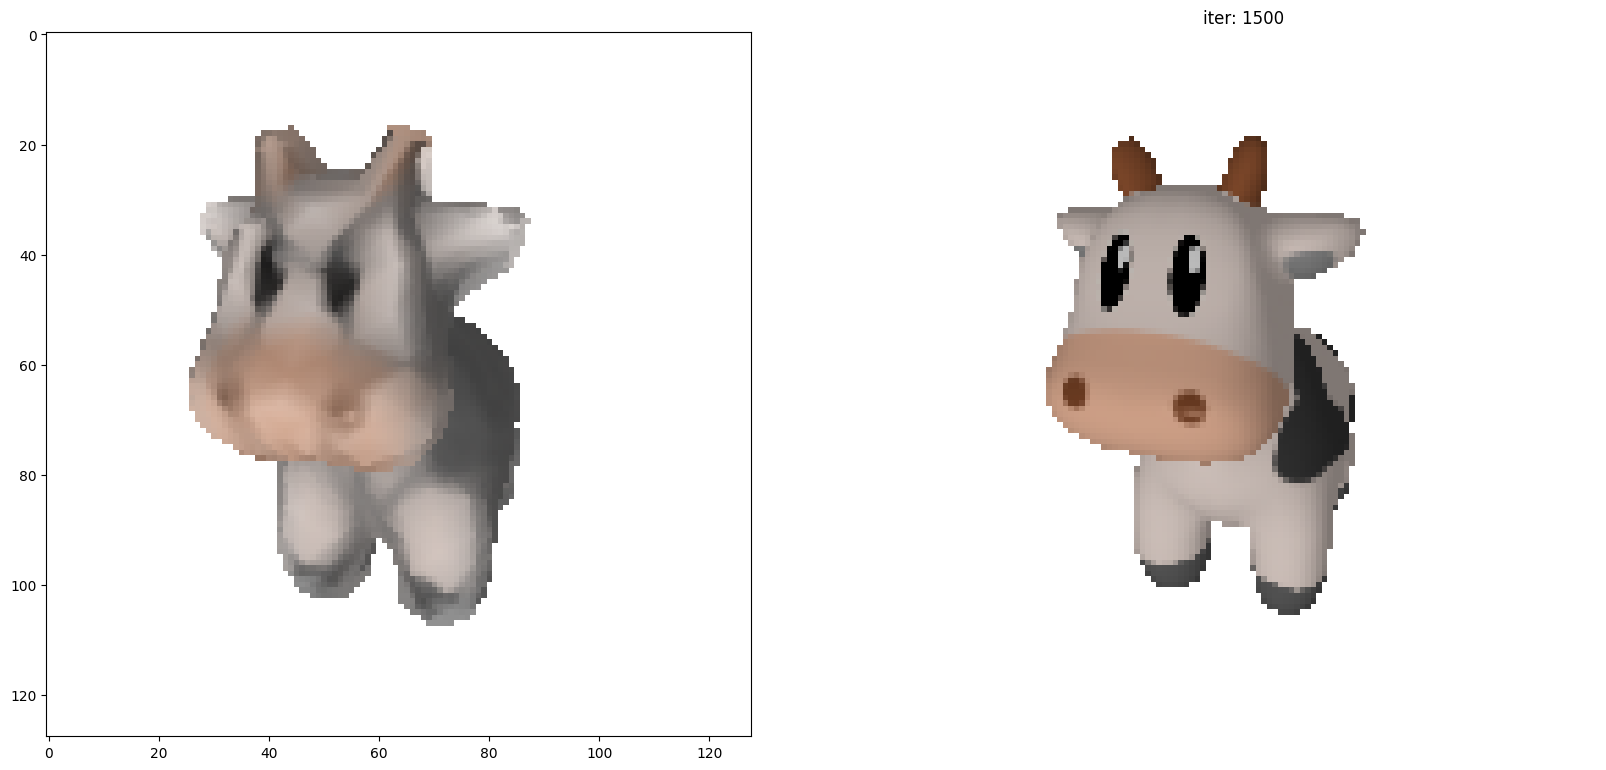

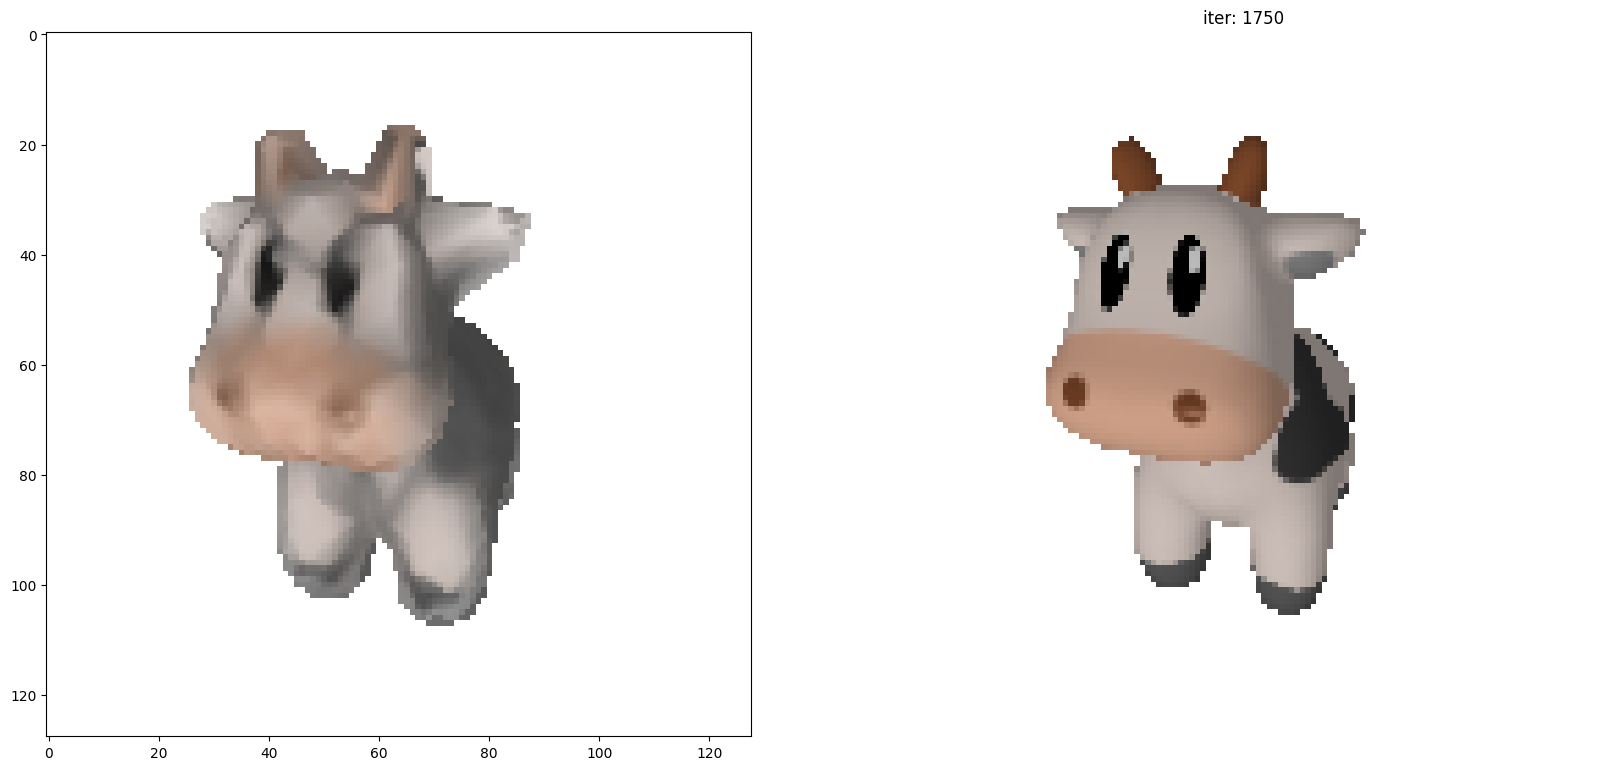

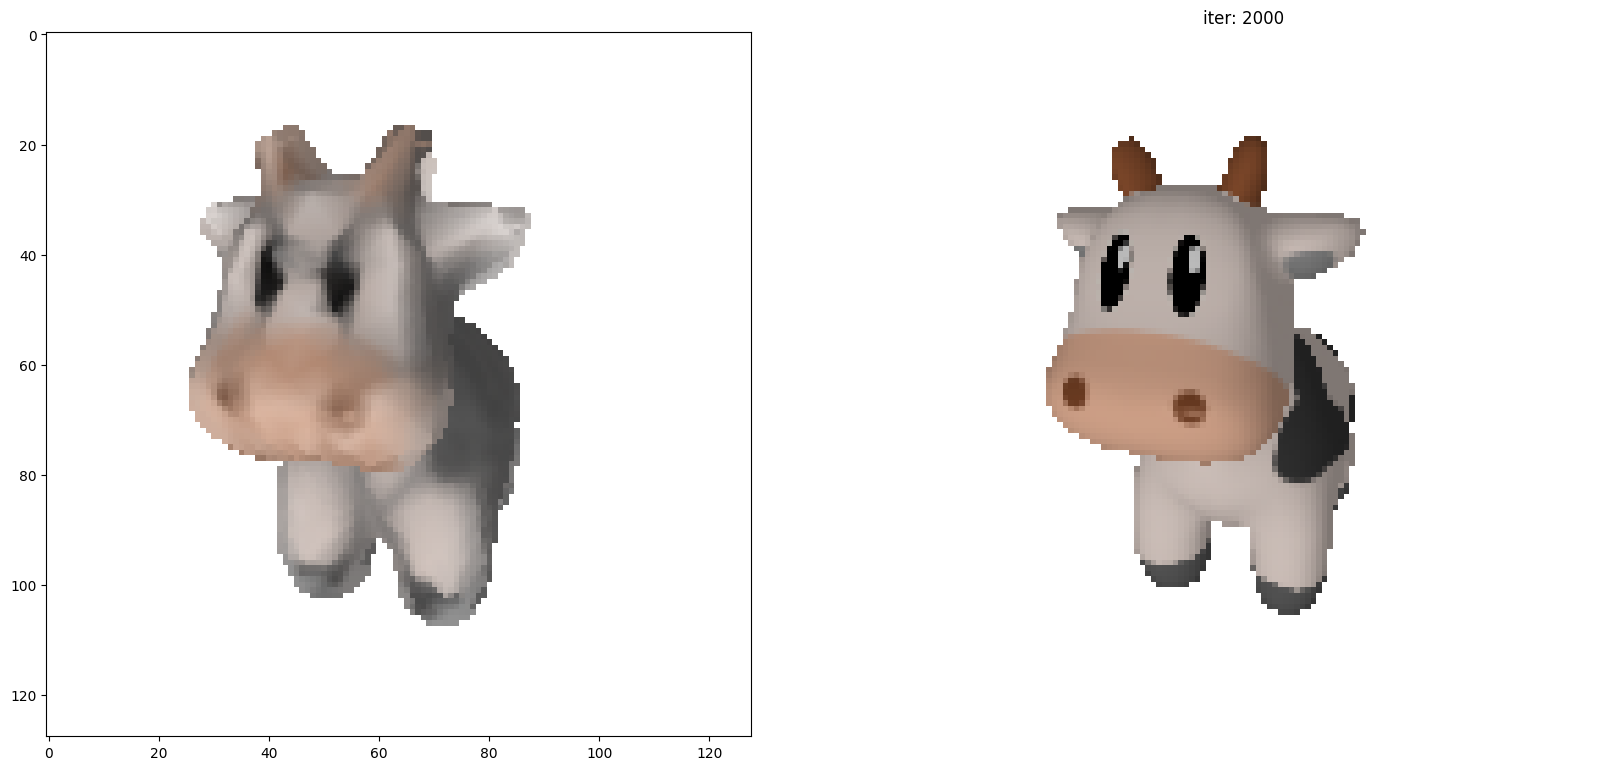

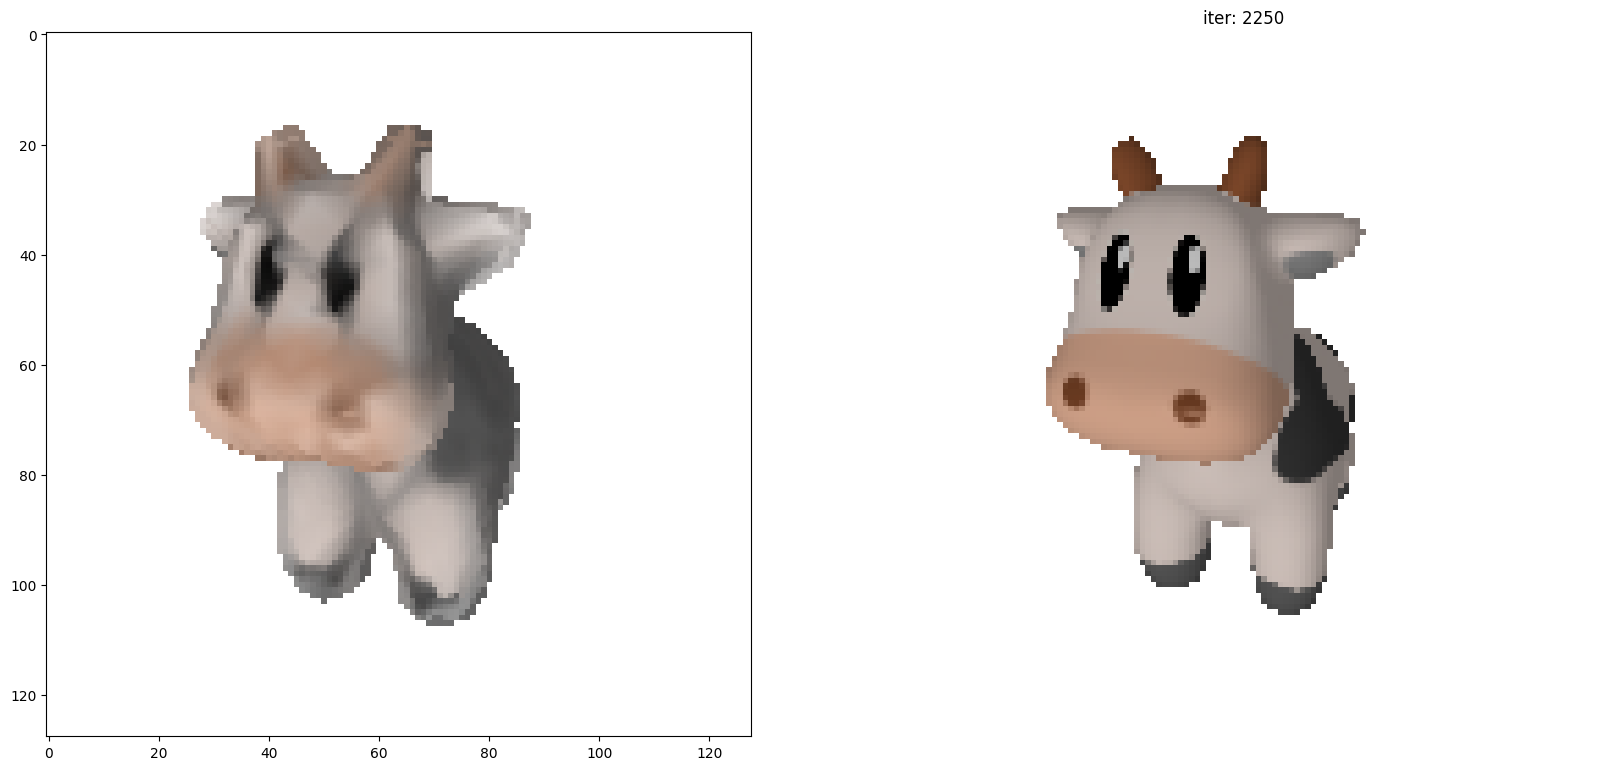

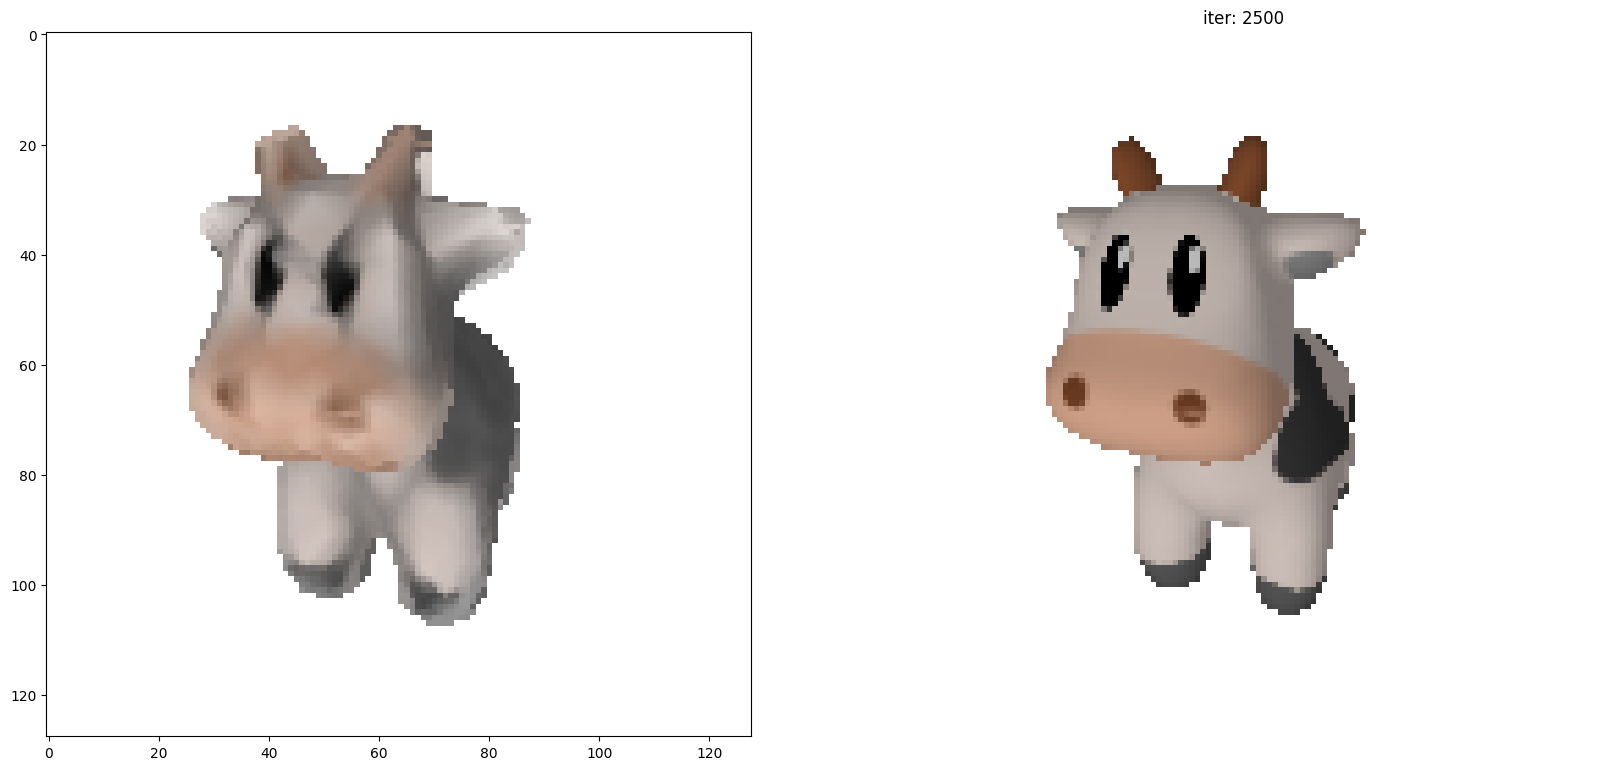

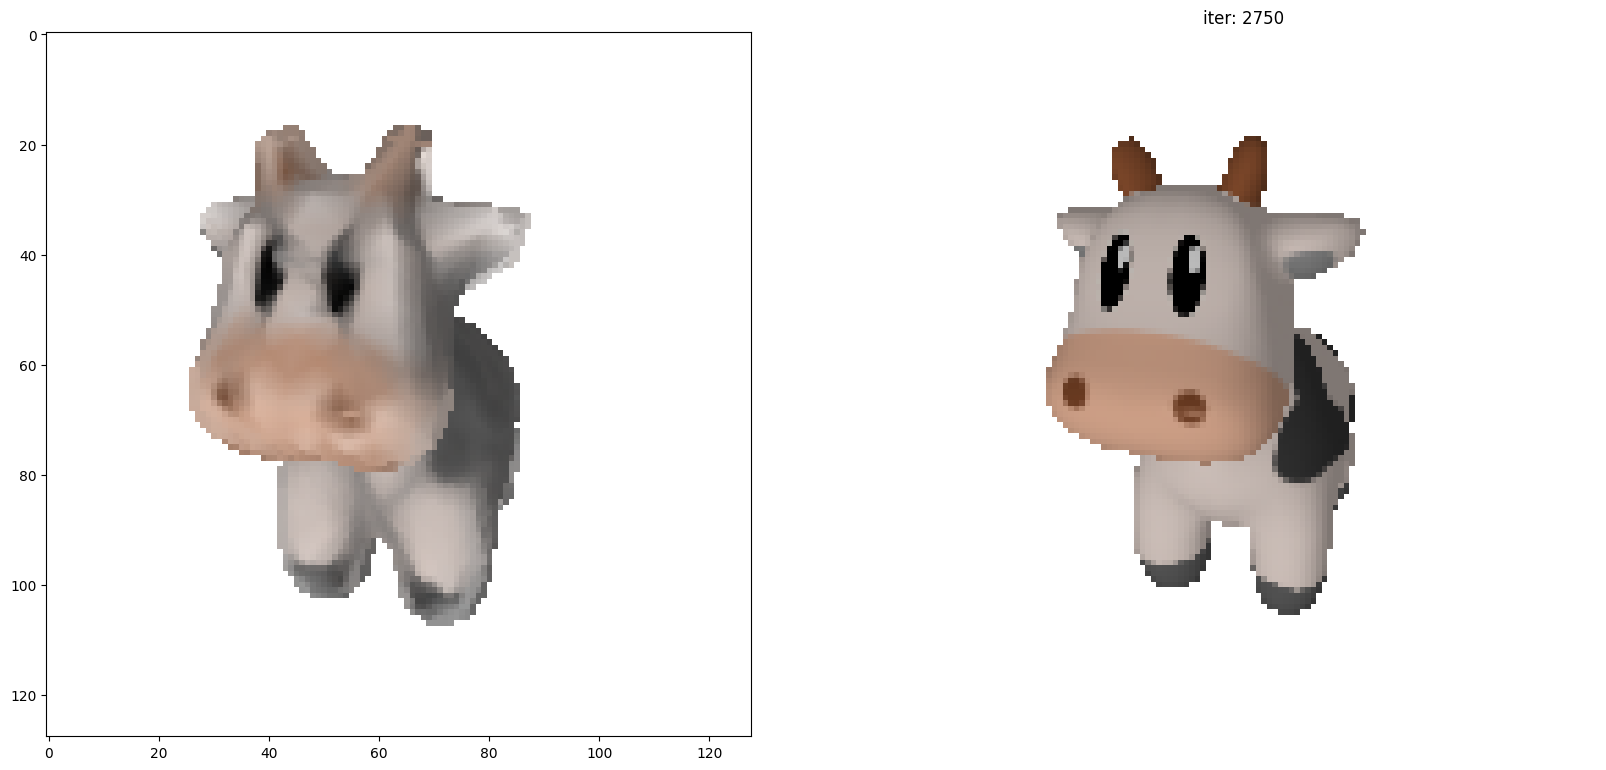

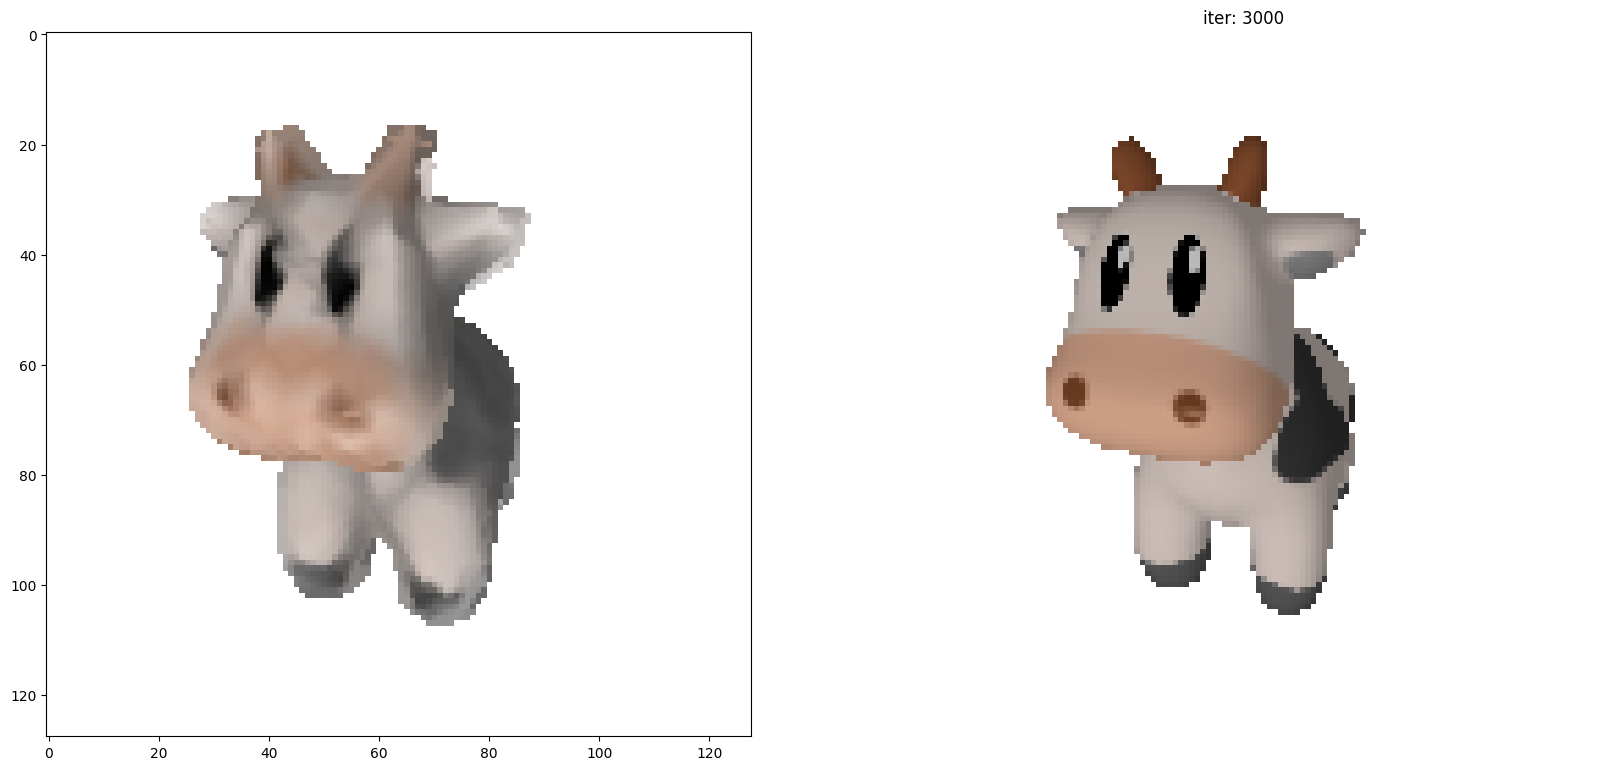

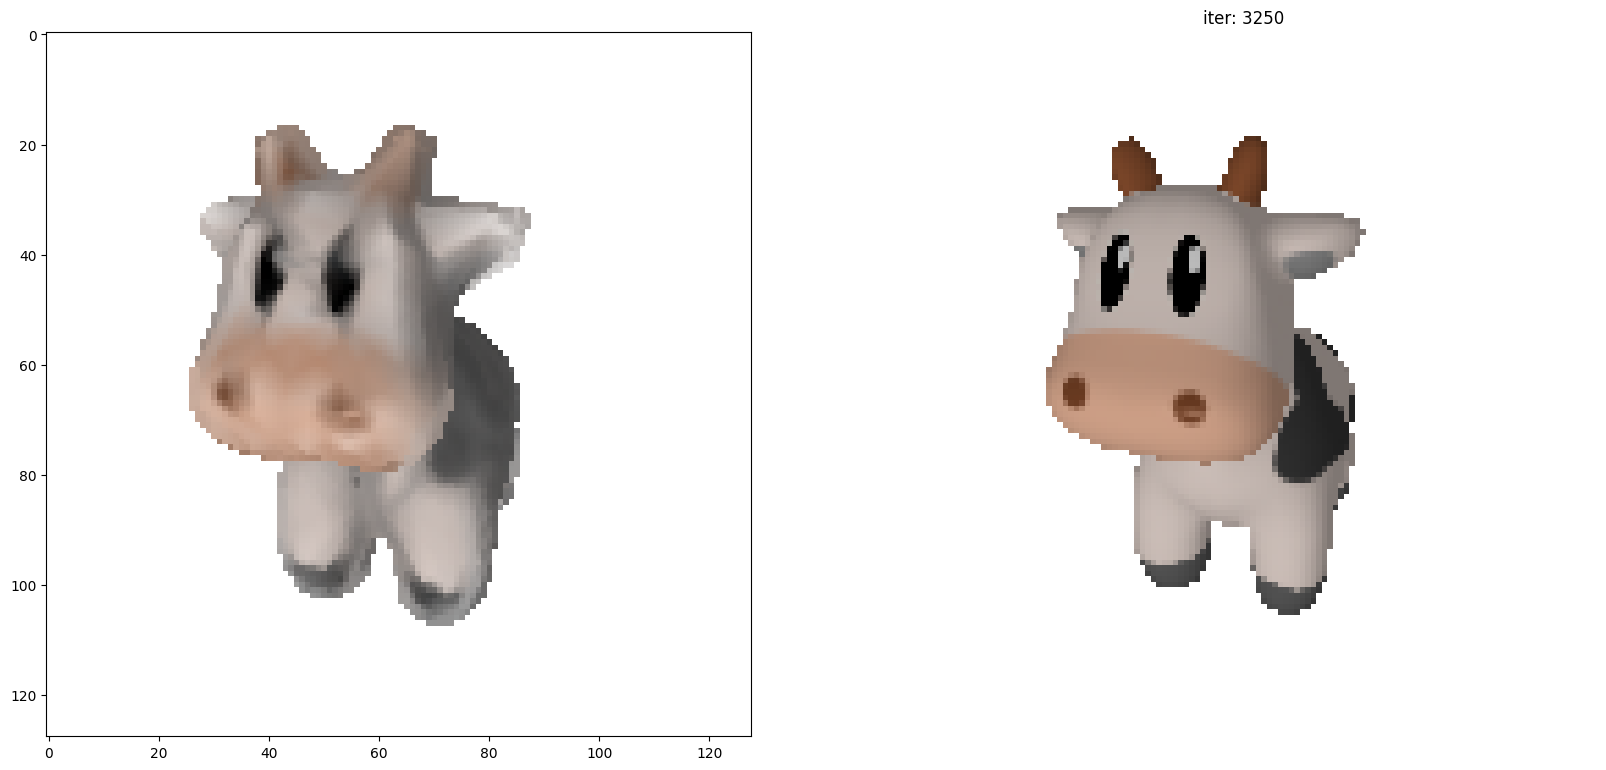

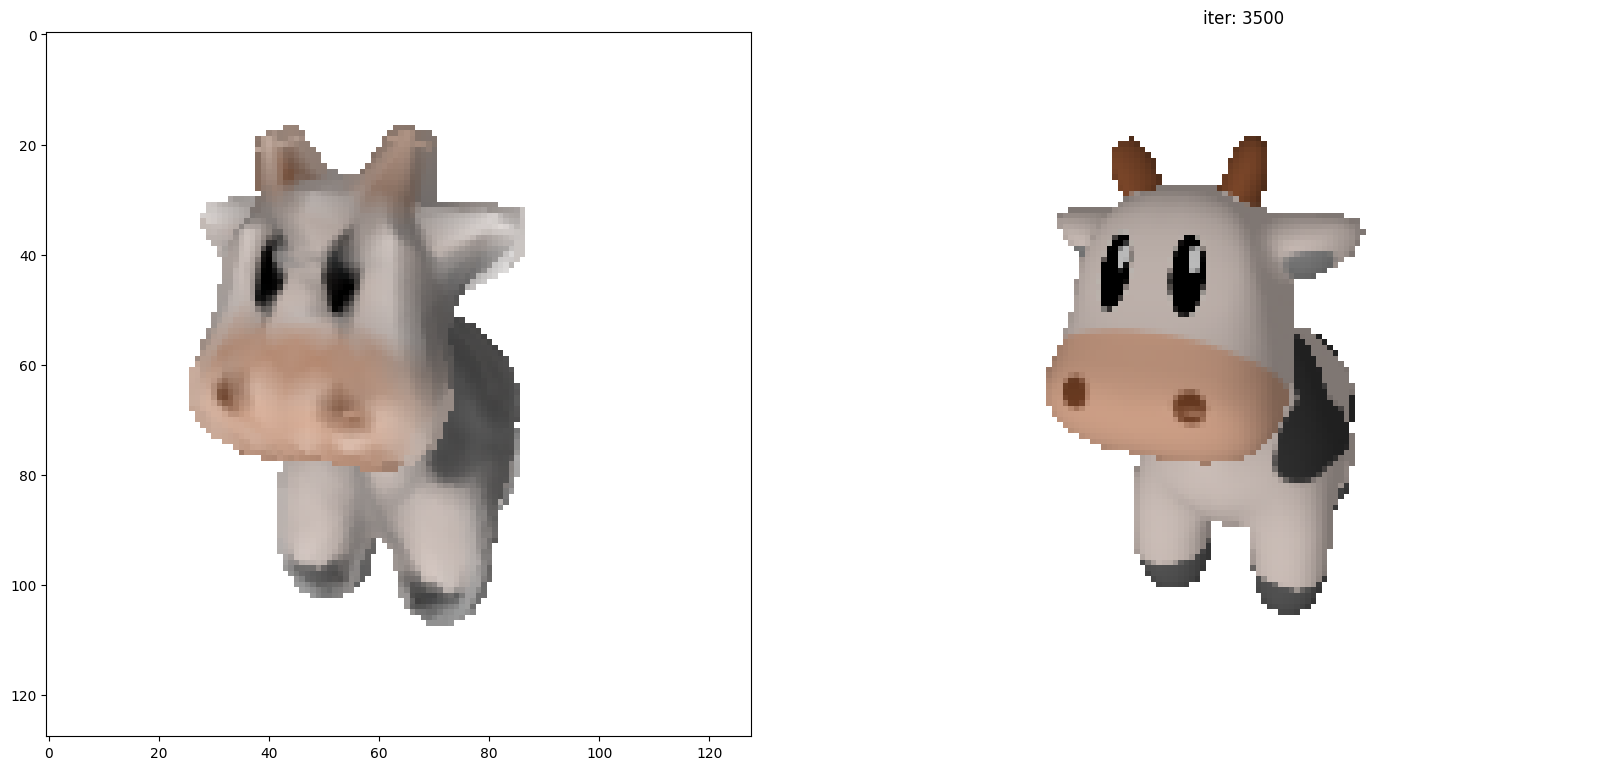

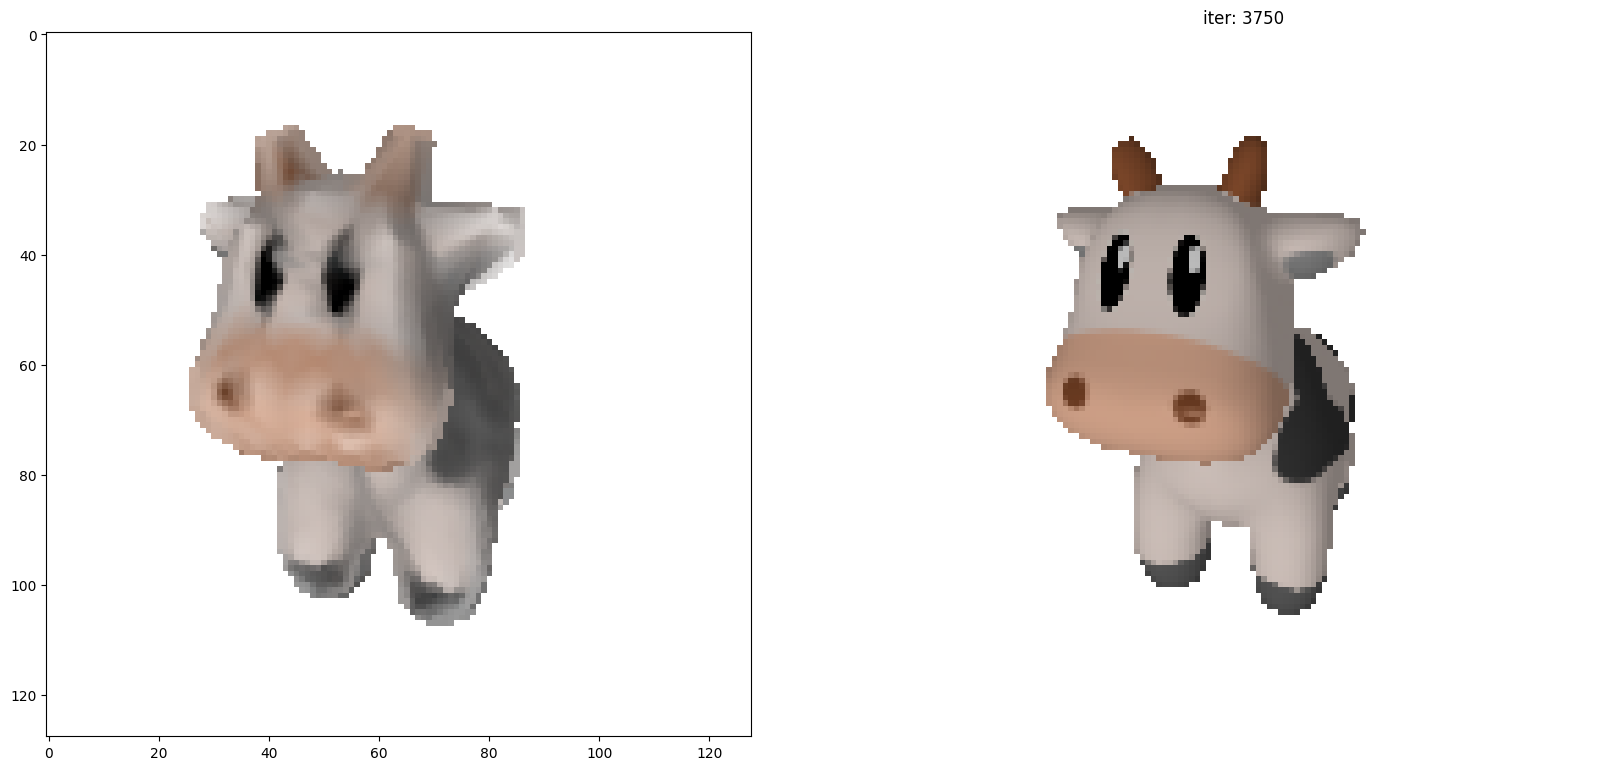

In [44]:
loop = tqdm(range(Niter))

for i in loop:
    # Initialize optimizer
    optimizer.zero_grad()

    # Deform the mesh
    new_src_mesh = src_mesh.offset_verts(deform_verts)

    # Add per vertex colors to texture the mesh
    new_src_mesh.textures = TexturesVertex(verts_features=sphere_verts_rgb)

    # Losses to smooth /regularize the mesh shape
    loss = {k: torch.tensor(0.0, device=device) for k in losses}
    update_mesh_shape_prior_losses(new_src_mesh, loss)

    # Randomly select two views to optimize over in this iteration.  Compared
    # to using just one view, this helps resolve ambiguities between updating
    # mesh shape vs. updating mesh texture
    for j in np.random.permutation(num_views).tolist()[:num_views_per_iteration]:
        images_predicted = renderer_textured(new_src_mesh, cameras=target_cameras[j], lights=lights)

        # Squared L2 distance between the predicted silhouette and the target
        # silhouette from our dataset
        predicted_silhouette = images_predicted[..., 3]
        loss_silhouette = ((predicted_silhouette - target_silhouette[j]) ** 2).mean()
        loss["silhouette"] += loss_silhouette / num_views_per_iteration

        # Squared L2 distance between the predicted RGB image and the target
        # image from our dataset
        predicted_rgb = images_predicted[..., :3]
        loss_rgb = ((predicted_rgb - target_rgb[j]) ** 2).mean()
        loss["rgb"] += loss_rgb / num_views_per_iteration

    # Weighted sum of the losses
    sum_loss = torch.tensor(0.0, device=device)
    for k, l in loss.items():
        sum_loss += l * losses[k]["weight"]
        losses[k]["values"].append(l.detach().cpu())

    # Print the losses
    loop.set_description("total_loss = %.6f" % sum_loss)

    # Plot mesh
    if i % plot_period == 0:
        visualize_prediction(new_src_mesh, renderer=renderer_textured, title="iter: %d" % i, silhouette=False)

    # Optimization step
    sum_loss.backward()
    optimizer.step()


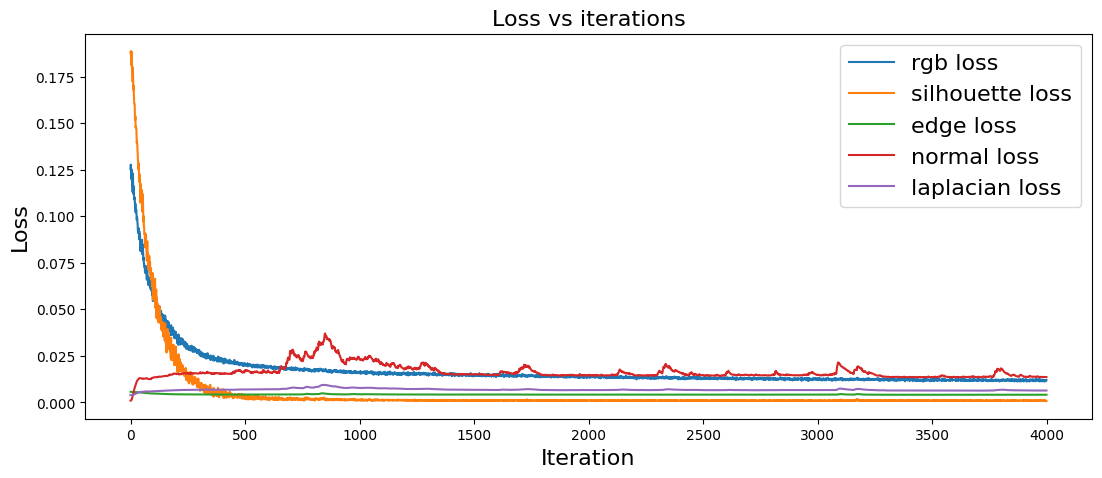

In [45]:
# default parameters
plot_losses(losses)

In [47]:
#Plotando os objetos lado a lado
show_plotly_side_by_side(new_src_mesh, "Predicted", mesh, "Source")

In [46]:
# Fetch the verts and faces of the final predicted mesh
final_verts, final_faces = new_src_mesh.get_mesh_verts_faces(0)

# Scale normalize back to the original target size
final_verts = final_verts * scale + center

# Store the predicted mesh using save_obj
final_obj = os.path.join('./', 'final_model_new_parameters.obj')
save_obj(final_obj, final_verts, final_faces)

**[EXTRA] E.1 Deform the textured cow into a sphere - you can choose to supervise with multi-view images (of a sphere) or the sphere geometry. Save the result, then deform the textured sphere into the cow again. What happened?**

---------

# 5 Camera Position Optimization

Until now, we assumed we knew the cameras and we learned how to infer the geometry and texture of a mesh using a differentiable renderer and supervising the training with the multiview images dataset.

Now, we'll assume we have the geometry and images of the object, but we don't know the cameras. Can we infer the camera position by backpropagation?

In [48]:
import torch.nn as nn
import torch.nn.functional as F
import imageio
from skimage import img_as_ubyte

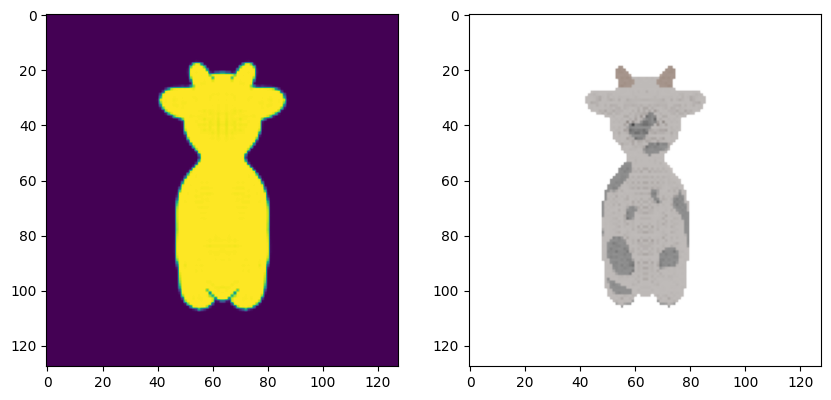

In [49]:
# Select the viewpoint using spherical angles
distance = 3   # distance from camera to the object
elevation = 50.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis.

# Get the position of the camera based on the spherical angles
Rot, Tr = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the mesh providing the values of R and T.
silhouete = renderer_silhouette(meshes_world=mesh, R=Rot, T=Tr)
image_ref = renderer(meshes_world=mesh, R=Rot, T=Tr)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

### Set up a basic model

Here we create a simple model class and initialize a parameter for the camera position.

In [50]:
class Model(nn.Module):
    def __init__(self, meshes, renderer, image_ref):
        super().__init__()
        self.meshes = meshes
        self.device = meshes.device
        self.renderer = renderer

        # Get the silhouette of the reference RGB image by finding all non-white pixel values.
        image_ref = torch.from_numpy((image_ref[..., :3].max(-1) != 1).astype(np.float32))
        self.register_buffer('image_ref', image_ref)

        # Create an optimizable parameter for the x, y, z position of the camera.
        self.camera_position = nn.Parameter(
            torch.from_numpy(np.array([3.0,  6.9, +2.5], dtype=np.float32)).to(meshes.device))

    def forward(self):

        # Render the image using the updated camera position. Based on the new position of the
        # camer we calculate the rotation and translation matrices
        R = look_at_rotation(self.camera_position[None, :], device=self.device)  # (1, 3, 3)
        T = -torch.bmm(R.transpose(1, 2), self.camera_position[None, :, None])[:, :, 0]   # (1, 3)

        image = self.renderer(meshes_world=self.meshes.clone(), R=R, T=T)

        # Calculate the silhouette loss
        loss = torch.sum((image[..., 3] - self.image_ref) ** 2)
        return loss, image


### Initialize the model and optimizer

Now we can create an instance of the **model** above and set up an **optimizer** for the camera position parameter.

In [51]:
# We will save images periodically and compose them into a GIF.
filename_output = "./cow_optimization_demo.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh, renderer=renderer_silhouette, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

### Visualize the starting position and the reference position

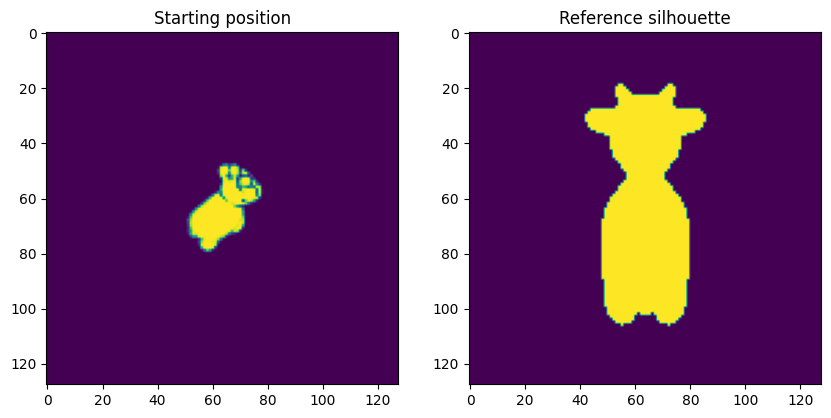

In [52]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


### Run the optimization

We run several iterations of the forward and backward pass and save outputs every 10 iterations. When this has finished take a look at `./cow_optimization_demo.gif` for a cool gif of the optimization process!

  0%|          | 0/200 [00:00<?, ?it/s]

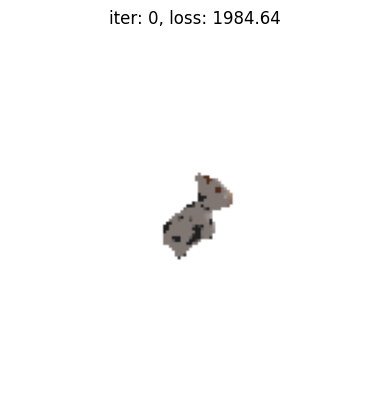

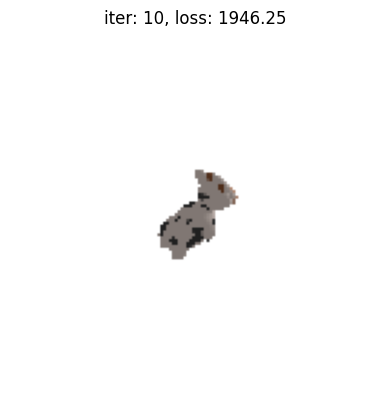

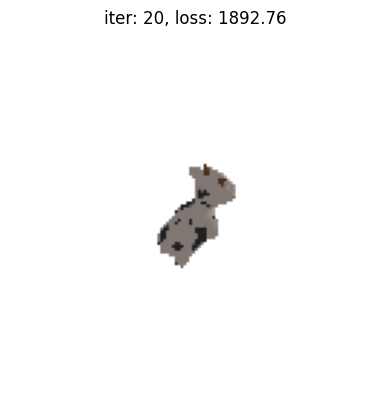

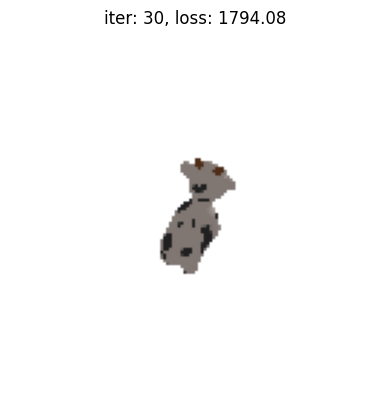

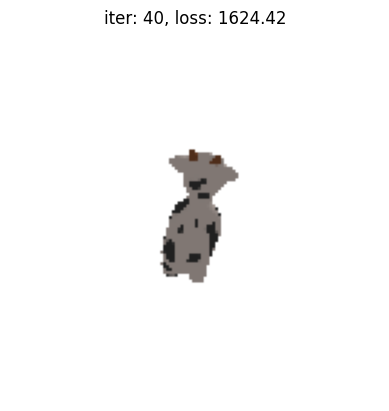

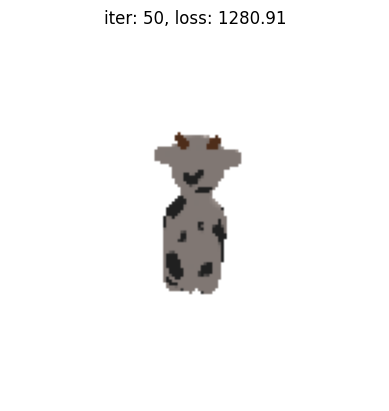

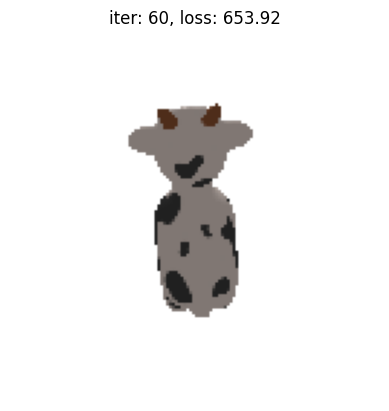

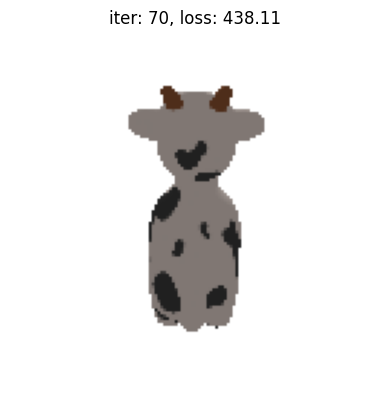

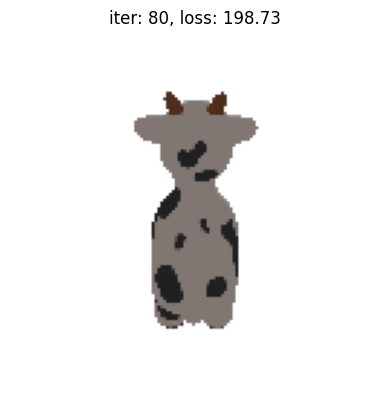

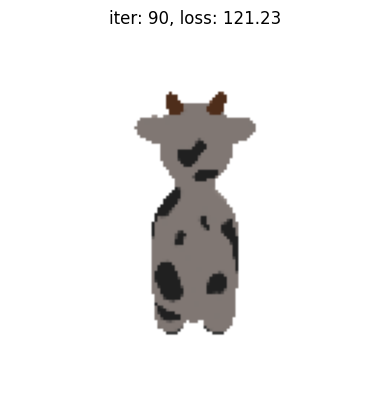

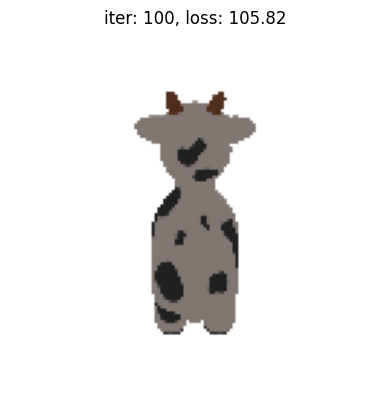

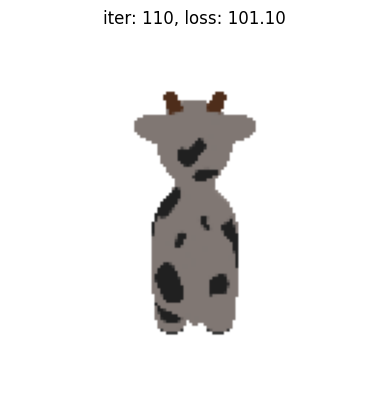

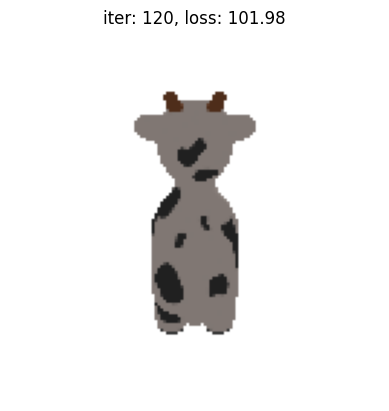

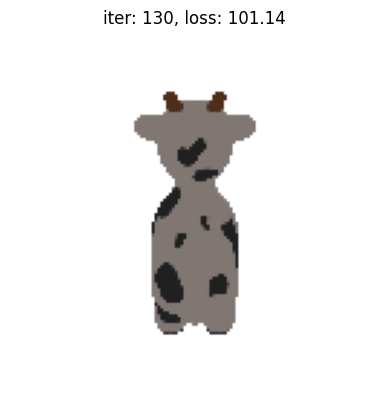

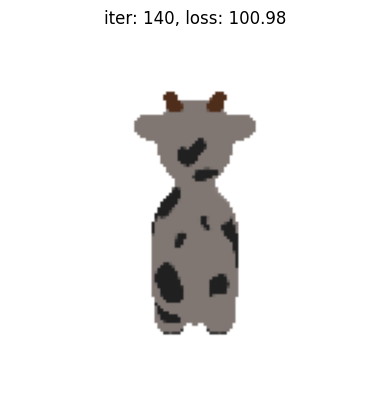

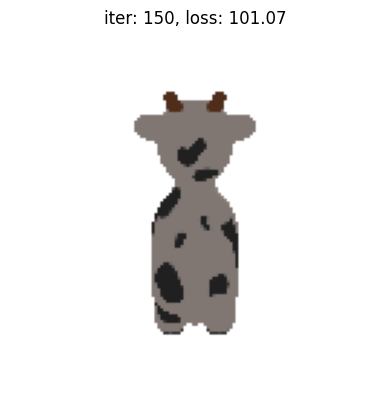

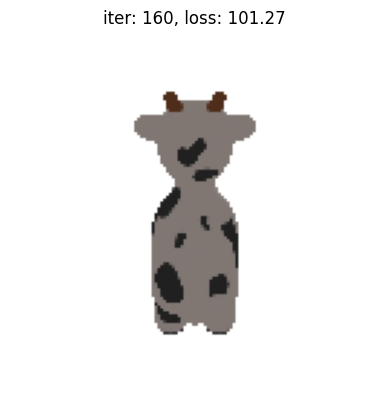

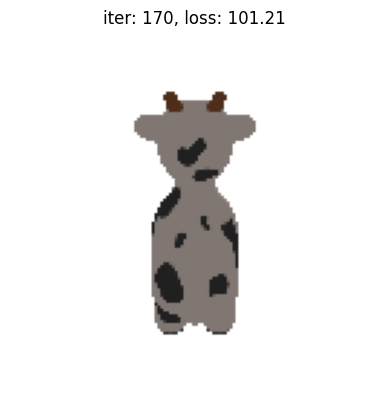

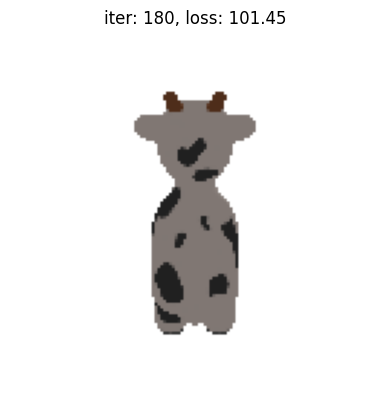

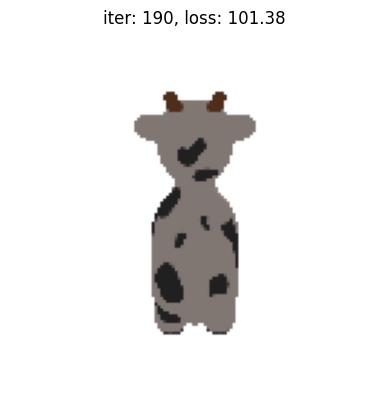

In [53]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if loss.item() < 100:
        print("loss below threshold")
        break

    # Save outputs to create a GIF.
    if i % 10 == 0:
        Rot = look_at_rotation(model.camera_position[None, :], device=model.device)
        Tr = -torch.bmm(Rot.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = renderer(meshes_world=model.meshes.clone(), R=Rot, T=Tr)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")

writer.close()

# Questions

5.1 Evaluate how close our prediction is to the ground truth camera position. Explain your metric.

**Considerations:** By observing the object from the predicted camera viewpoint and the generated GIF image, it is possible explain qualitatively that the reference silhouette corresponds to the generated view. However, a possible limitation is that the silhouette could be similar if the camera were positioned on the other side of the object. In such cases, the orientation of the camera could be important.

In [ ]:
##############################################################################
# Code and explanations for 5.1 - 5.2 (and optionally E.2)
##############################################################################

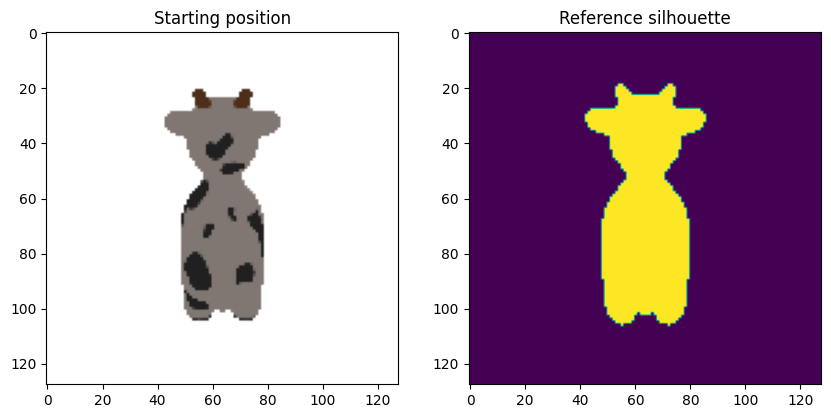

In [56]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image[..., :3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

5.2 Experiment with other views - different target images and different initial positions to the camera model. Does it always work?

**Considerations:** I tried different initial configurations and observed that the cameras converge easily when the target silhouette has a similar position. However, if the predicted camera needs to rotate and translate more than ~90 degrees, the convergence of the result is hindered. In other words, when the starting position is close to the target, it converges quickly, resulting in higher accuracy.

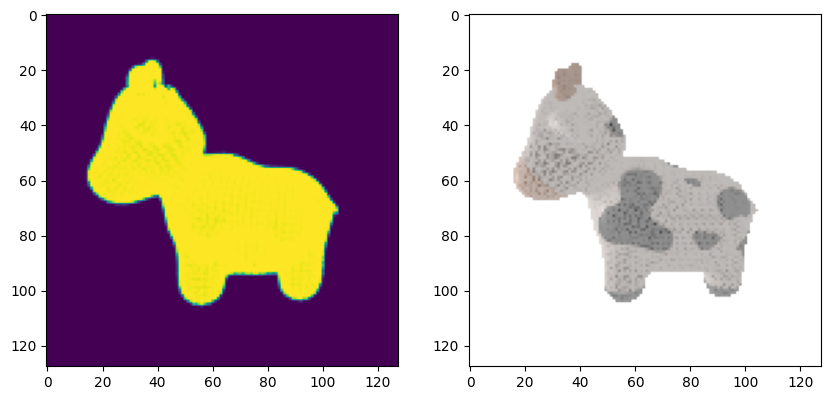

In [70]:
# Select the viewpoint using spherical angles
distance = 2.6
elevation = 27.0
azimuth = 269.0

# Get the position of the camera based on the spherical angles
Rot, Tr = look_at_view_transform(distance, elevation, azimuth, device=device)

# Render the mesh providing the values of R and T.
silhouete = renderer_silhouette(meshes_world=mesh, R=Rot, T=Tr)
image_ref = renderer(meshes_world=mesh, R=Rot, T=Tr)

silhouete = silhouete.cpu().numpy()
image_ref = image_ref.cpu().numpy()

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(silhouete.squeeze()[..., 3])  # only plot the alpha channel of the RGBA image
plt.grid(False)
plt.subplot(1, 2, 2)
plt.imshow(image_ref.squeeze())
plt.grid(False)

In [71]:
# We will save images periodically and compose them into a GIF.
filename_output = "./cow_optimization_demo2.gif"
writer = imageio.get_writer(filename_output, mode='I', duration=0.3)

# Initialize a model using the renderer, mesh and reference image
model = Model(meshes=mesh, renderer=renderer_silhouette, image_ref=image_ref).to(device)

# Create an optimizer. Here we are using Adam and we pass in the parameters of the model
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)

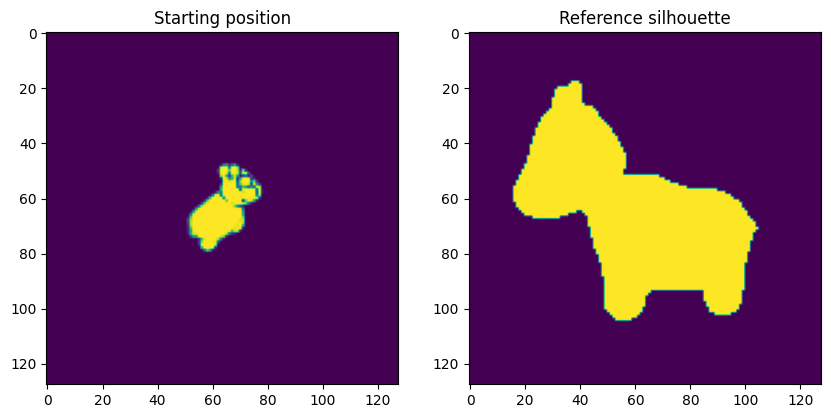

In [72]:
plt.figure(figsize=(10, 10))

_, image_init = model()
plt.subplot(1, 2, 1)
plt.imshow(image_init.detach().squeeze().cpu().numpy()[..., 3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");


  0%|          | 0/200 [00:00<?, ?it/s]

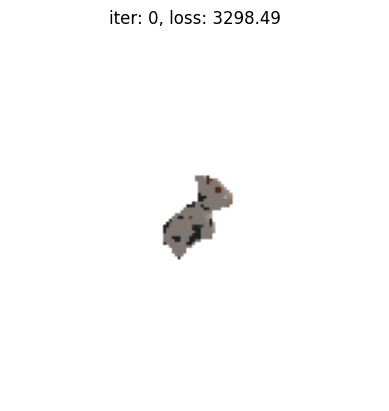

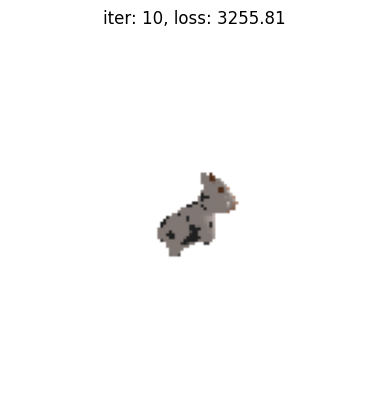

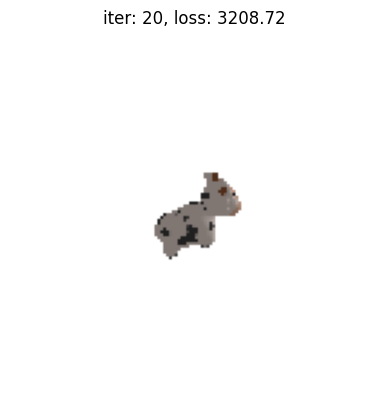

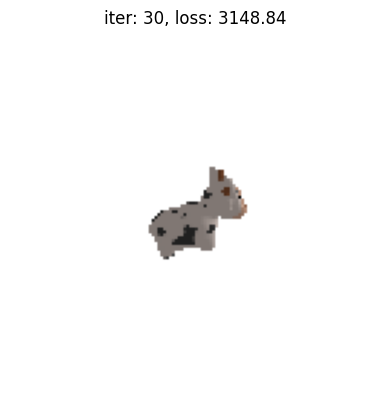

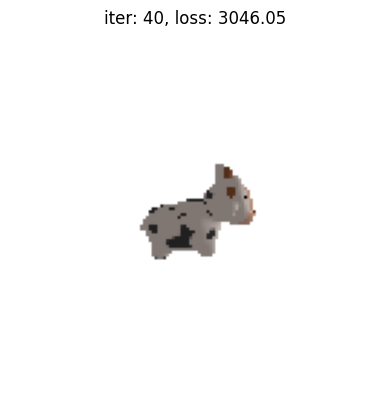

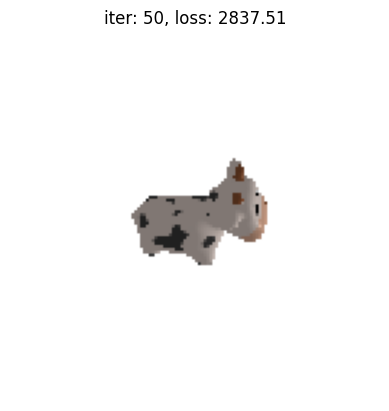

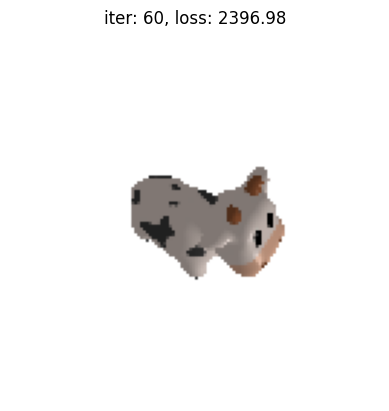

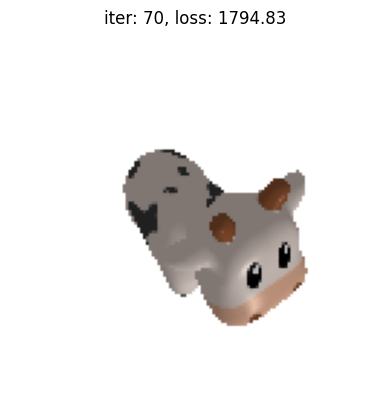

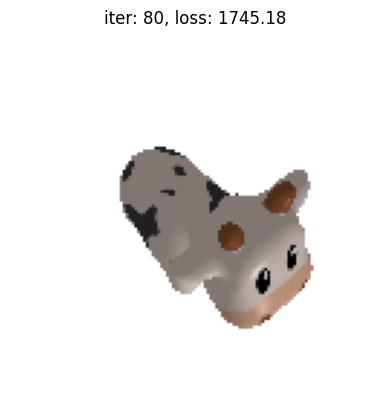

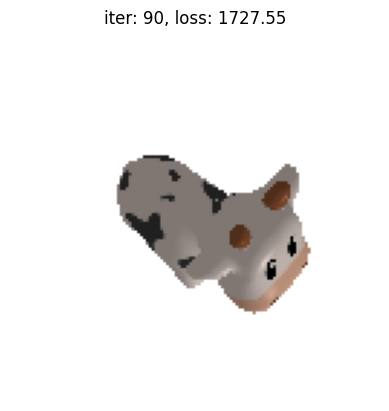

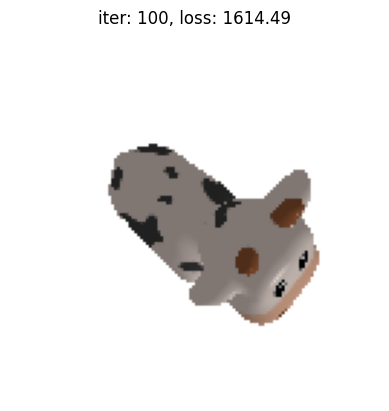

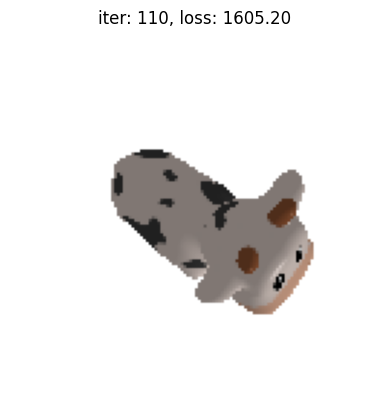

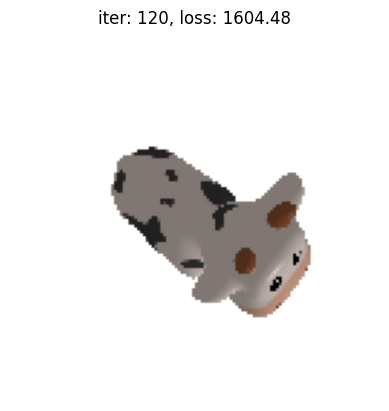

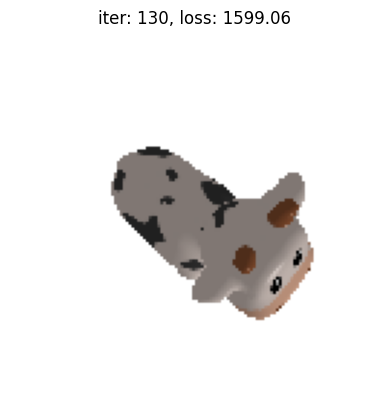

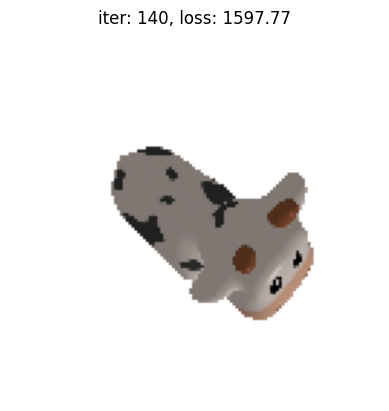

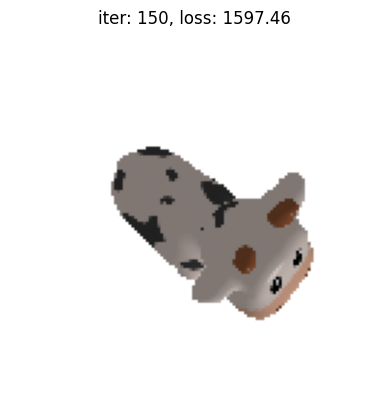

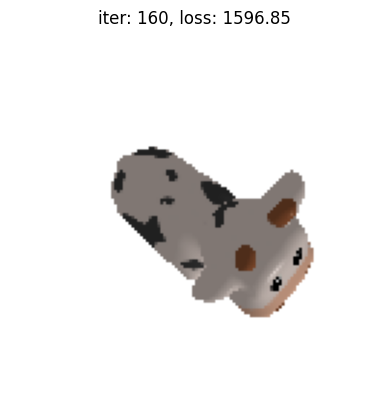

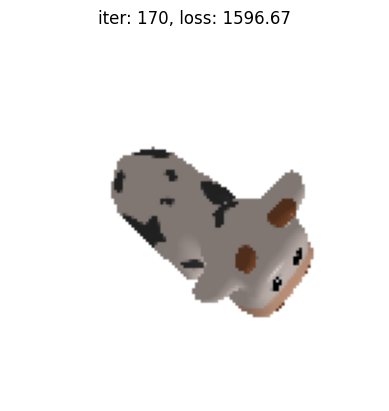

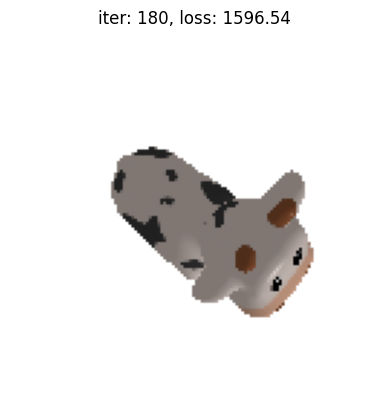

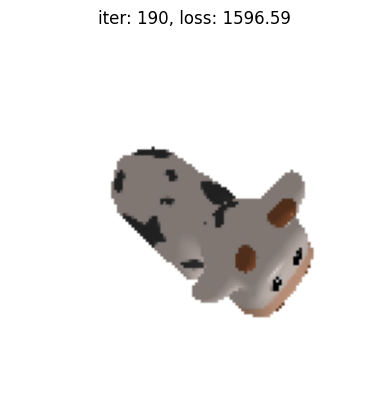

In [73]:
loop = tqdm(range(200))
for i in loop:
    optimizer.zero_grad()
    loss, _ = model()
    loss.backward()
    optimizer.step()

    loop.set_description('Optimizing (loss %.4f)' % loss.data)

    if loss.item() < 100:
        print("loss below threshold")
        break

    # Save outputs to create a GIF.
    if i % 10 == 0:
        Rot = look_at_rotation(model.camera_position[None, :], device=model.device)
        Tr = -torch.bmm(Rot.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        image = renderer(meshes_world=model.meshes.clone(), R=Rot, T=Tr)
        image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        image = img_as_ubyte(image)
        writer.append_data(image)

        plt.figure()
        plt.imshow(image[..., :3])
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        plt.grid("off")
        plt.axis("off")

writer.close()

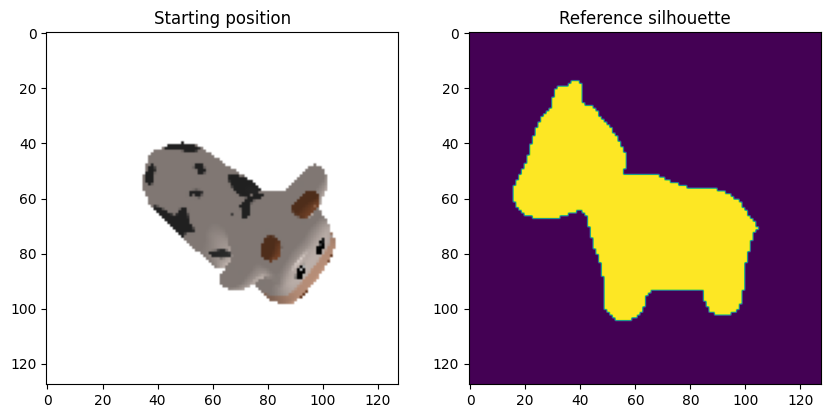

In [74]:
plt.figure(figsize=(10, 10))

plt.subplot(1, 2, 1)
plt.imshow(image[..., :3])
plt.grid(False)
plt.title("Starting position")

plt.subplot(1, 2, 2)
plt.imshow(model.image_ref.cpu().numpy().squeeze())
plt.grid(False)
plt.title("Reference silhouette");

**EXTRA E.2: Could you estimate the scene illumination - in this case, the location of a single point light? Set up and run an example**

Check for 5.2: https://hallpaz.github.io/3dsystems20/project